# Vector fields and developmental trajectories of tissue development in three-dimensional space

In [1]:
import os, warnings
from pathlib import Path

import numpy as np
import dynamo as dyn
import spateo as st
import scanpy as sc
warnings.filterwarnings('ignore')

2023-10-02 22:20:49.114515: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 22:20:49.135426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 22:20:49.465260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the data

In [2]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id}_germ_layer_new")
cpo = [(41, 1209, 57), (13, 8, -3), (0, 0, 1)]

out_image_path = f"image/amnioserosa_morphofield"
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [9]:
adata = st.read_h5ad(f"h5ad/{sample_id}_amnioserosa.h5ad")
adata = adata[adata.layers["X_counts"].sum(axis=1)!=0, adata.layers["X_counts"].sum(axis=0)!=0]

pc = st.tdr.read_model(f"pc_models/Amnioserosa_{sample_id}_aligned_pc_model.vtk")
mesh = st.tdr.read_model(f"mesh_models/Amnioserosa_{sample_id}_aligned_mesh_model.vtk")
adata

View of AnnData object with n_obs × n_vars = 769 × 6729
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z'
    uns: '__type'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

## Calculate the developmental Vectorfield

In [10]:
st.tdr.morphofield(
    adata=adata,
    spatial_key="3d_align_spatial",
    V_key="V_cells_mapping",
    key_added="VecFld_morpho",
    NX=np.asarray(mesh.points),
    inplace=True,
)
pc.point_data["vectors"] = adata.uns["VecFld_morpho"]["V"]
mesh.point_data["vectors"] = adata.uns["VecFld_morpho"]["grid_V"]

|-----? The length of [  0 100 200 300 400] is different from 10, using `np.range(restart_num) * 100
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [0.0516s]
|-----> [morphofield] in progress: 100.0000%
|-----> [morphofield] finished [64.8426s]


|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


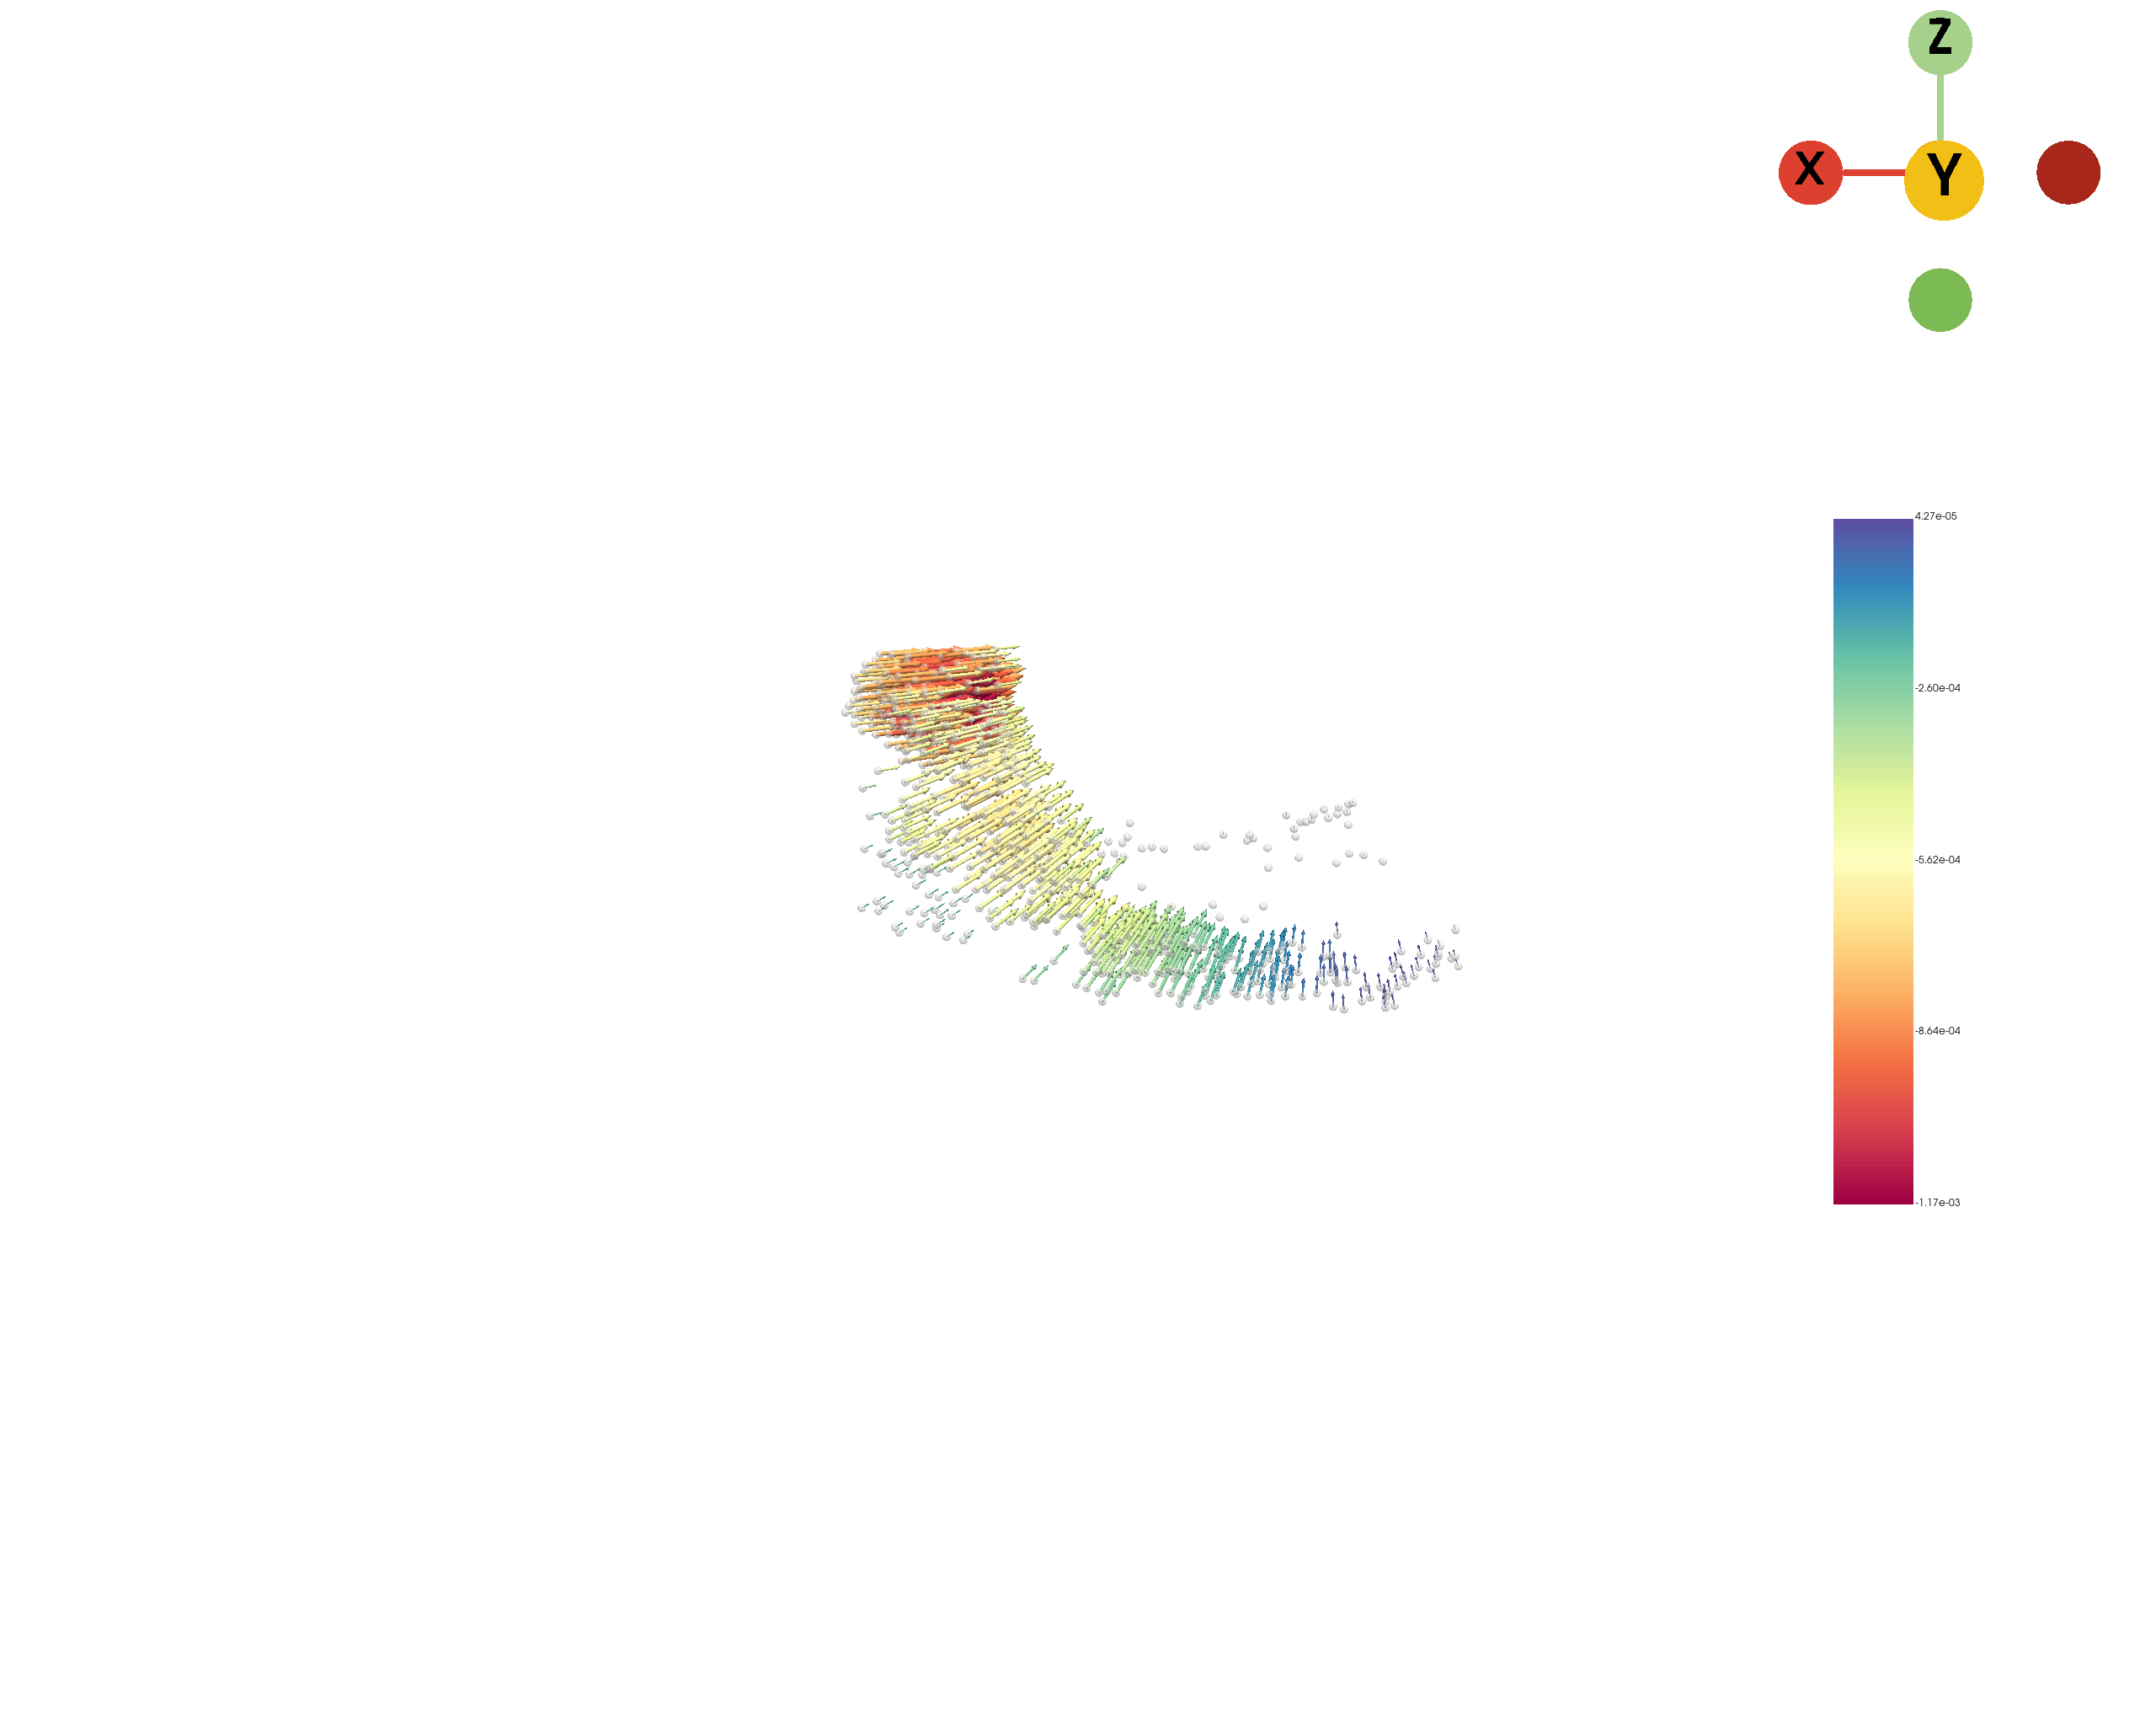

|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


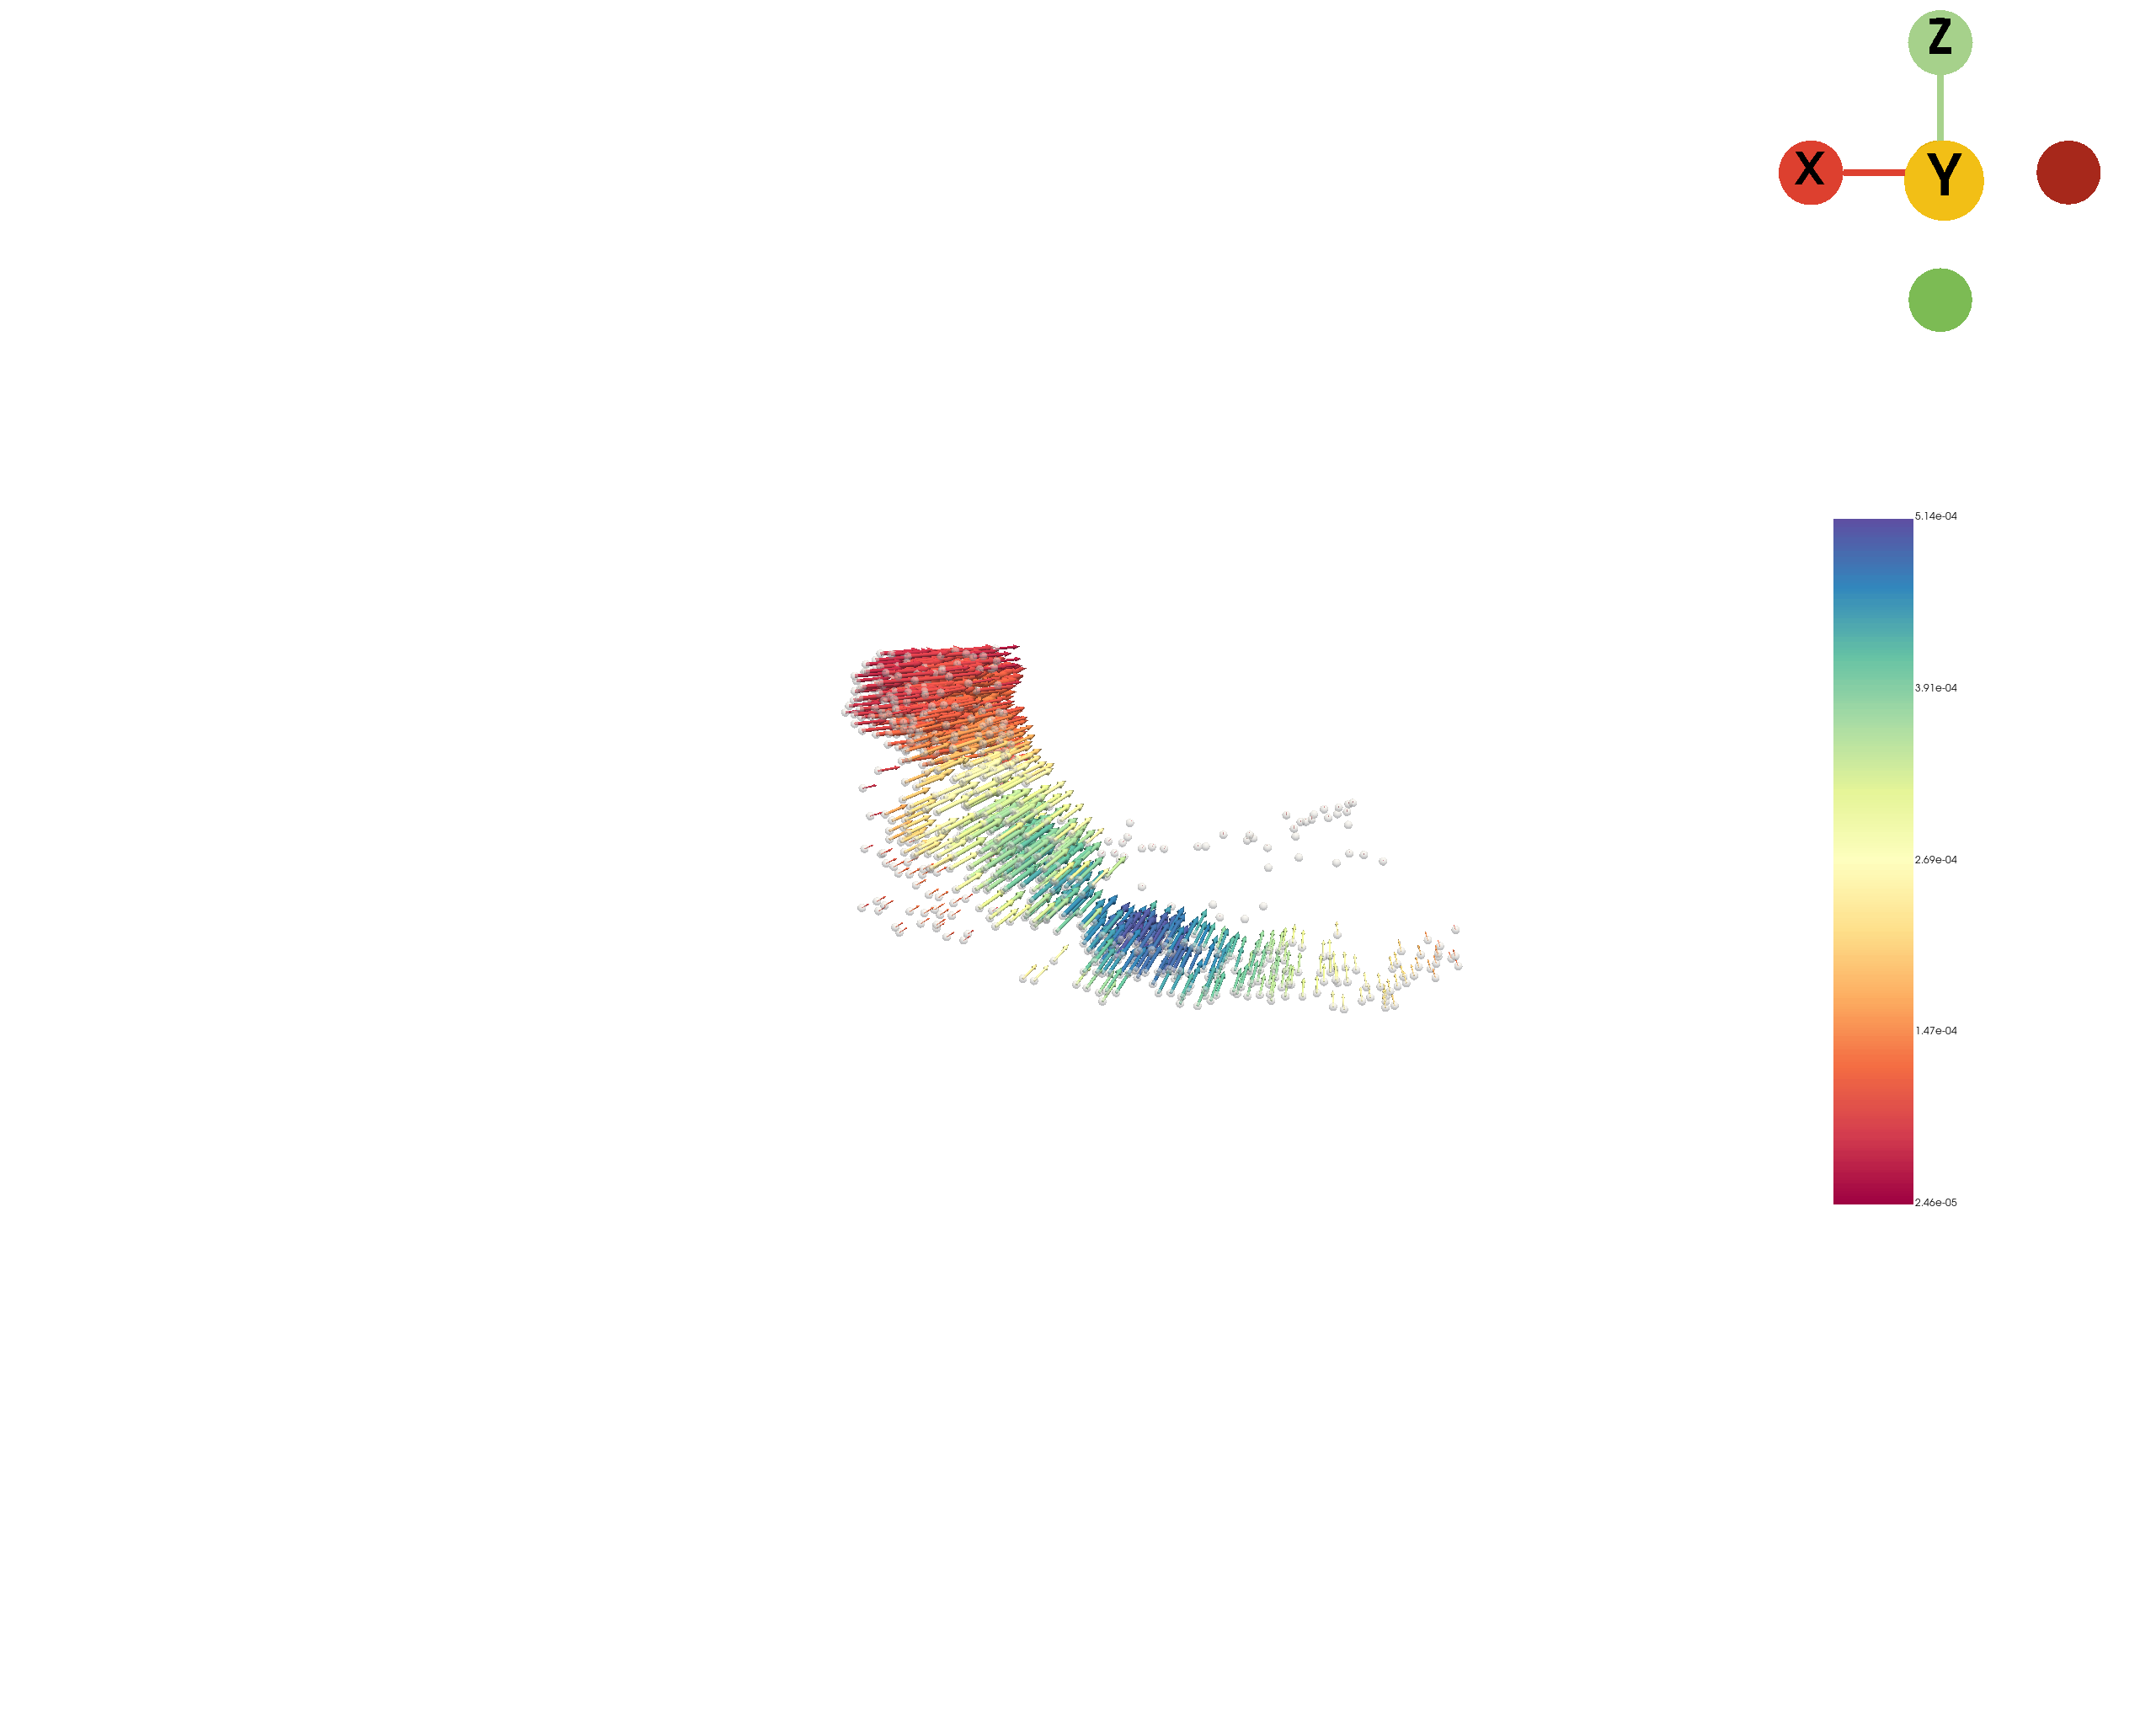

In [11]:
for i, k in zip([0, 2], ["V_x", "V_z"]):
    vector_arrows1,_ = st.tdr.construct_field(
        model=pc,
        vf_key="vectors",
        arrows_scale_key="vectors",
        n_sampling=None,
        factor=30000,
        key_added=k,
        label=pc.point_data["vectors"][:, i].flatten(),
        color= "rainbow",
    )
    st.pl.three_d_plot(
        model=st.tdr.collect_models([pc, vector_arrows1]),
        key=["tissue", k],
        colormap=["gainsboro", "Spectral"],
        opacity=[0.5, 1],
        model_style=["points", "surface"],
        model_size=[10, 5],
        jupyter="static",
        background="white",
        window_size=(2560, 2048),
        cpo=cpo,
        filename=os.path.join(out_image_path, f"amnioserosa_morphofield_vector_arrows_pc_model_{k}.pdf")
    )

|-----> [Running TRN] in progress: 100.0000%|-----> [Running TRN] completed [74.7969s]


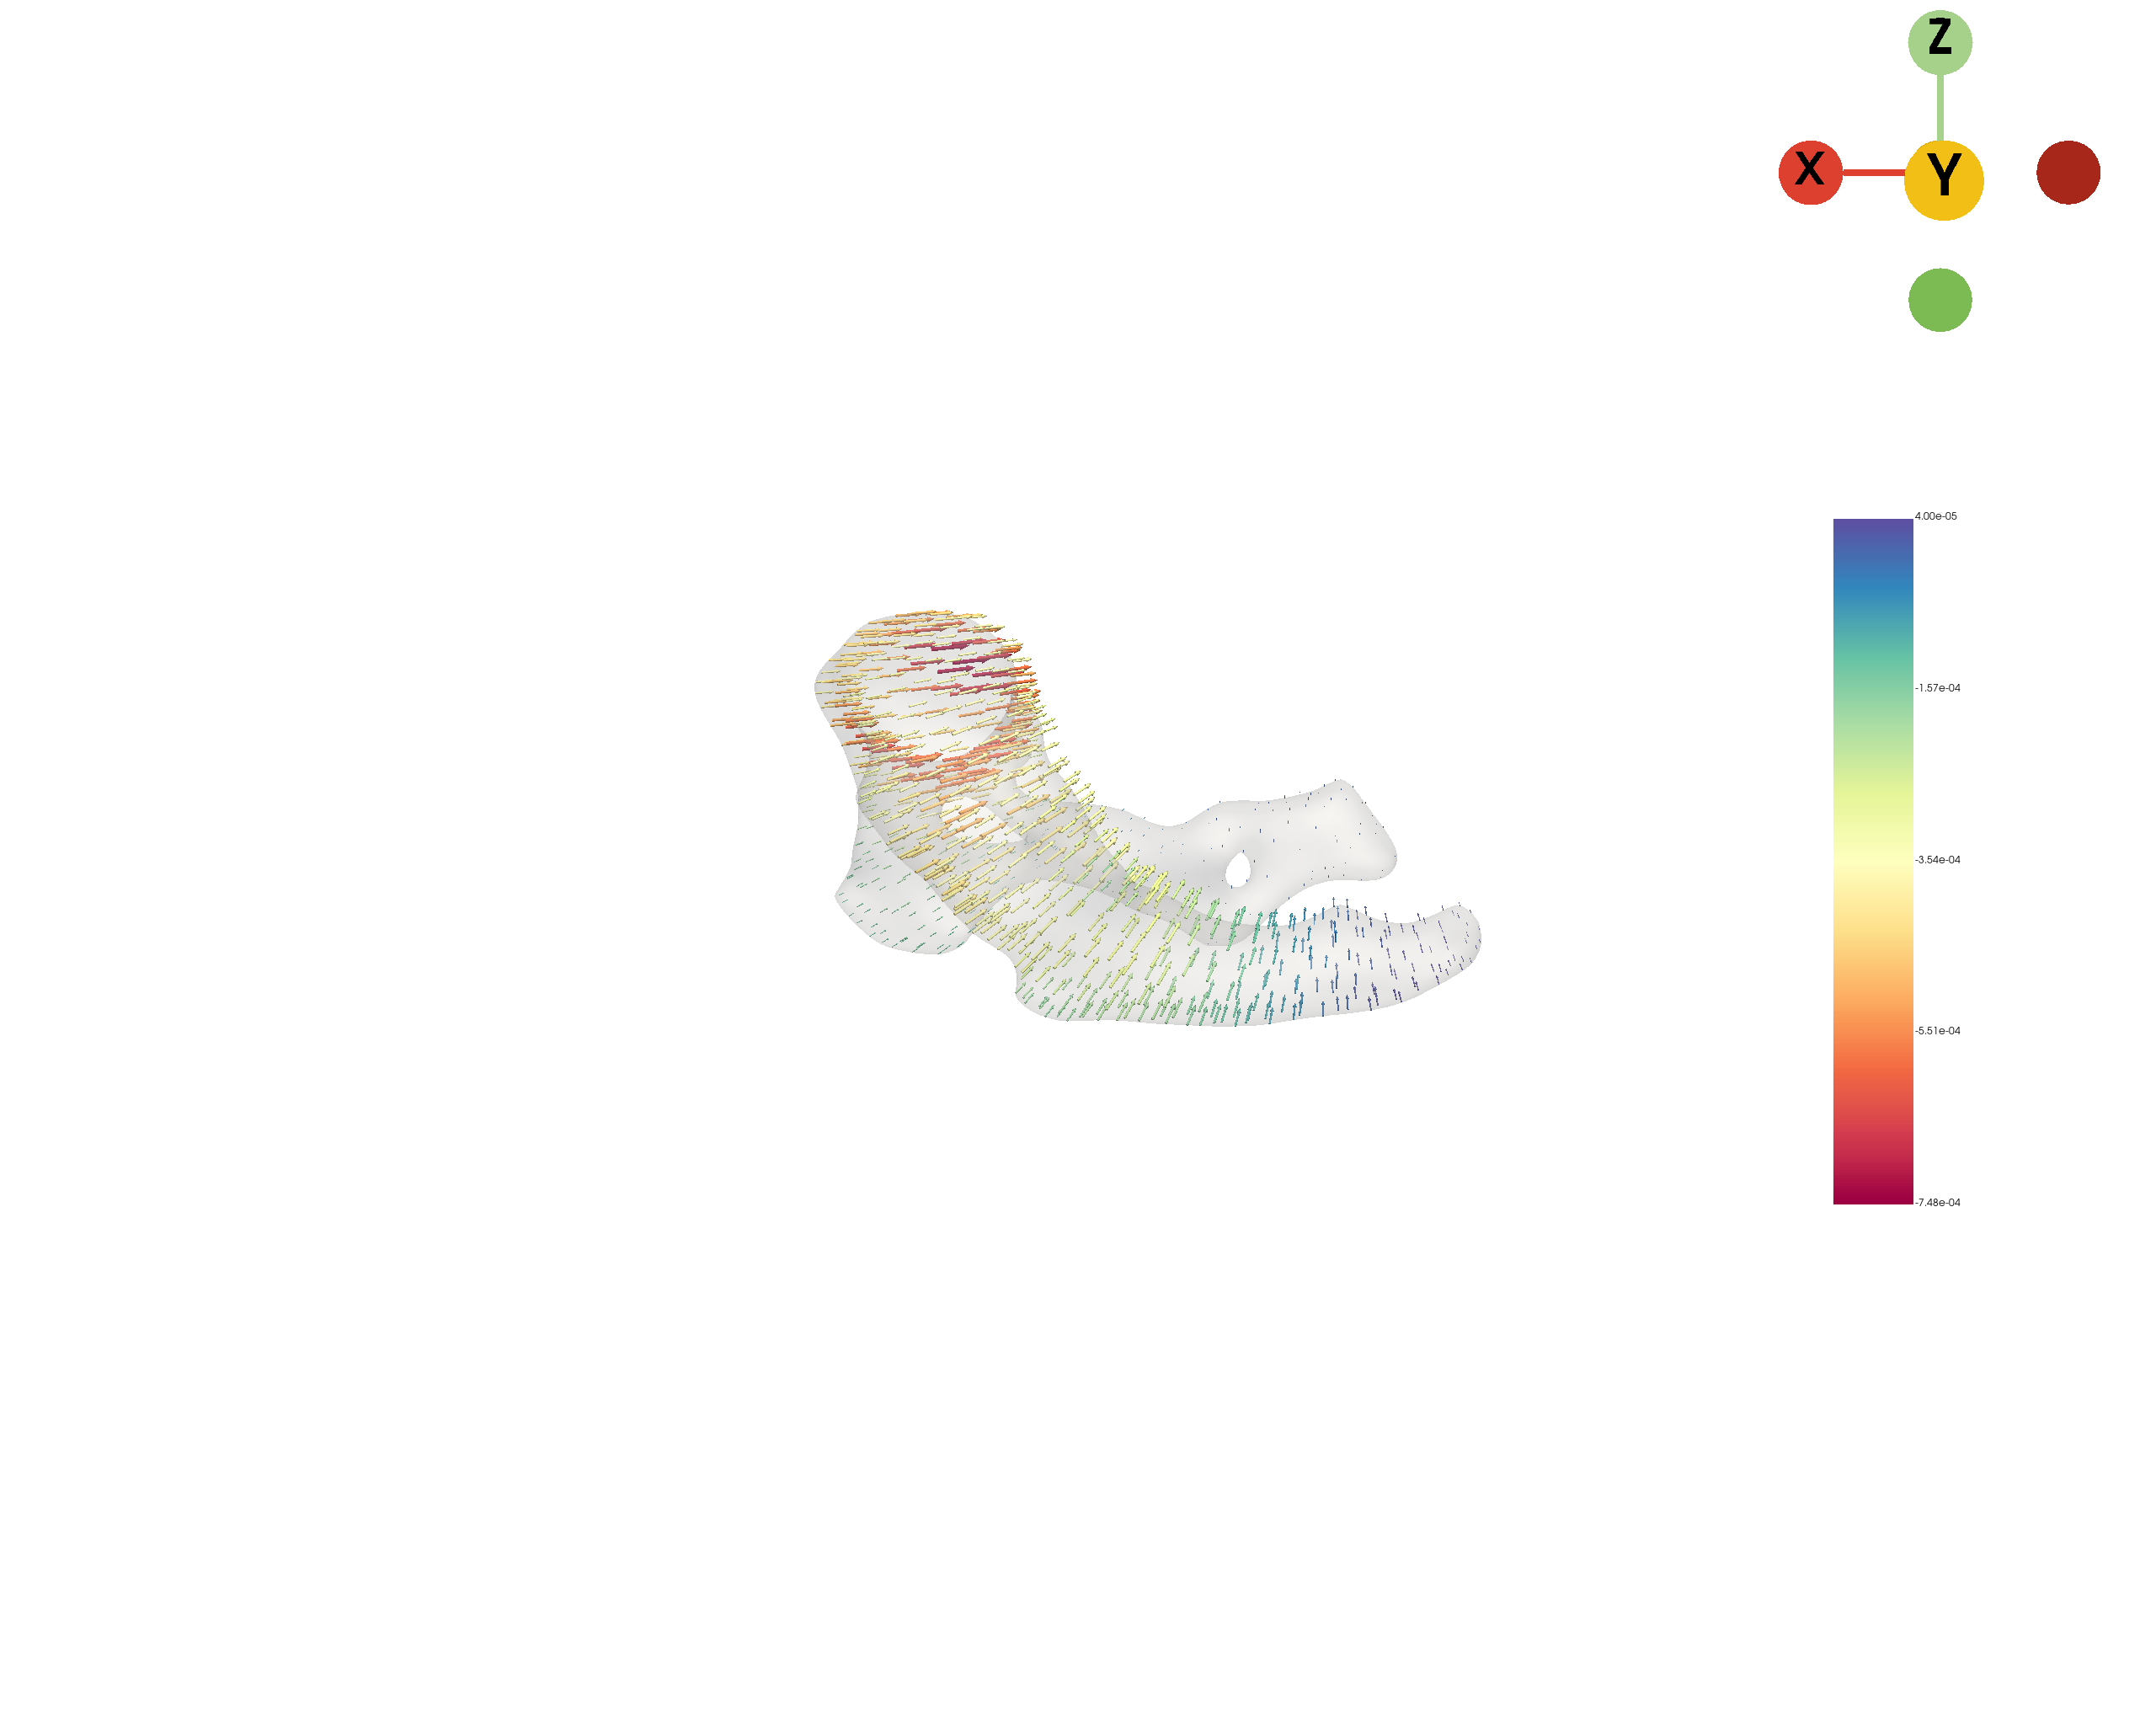

|-----> [Running TRN] in progress: 100.0000%|-----> [Running TRN] completed [74.7976s]


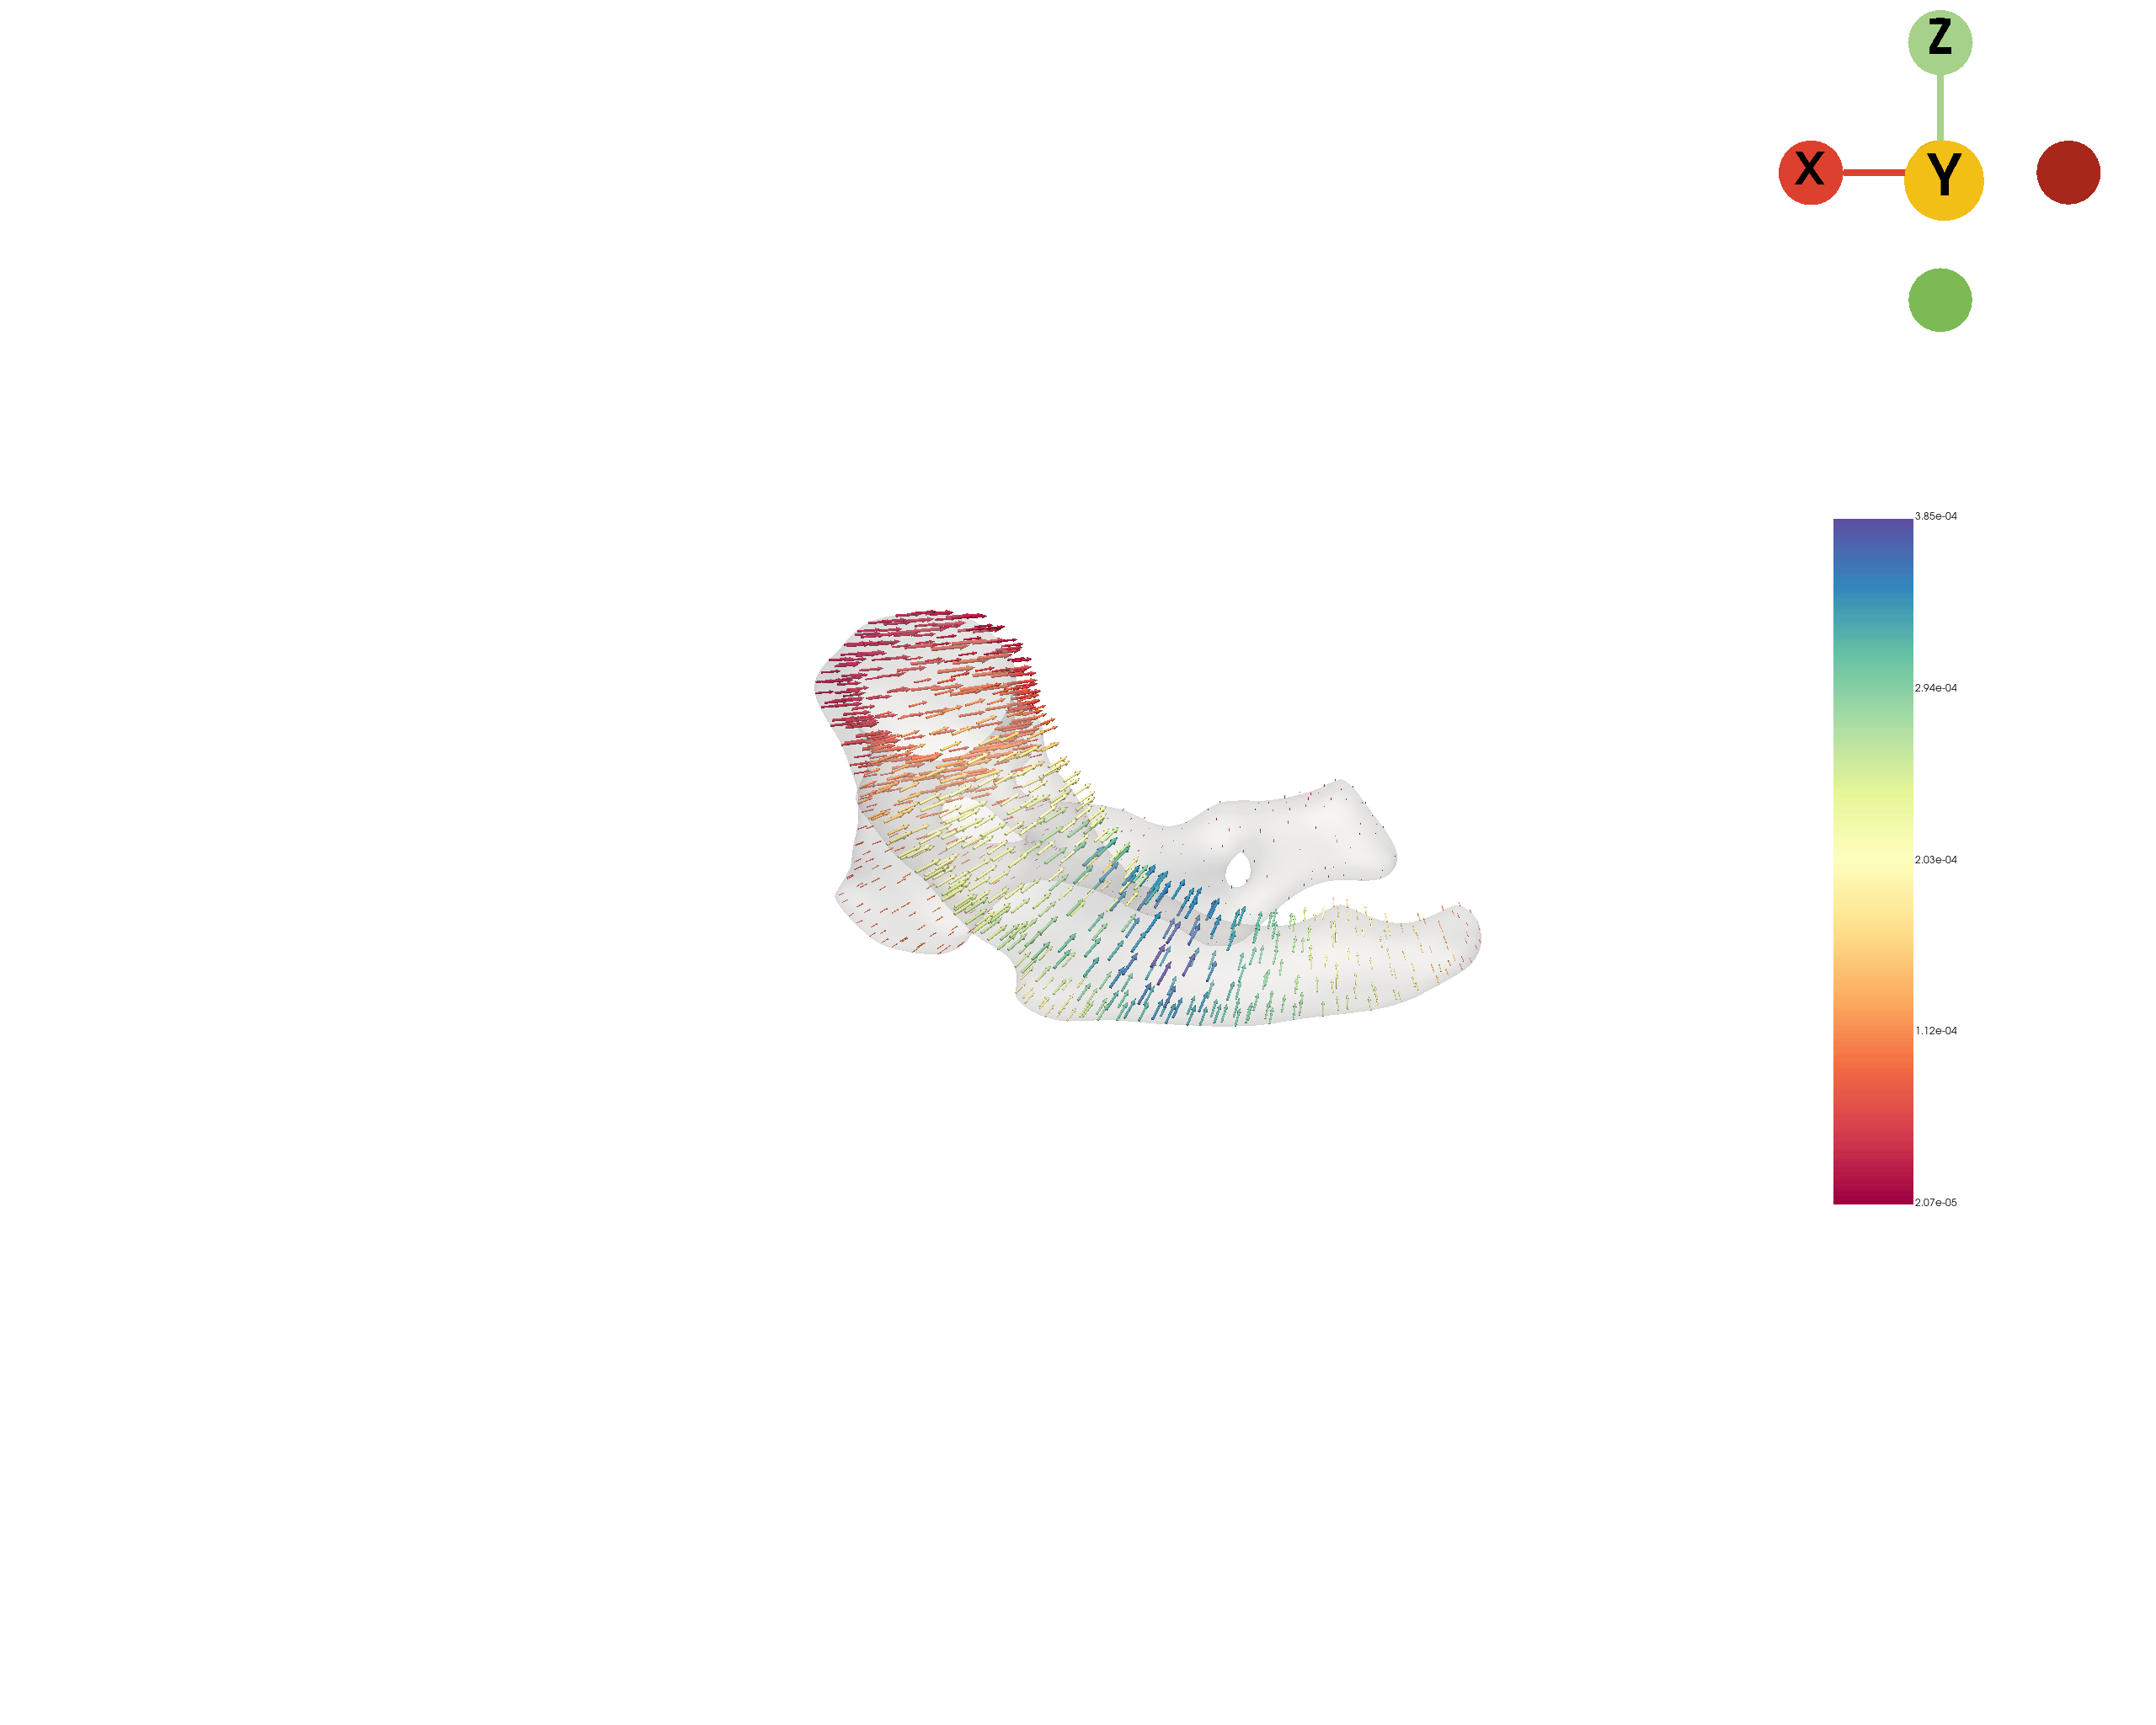

In [20]:
for i, k in zip([0, 2], ["V_x", "V_z"]):
    vector_arrows2,_ = st.tdr.construct_field(
        model=mesh,
        vf_key="vectors",
        arrows_scale_key="vectors",
        n_sampling=1000,
        sampling_method="trn",
        factor=30000,
        key_added=k,
        label=mesh.point_data["vectors"][:, i].flatten(),
    )
    st.pl.three_d_plot(
        model=st.tdr.collect_models([mesh, vector_arrows2]),
        key=["tissue", k],
        colormap=["gainsboro", "Spectral"],
        opacity=[0.2, 1],
        model_style="surface",
        jupyter="static",
        background="white",
        window_size=(2560, 2048),
        cpo=cpo,
        filename=os.path.join(out_image_path, f"amnioserosa_morphofield_vector_arrows_mesh_model_{k}.pdf")
    )

## Predict the cell developmentalal trajectory

In [21]:
st.tdr.morphopath(
    adata=adata,
    # layer="log1p_X",
    vf_key="VecFld_morpho",
    key_added="fate_morpho",
    t_end=20000,
    interpolation_num=50,
    cores=20
)

|-----? The number of cells is more than 200. You may want to lower the max number of cell trajectories to draw.
|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


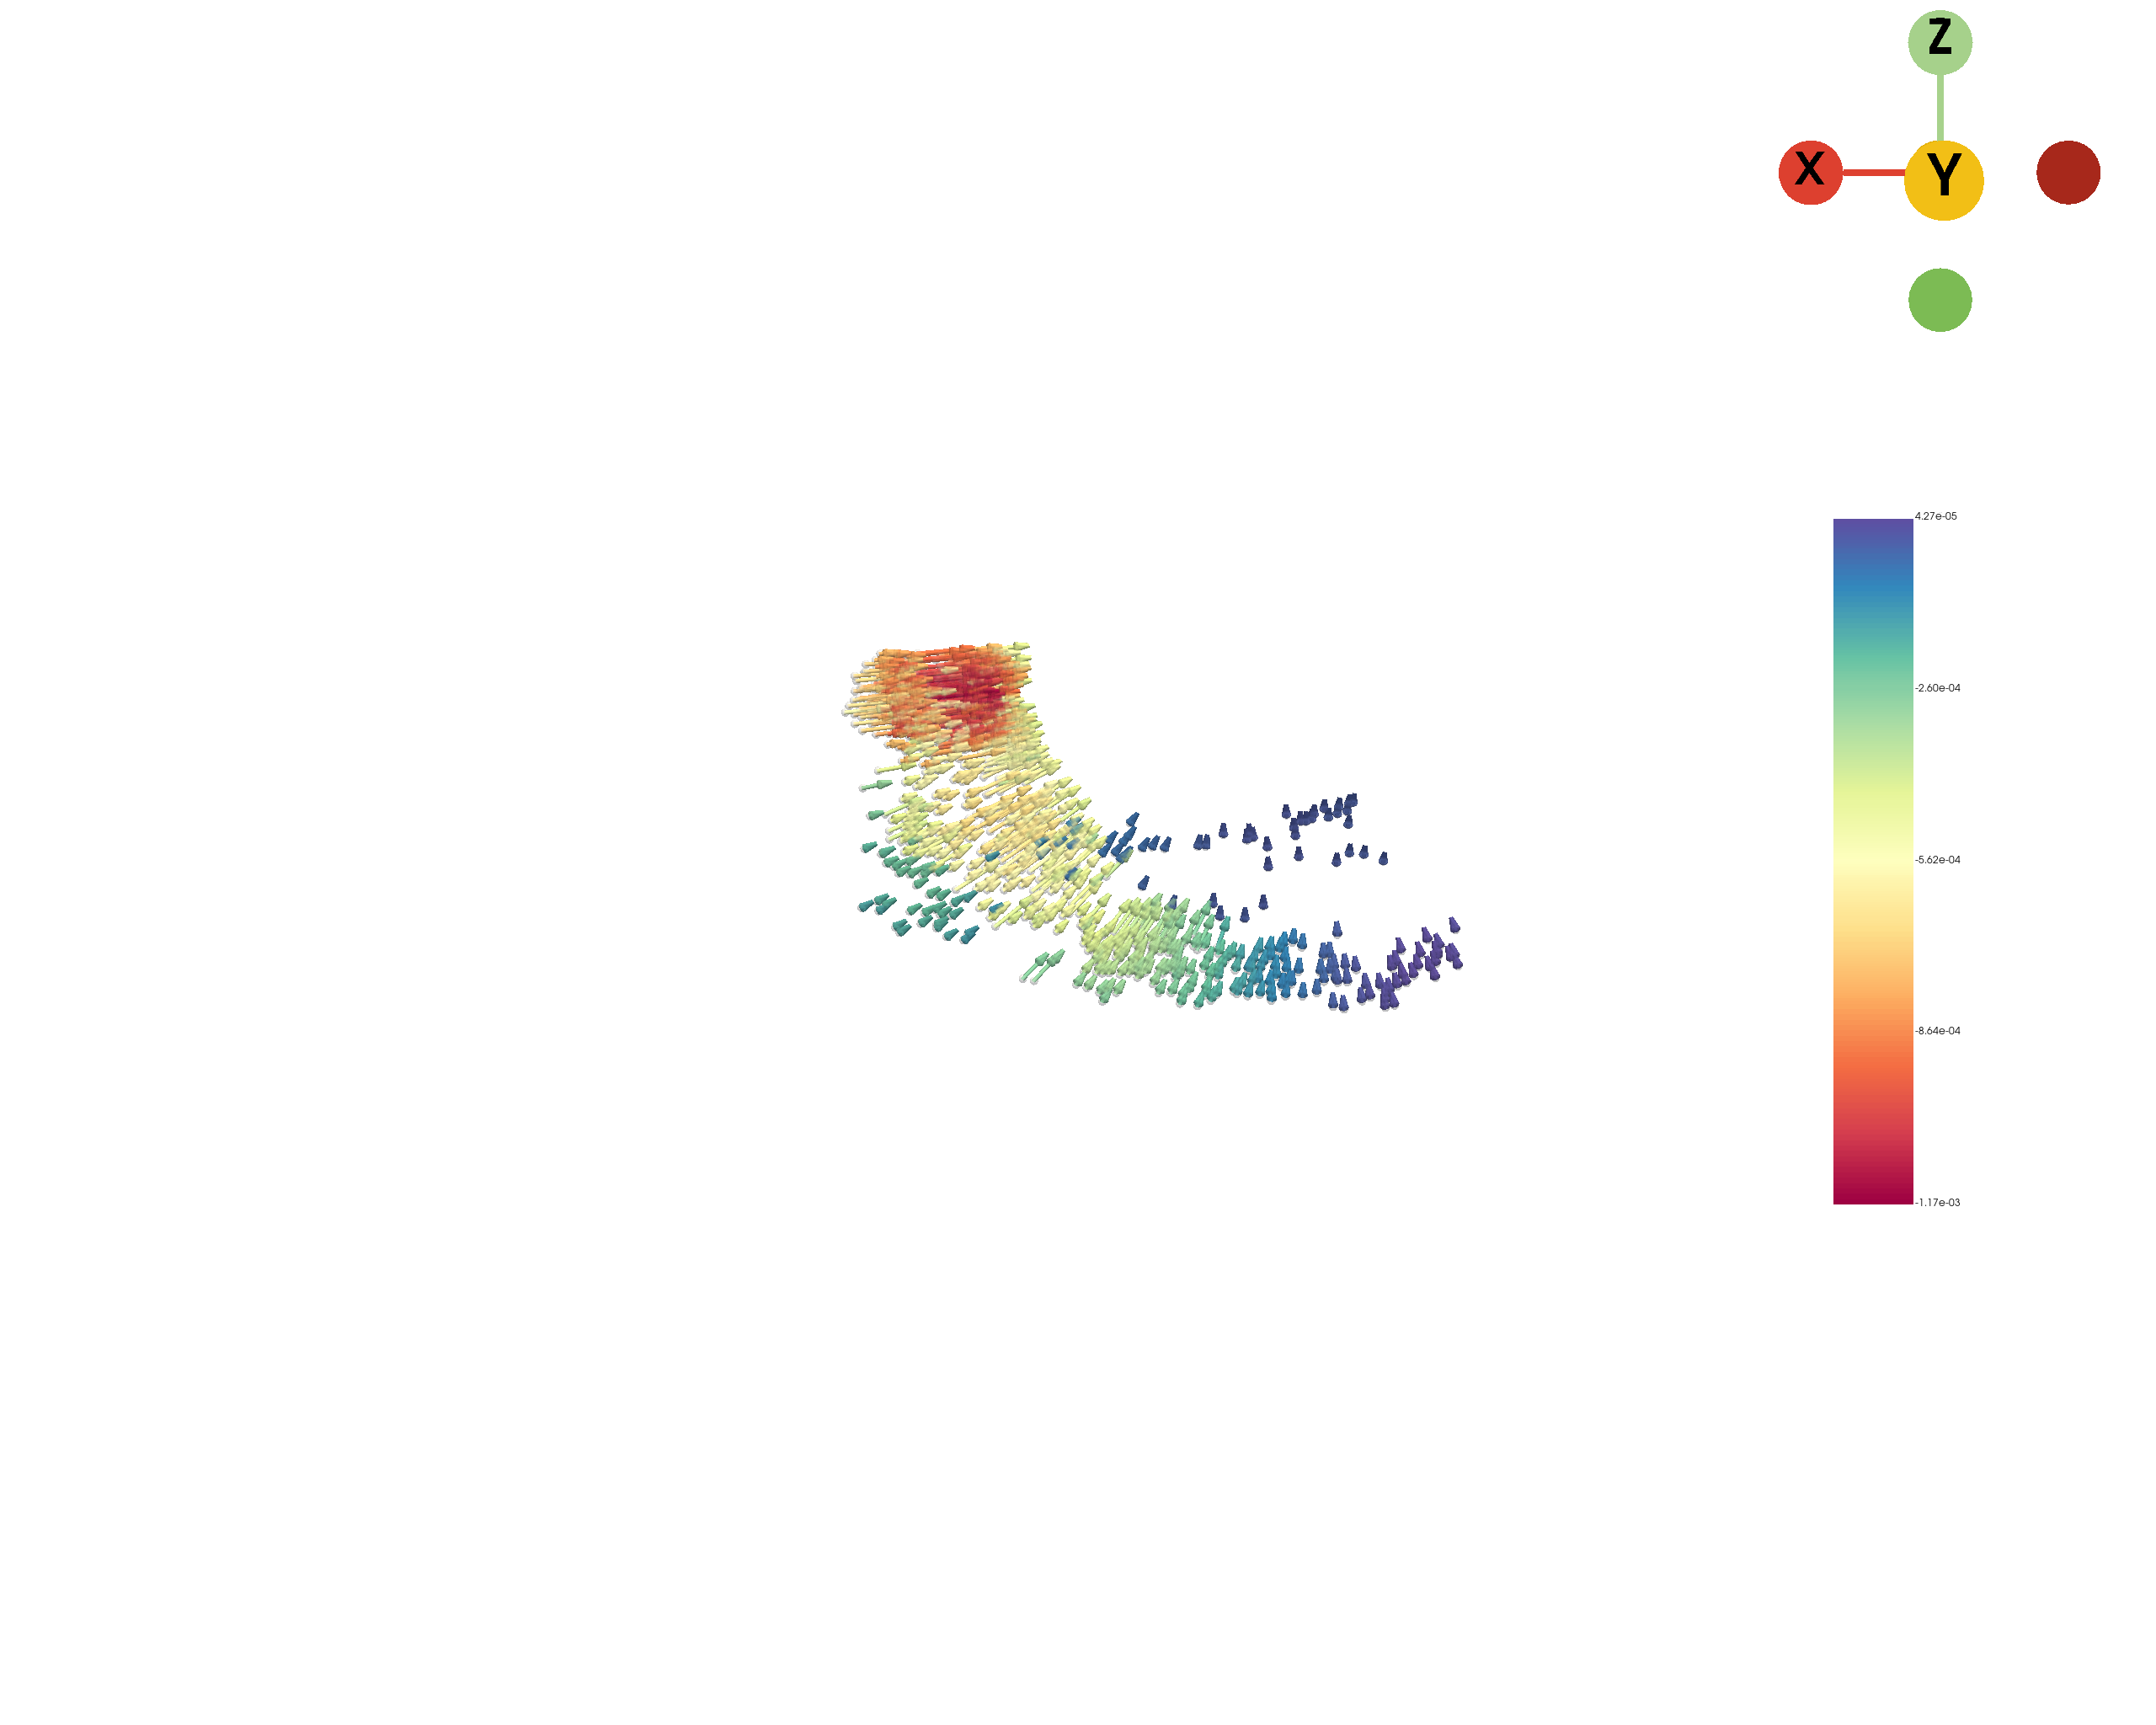

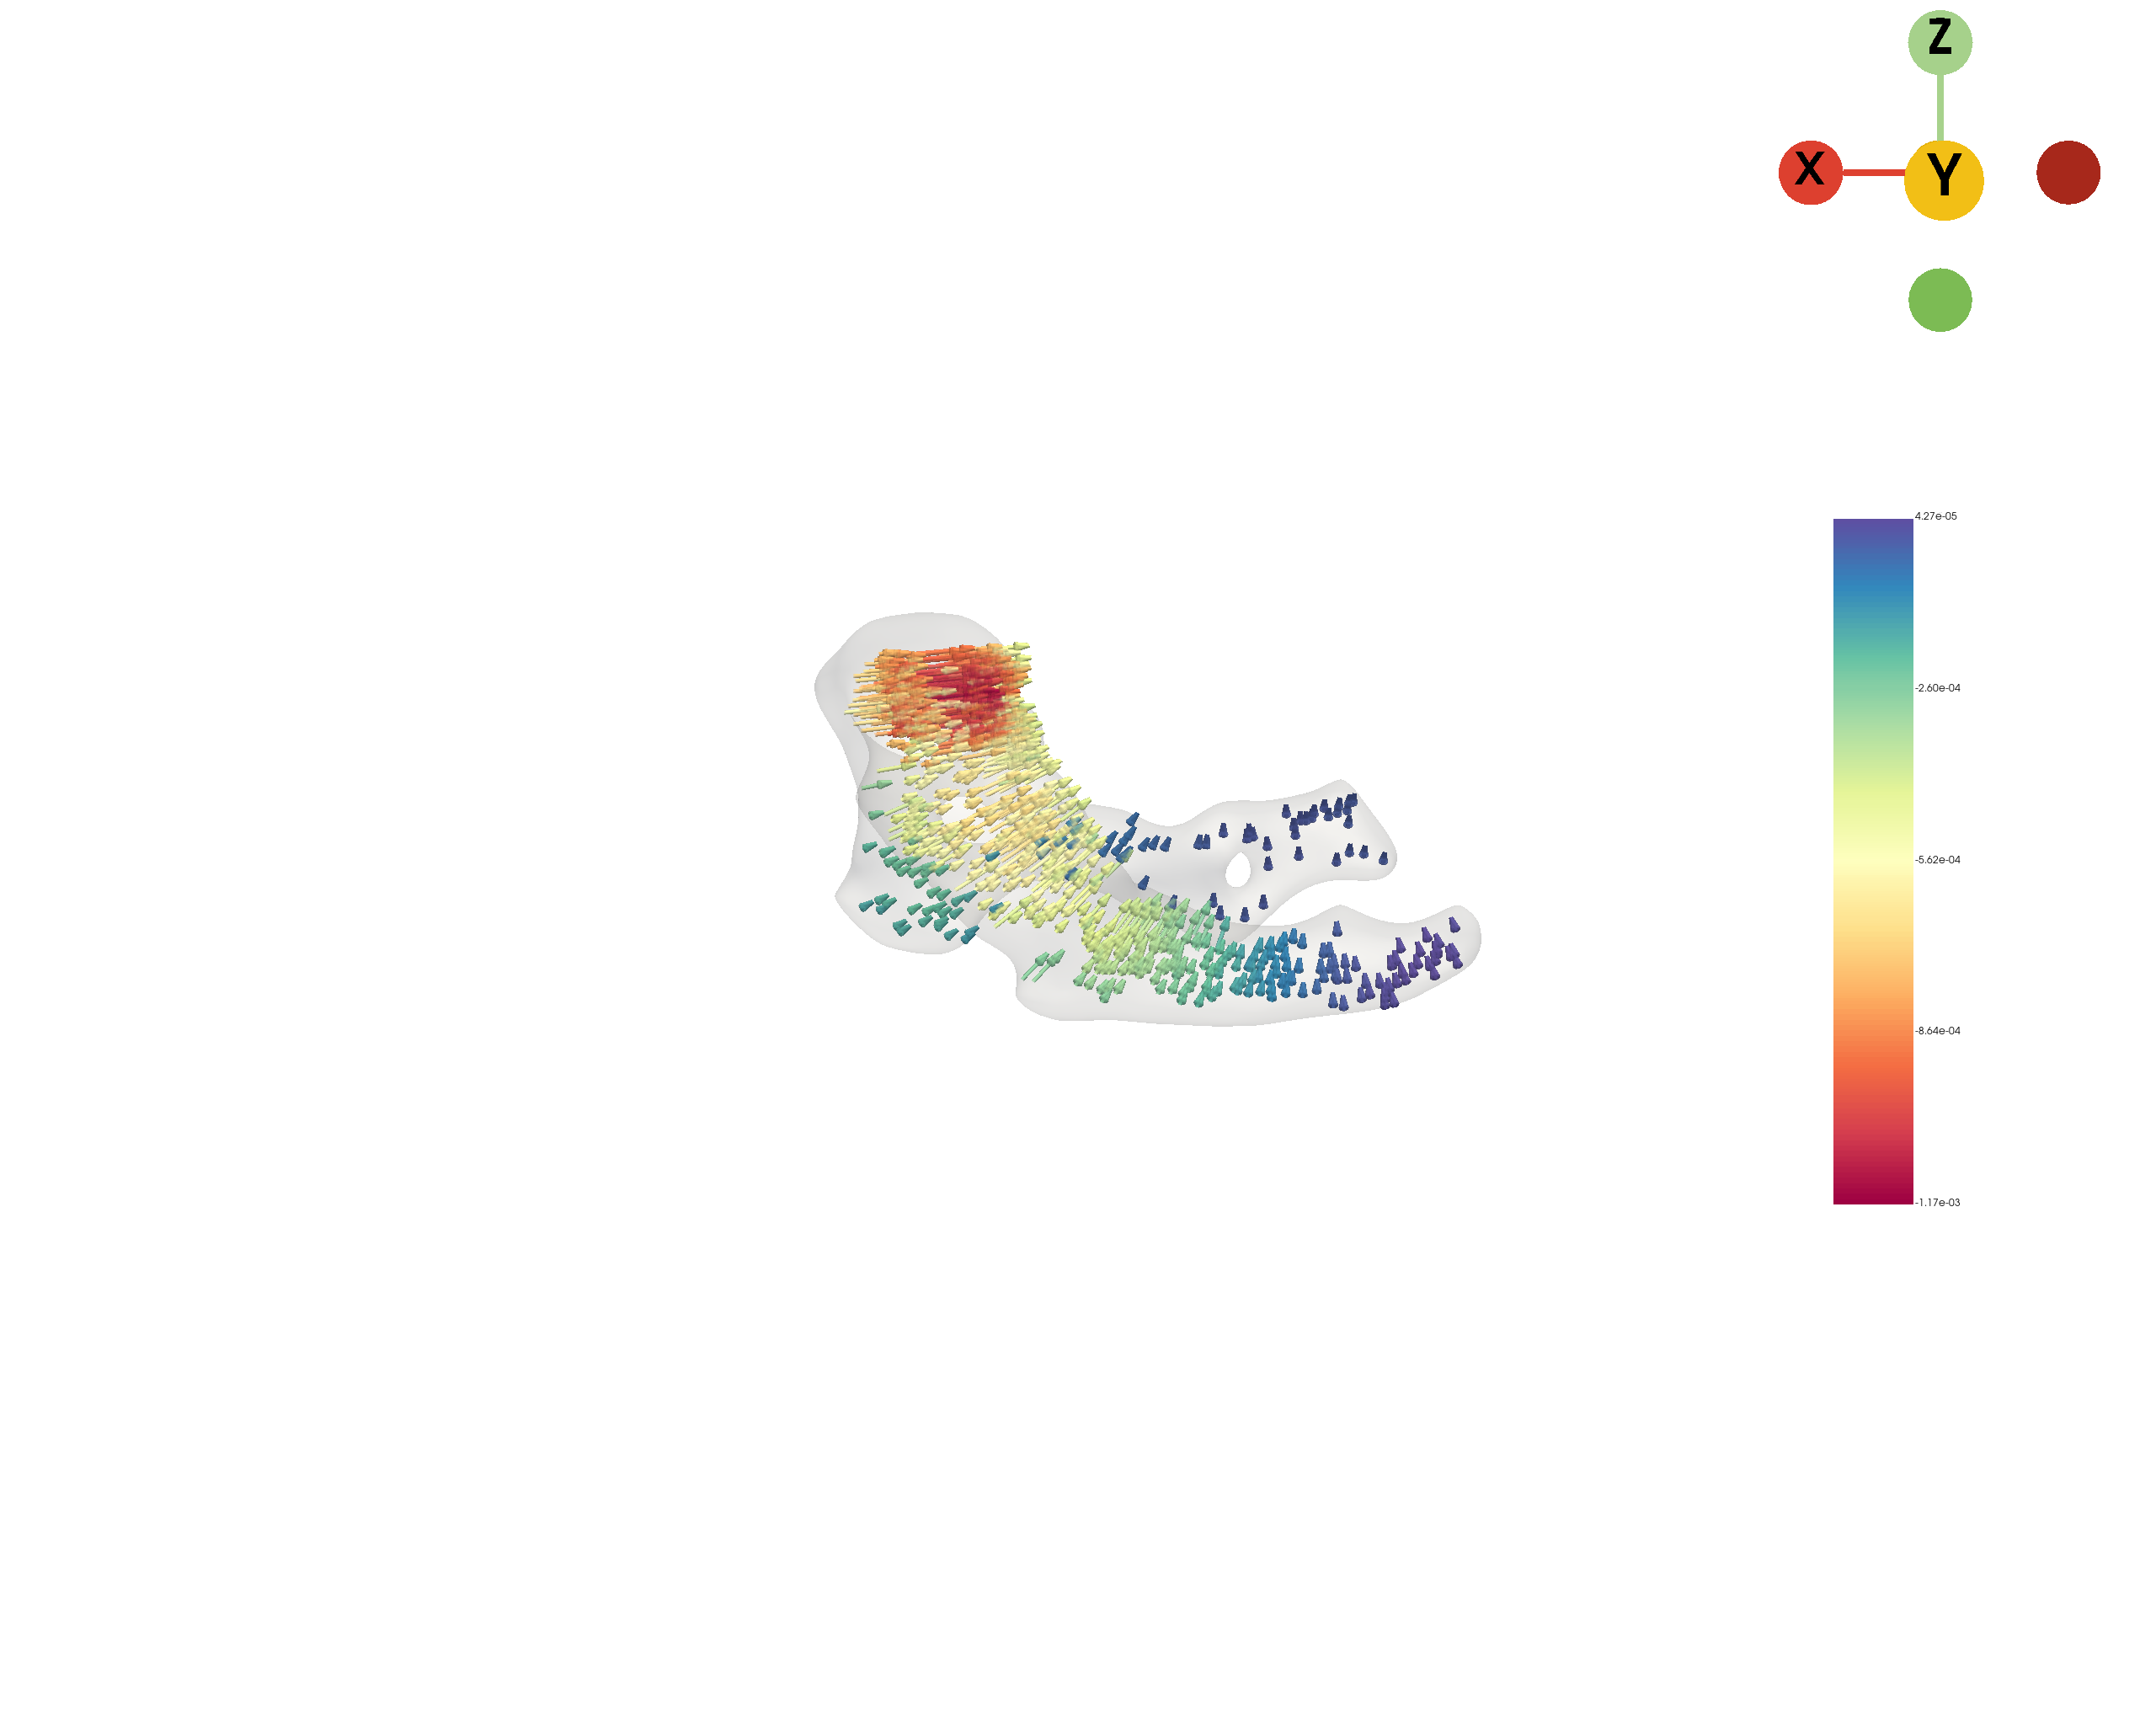

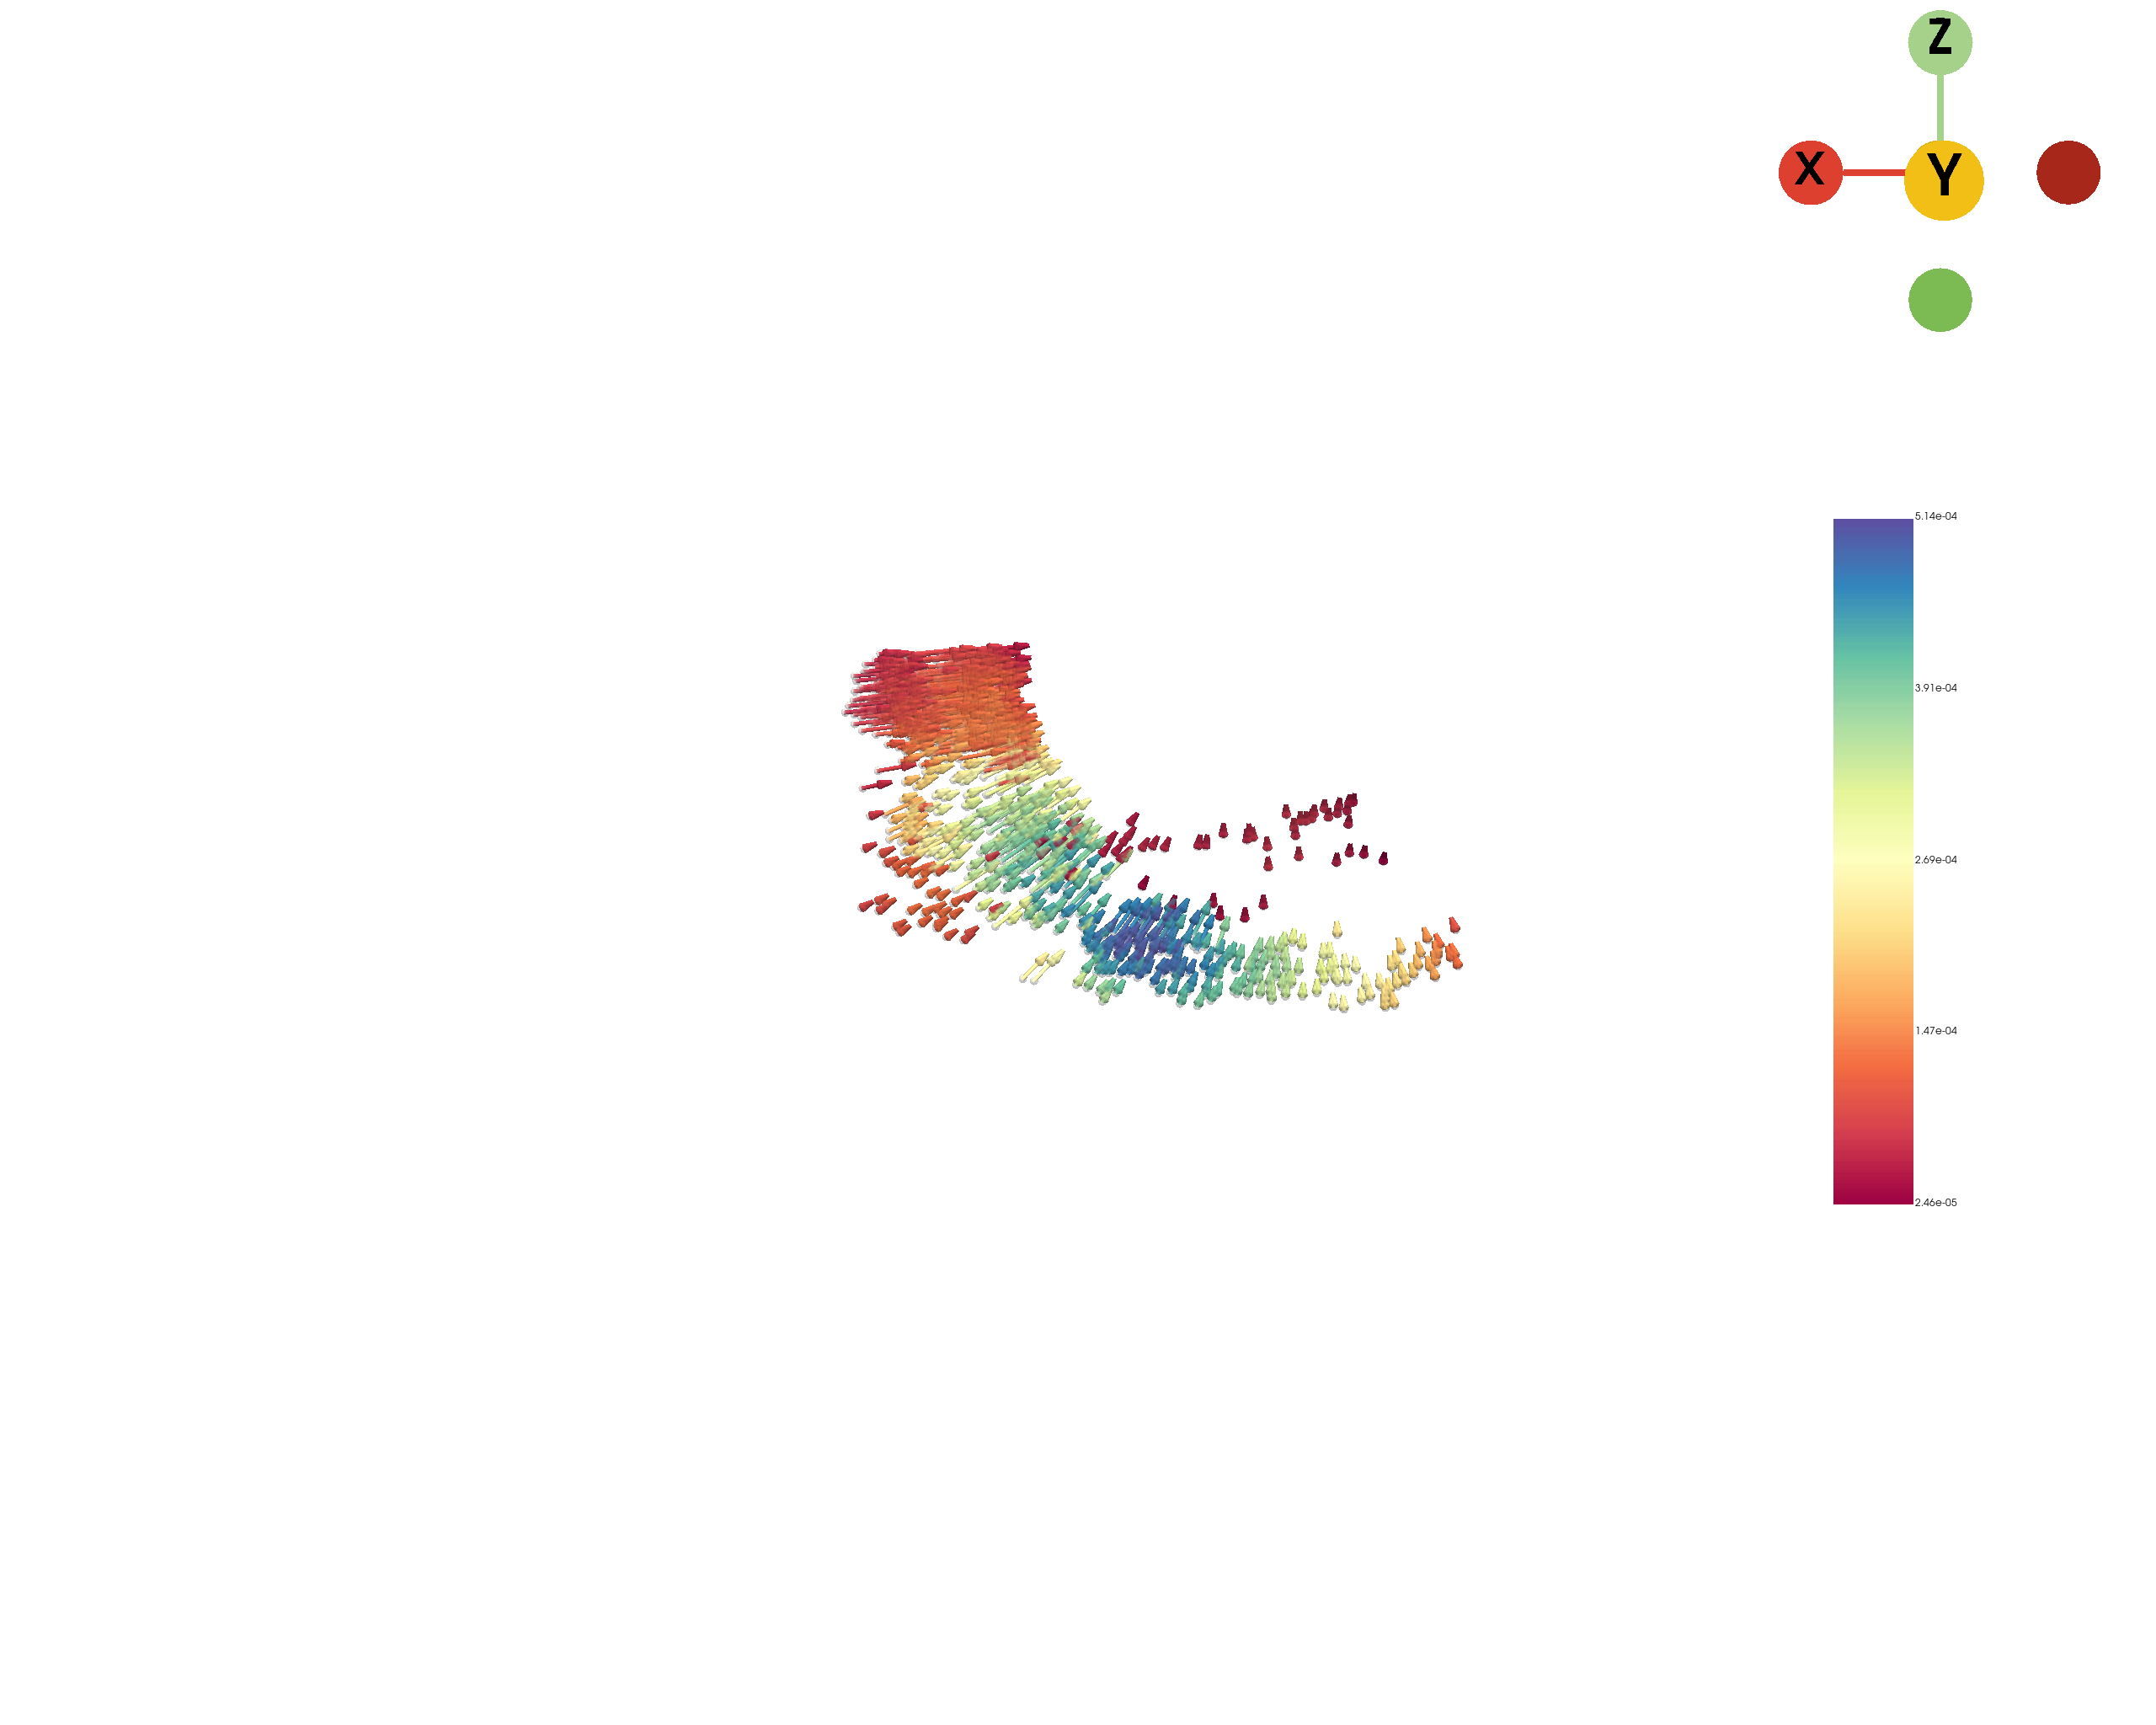

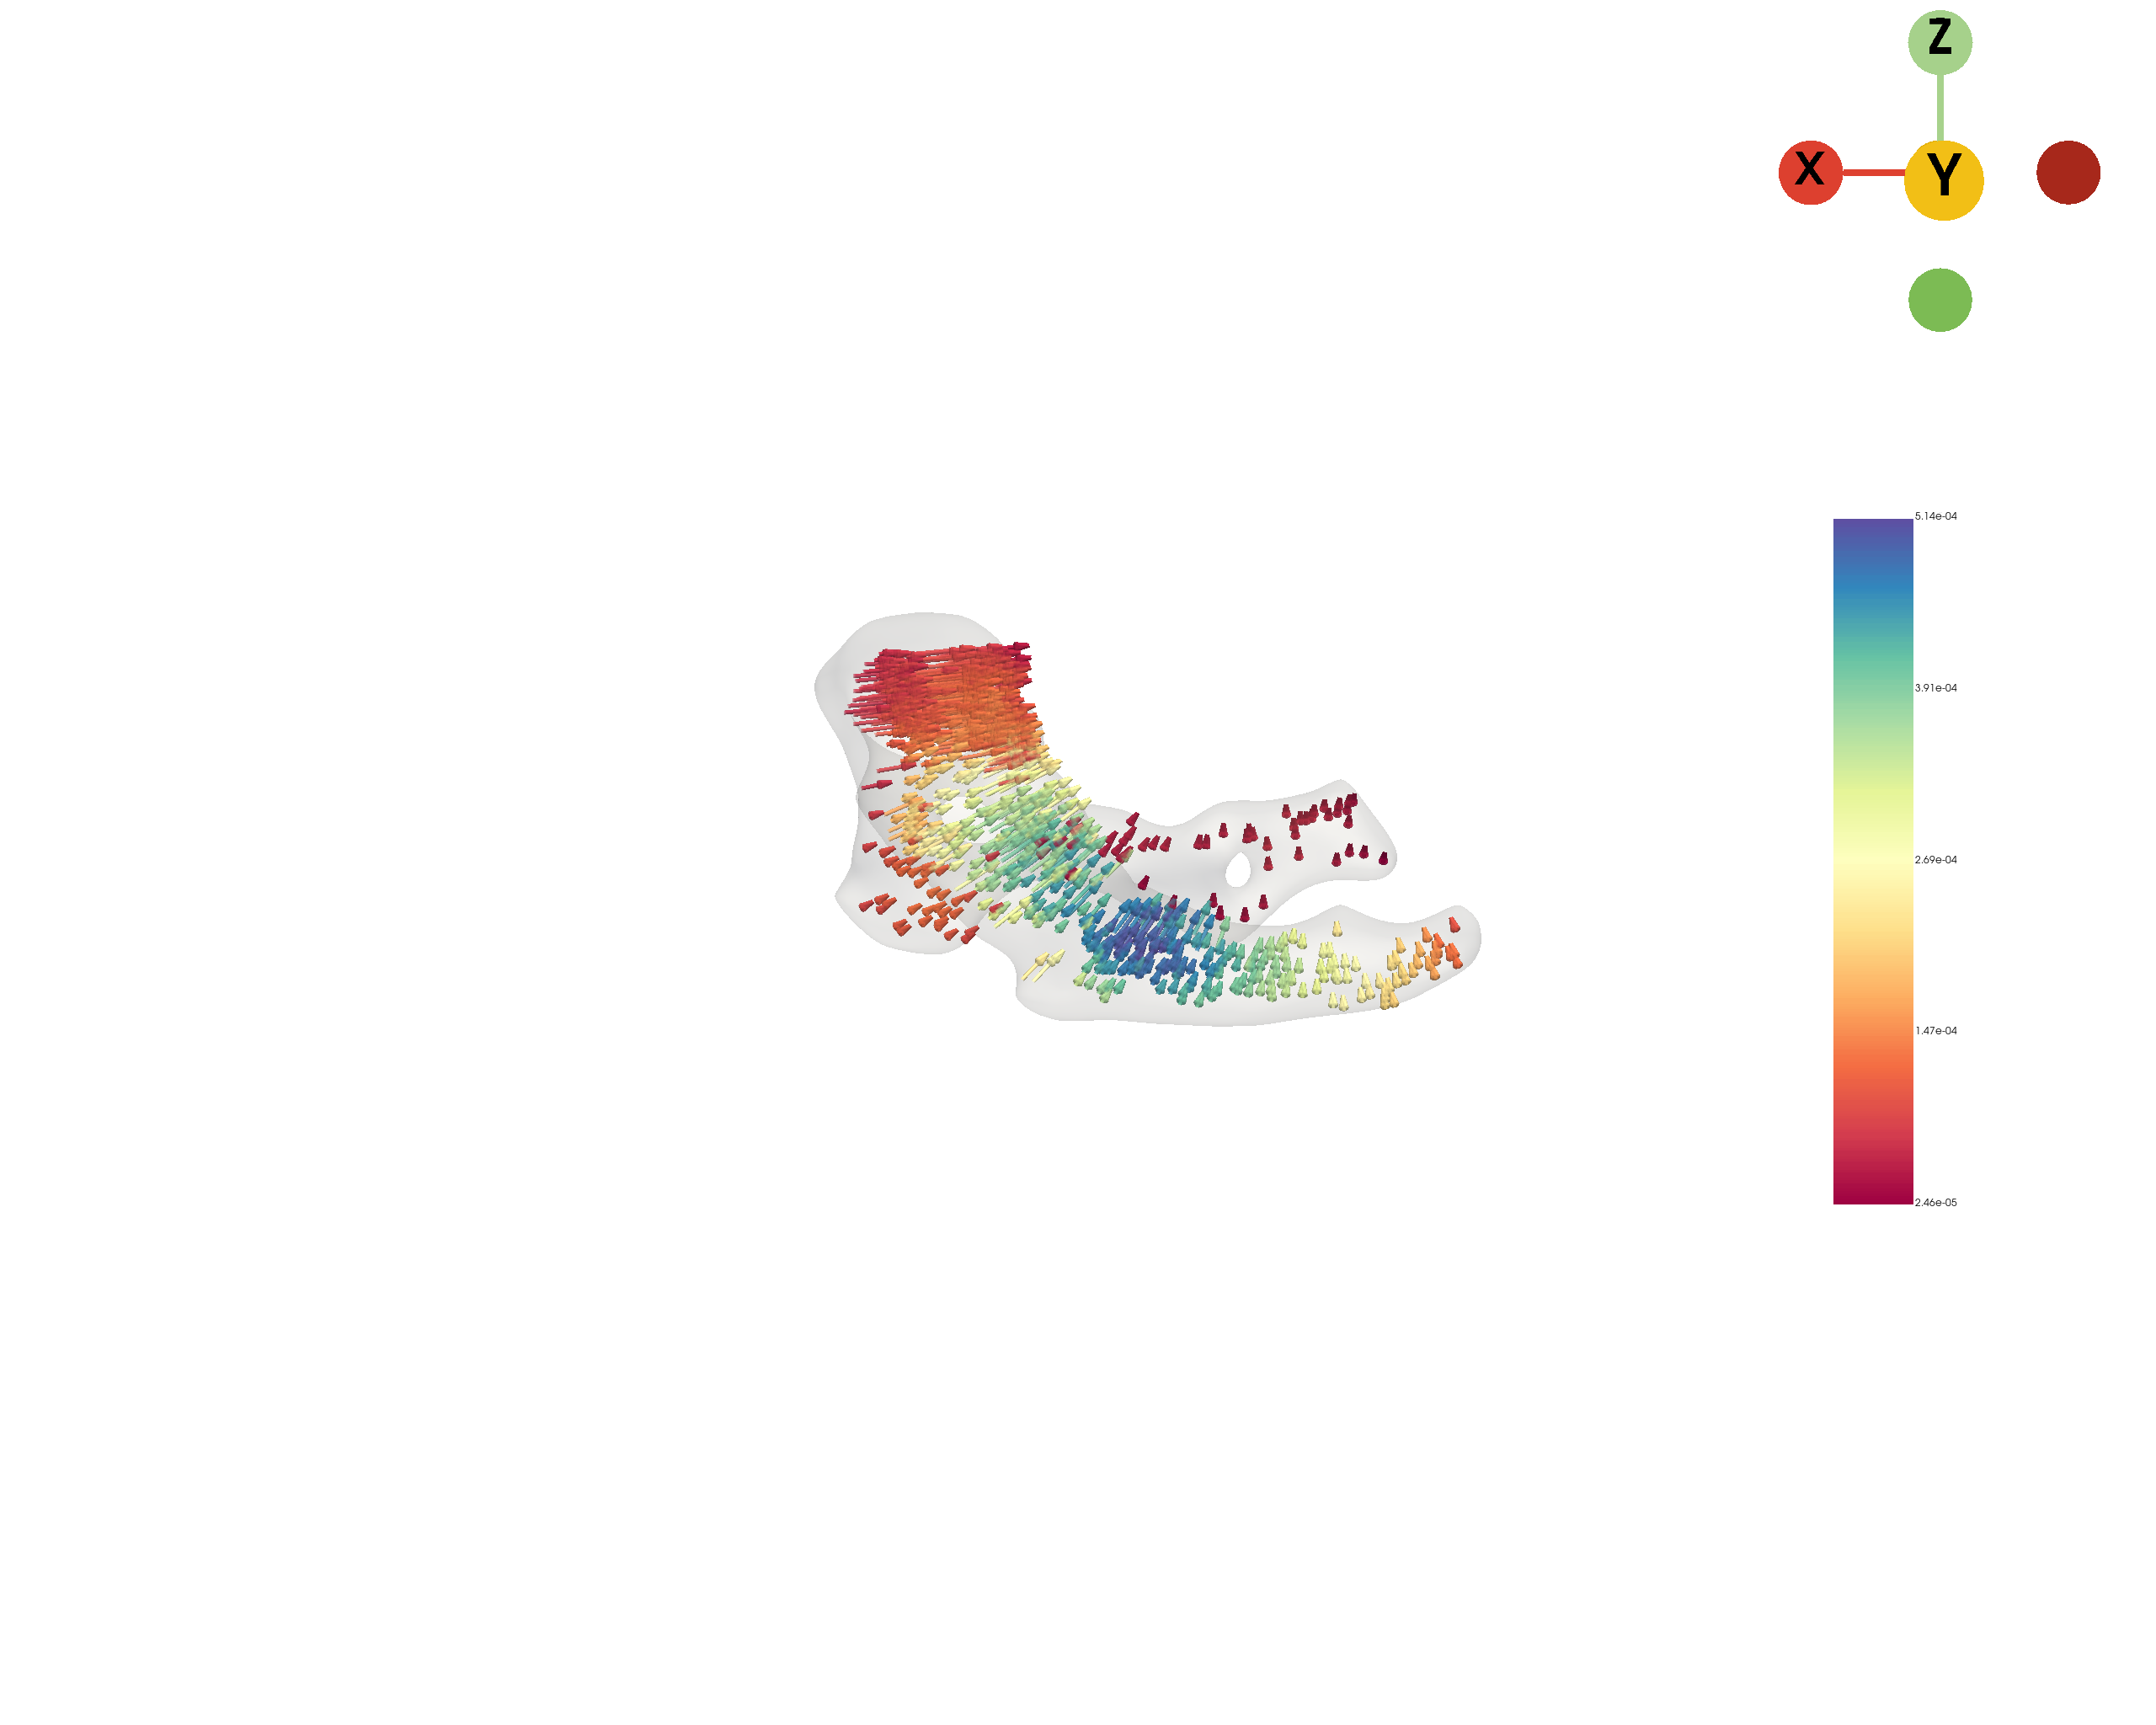

In [23]:
trajectory_model, _ = st.tdr.construct_trajectory(
    adata=adata,
    fate_key="fate_morpho",
    n_sampling=None,
    sampling_method="trn",
    key_added="obs_index",
    label=np.asarray(adata.obs.index), # stage1_tissue_adata.uns["VecFld_morpho"]["V"][:, 2].flatten(),
)
for i, k in zip([0, 2], ["V_x", "V_z"]):
    adata.obs[k] = adata.uns["VecFld_morpho"]["V"][:, i].flatten()
    st.tdr.add_model_labels(
        model=trajectory_model,
        key_added=k,
        labels=np.asarray(adata[np.asarray(trajectory_model.point_data["obs_index"])].obs[k]),
        colormap="Spectral",
        where="point_data",
        inplace=True,
    )
    st.pl.three_d_plot(
        model=st.tdr.collect_models([pc, trajectory_model]),
        key=["tissue", k],
        opacity=[0.5, .5],
        model_style=["points", "wireframe"],
        model_size=[10, 5],
        colormap=["gainsboro", "Spectral"],
        jupyter="static",
        background="white",
        window_size=(2560, 2048),
        cpo=cpo,
        filename=os.path.join(out_image_path, f"amnioserosa_morphofield_trajectory_pc_model_{k}.pdf")
    )
    st.pl.three_d_plot(
        model=st.tdr.collect_models([mesh, trajectory_model]),
        key=["tissue", k],
        opacity=[0.2, .5],
        model_style=["surface", "wireframe"],
        model_size=5,
        colormap=["gainsboro", "Spectral"],
        jupyter="static",
        background="white",
        window_size=(2560, 2048),
        cpo=cpo,
        filename=os.path.join(out_image_path, f"amnioserosa_morphofield_trajectory_mesh_model_{k}.pdf")
    )

## Morphometrics feature

In [24]:
adata.X = adata.layers["X_counts"].copy()

In [25]:
st.tdr.morphofield_velocity(adata=adata, vf_key="VecFld_morpho", key_added="morpho_velocity",)
st.tdr.morphofield_acceleration(adata=adata, vf_key="VecFld_morpho", key_added="morpho_acceleration",)
st.tdr.morphofield_curvature(adata=adata, vf_key="VecFld_morpho", key_added="morpho_curvature")
st.tdr.morphofield_curl(adata=adata, vf_key="VecFld_morpho", key_added="morpho_curl",)
st.tdr.morphofield_torsion(adata=adata, vf_key="VecFld_morpho", key_added="morpho_torsion",)
adata

|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.0218s]
|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.0227s]
|-----> [Calculating curvature] in progress: 100.0000%|-----> [Calculating curvature] completed [0.0240s]


Calculating 3-D curl: 100%|██████████| 769/769 [00:00<00:00, 74818.37it/s]

|-----> [Calculating acceleration] in progress: 100.0000%|-----> [Calculating acceleration] completed [0.0202s]



Calculating torsion: 100%|██████████| 769/769 [00:00<00:00, 142913.72it/s]


AnnData object with n_obs × n_vars = 769 × 6729
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'V_x', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion'
    uns: '__type', 'VecFld_morpho', 'fate_morpho', 'morpho_torsion'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial', 'morpho_velocity', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl'
    layers: 'X_counts', 'spliced', 'unspliced'

In [33]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
from pyvista import PolyData, UniformGrid, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid, UniformGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

for gn in ["C15"]:
    _gn = str(gn).replace(":", "_") if ":" in gn else gn

    out_image_genes = os.path.join(out_image_path, "curvature_genes")
    Path(out_image_genes).mkdir(parents=True, exist_ok=True)

    pc_index = pc.point_data["obs_index"].tolist()
    exp = adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0

    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=pc, labels=exp, key_added=gn, alphamap=amap, where="point_data", inplace=True,
                     colormap="afmhot_r")

    st.pl.three_d_plot(
        model=pc,
        key=gn,
        model_style="points",
        model_size=14,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter=False,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
    )

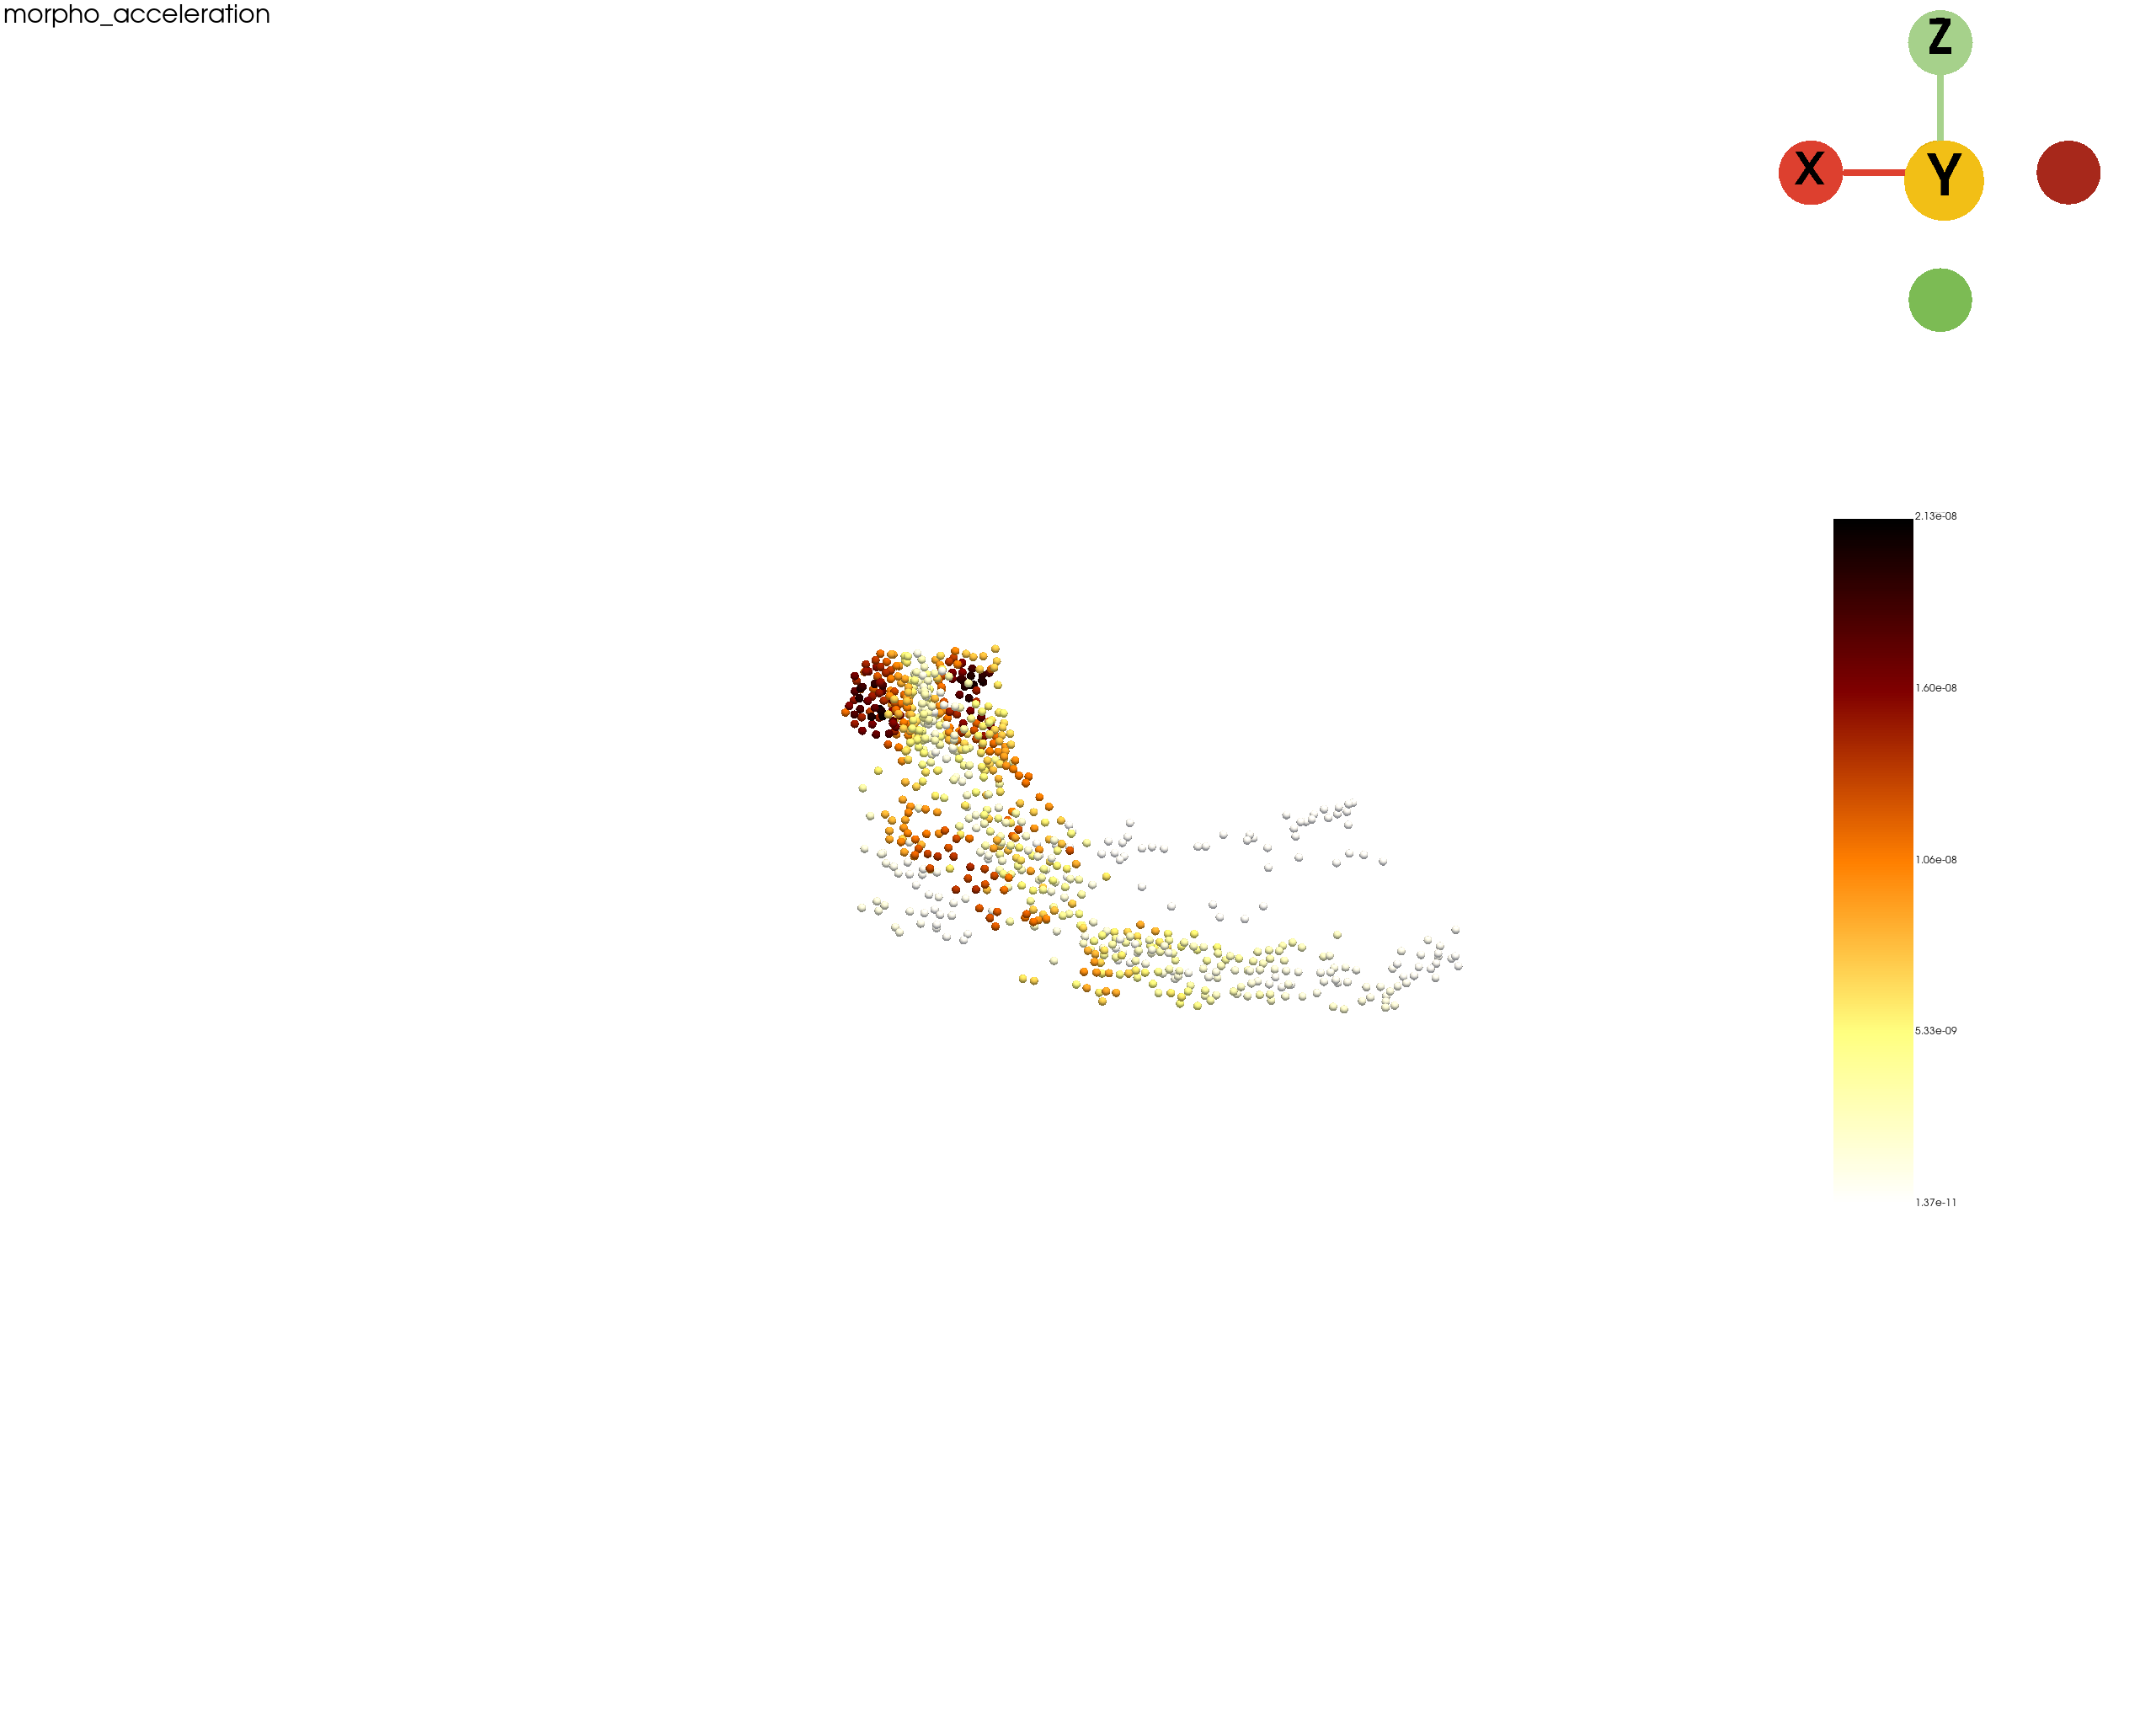

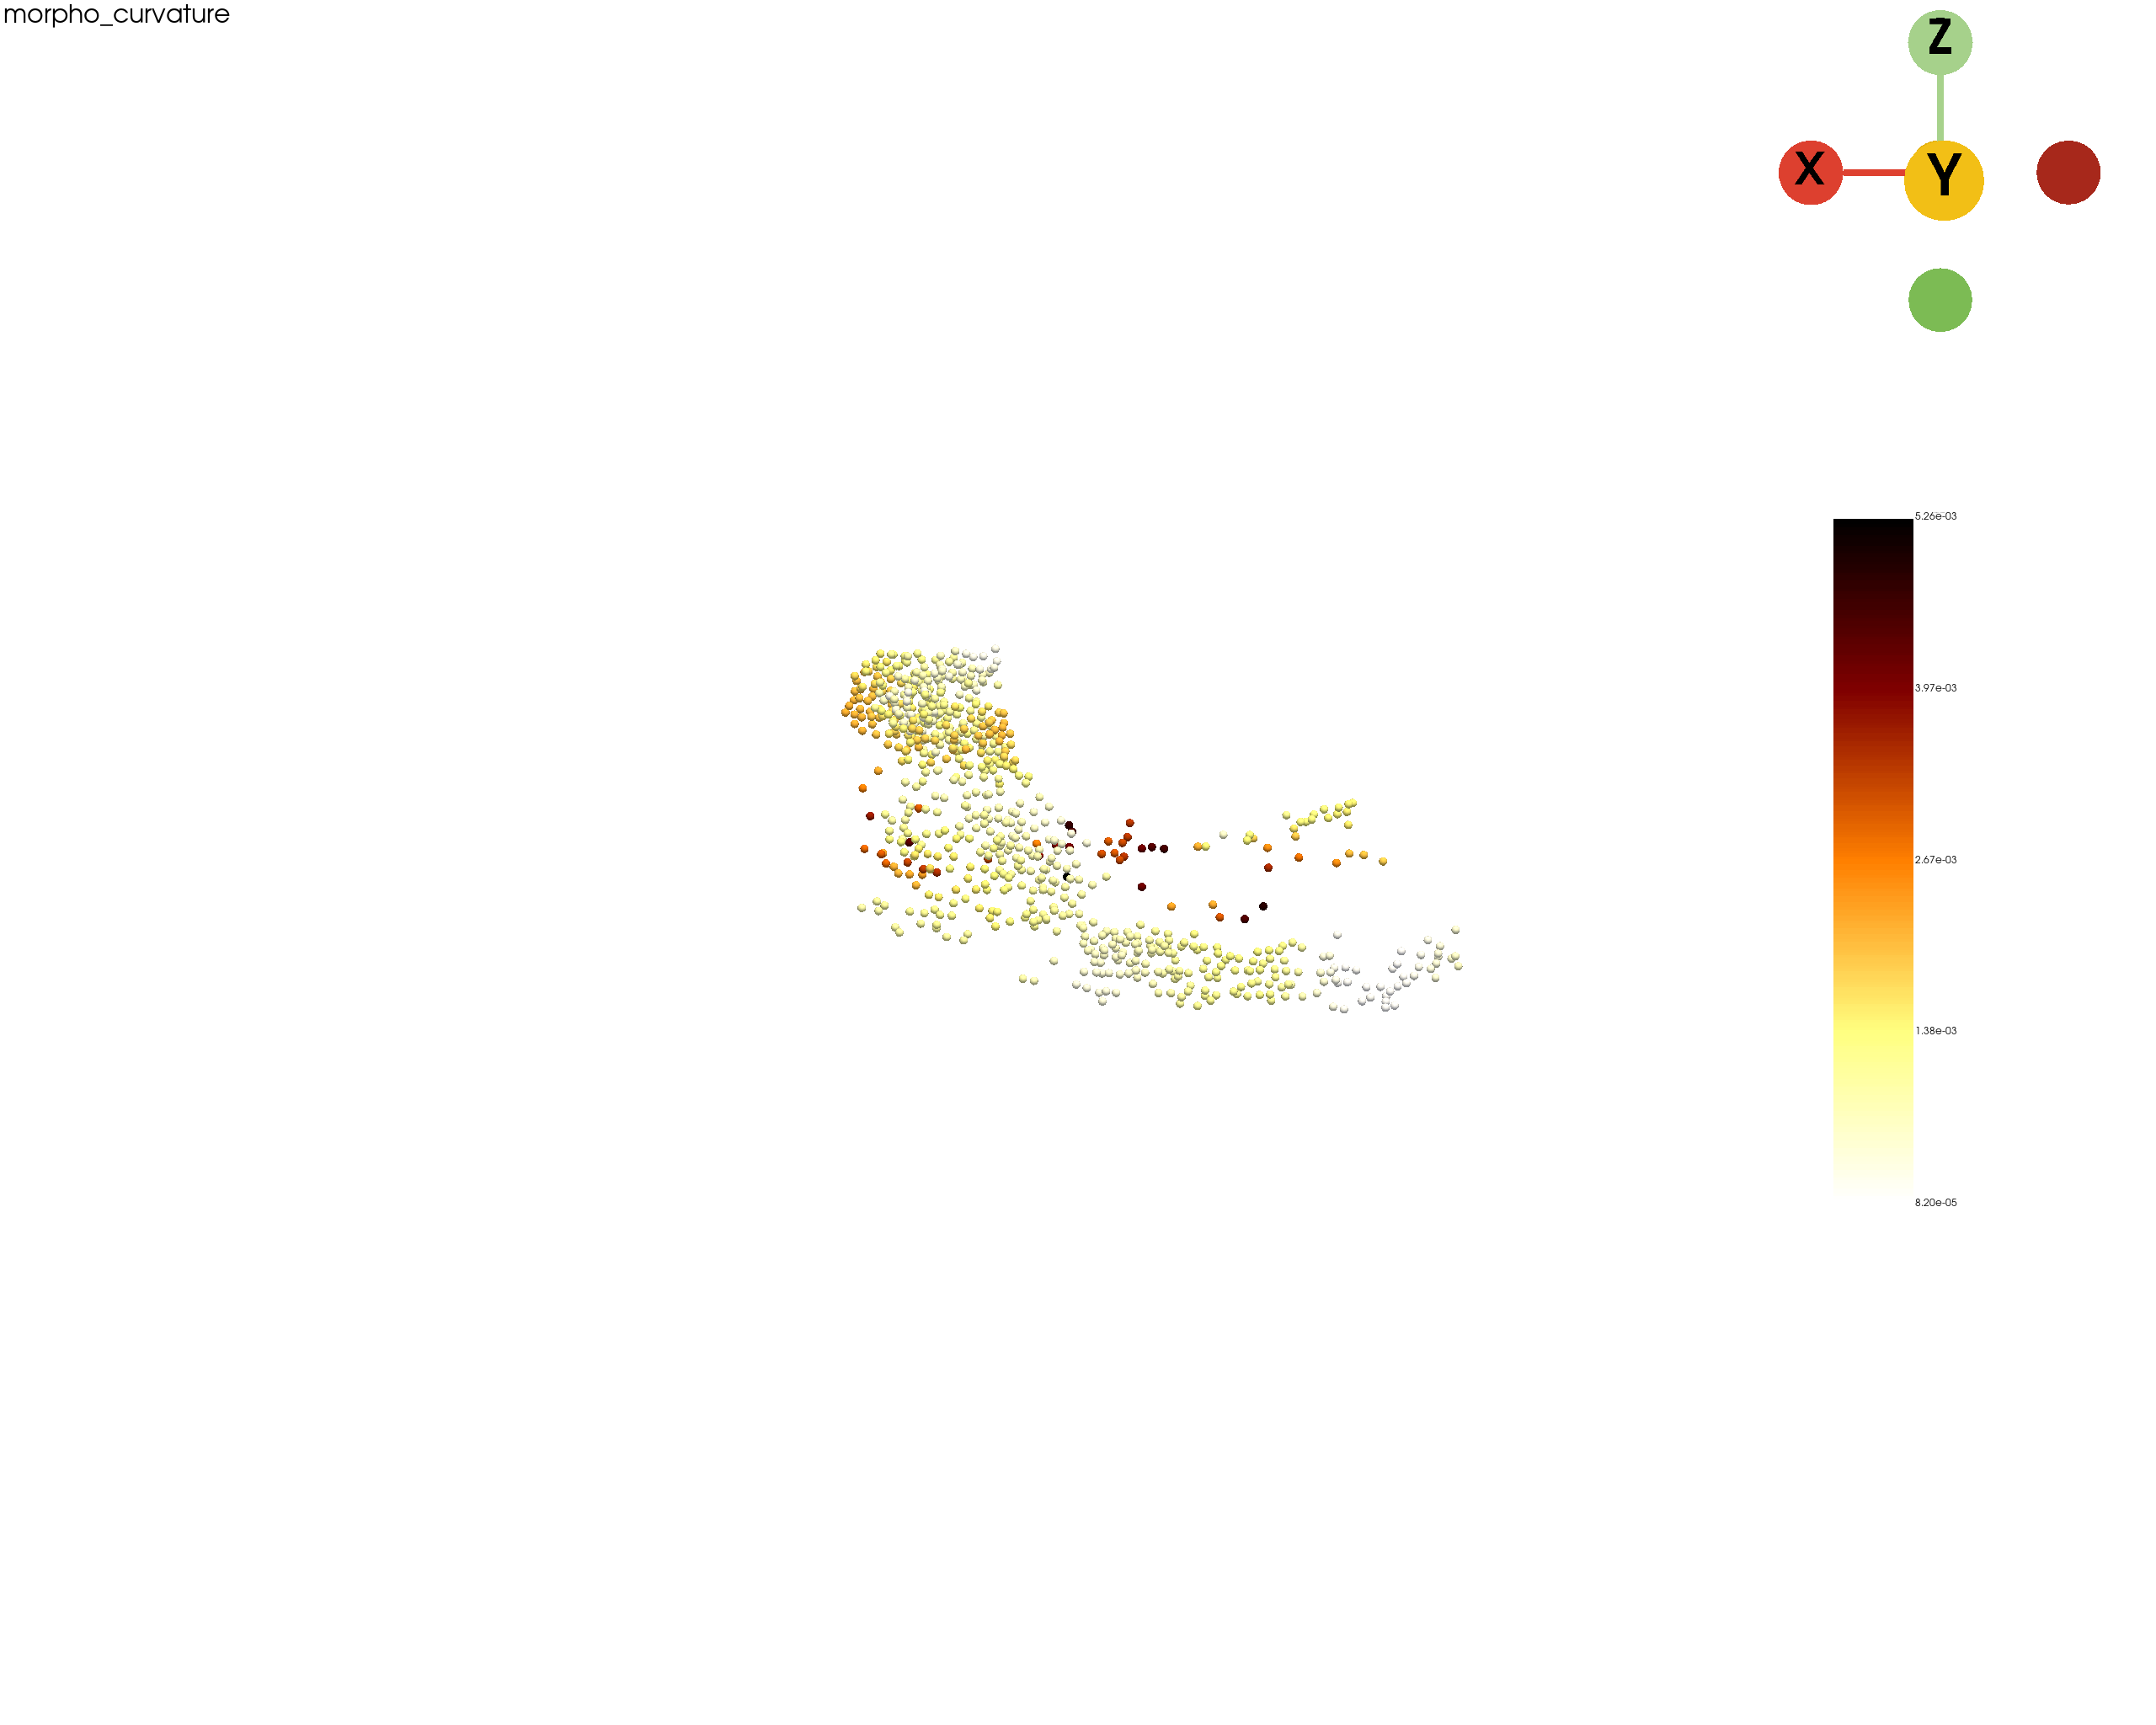

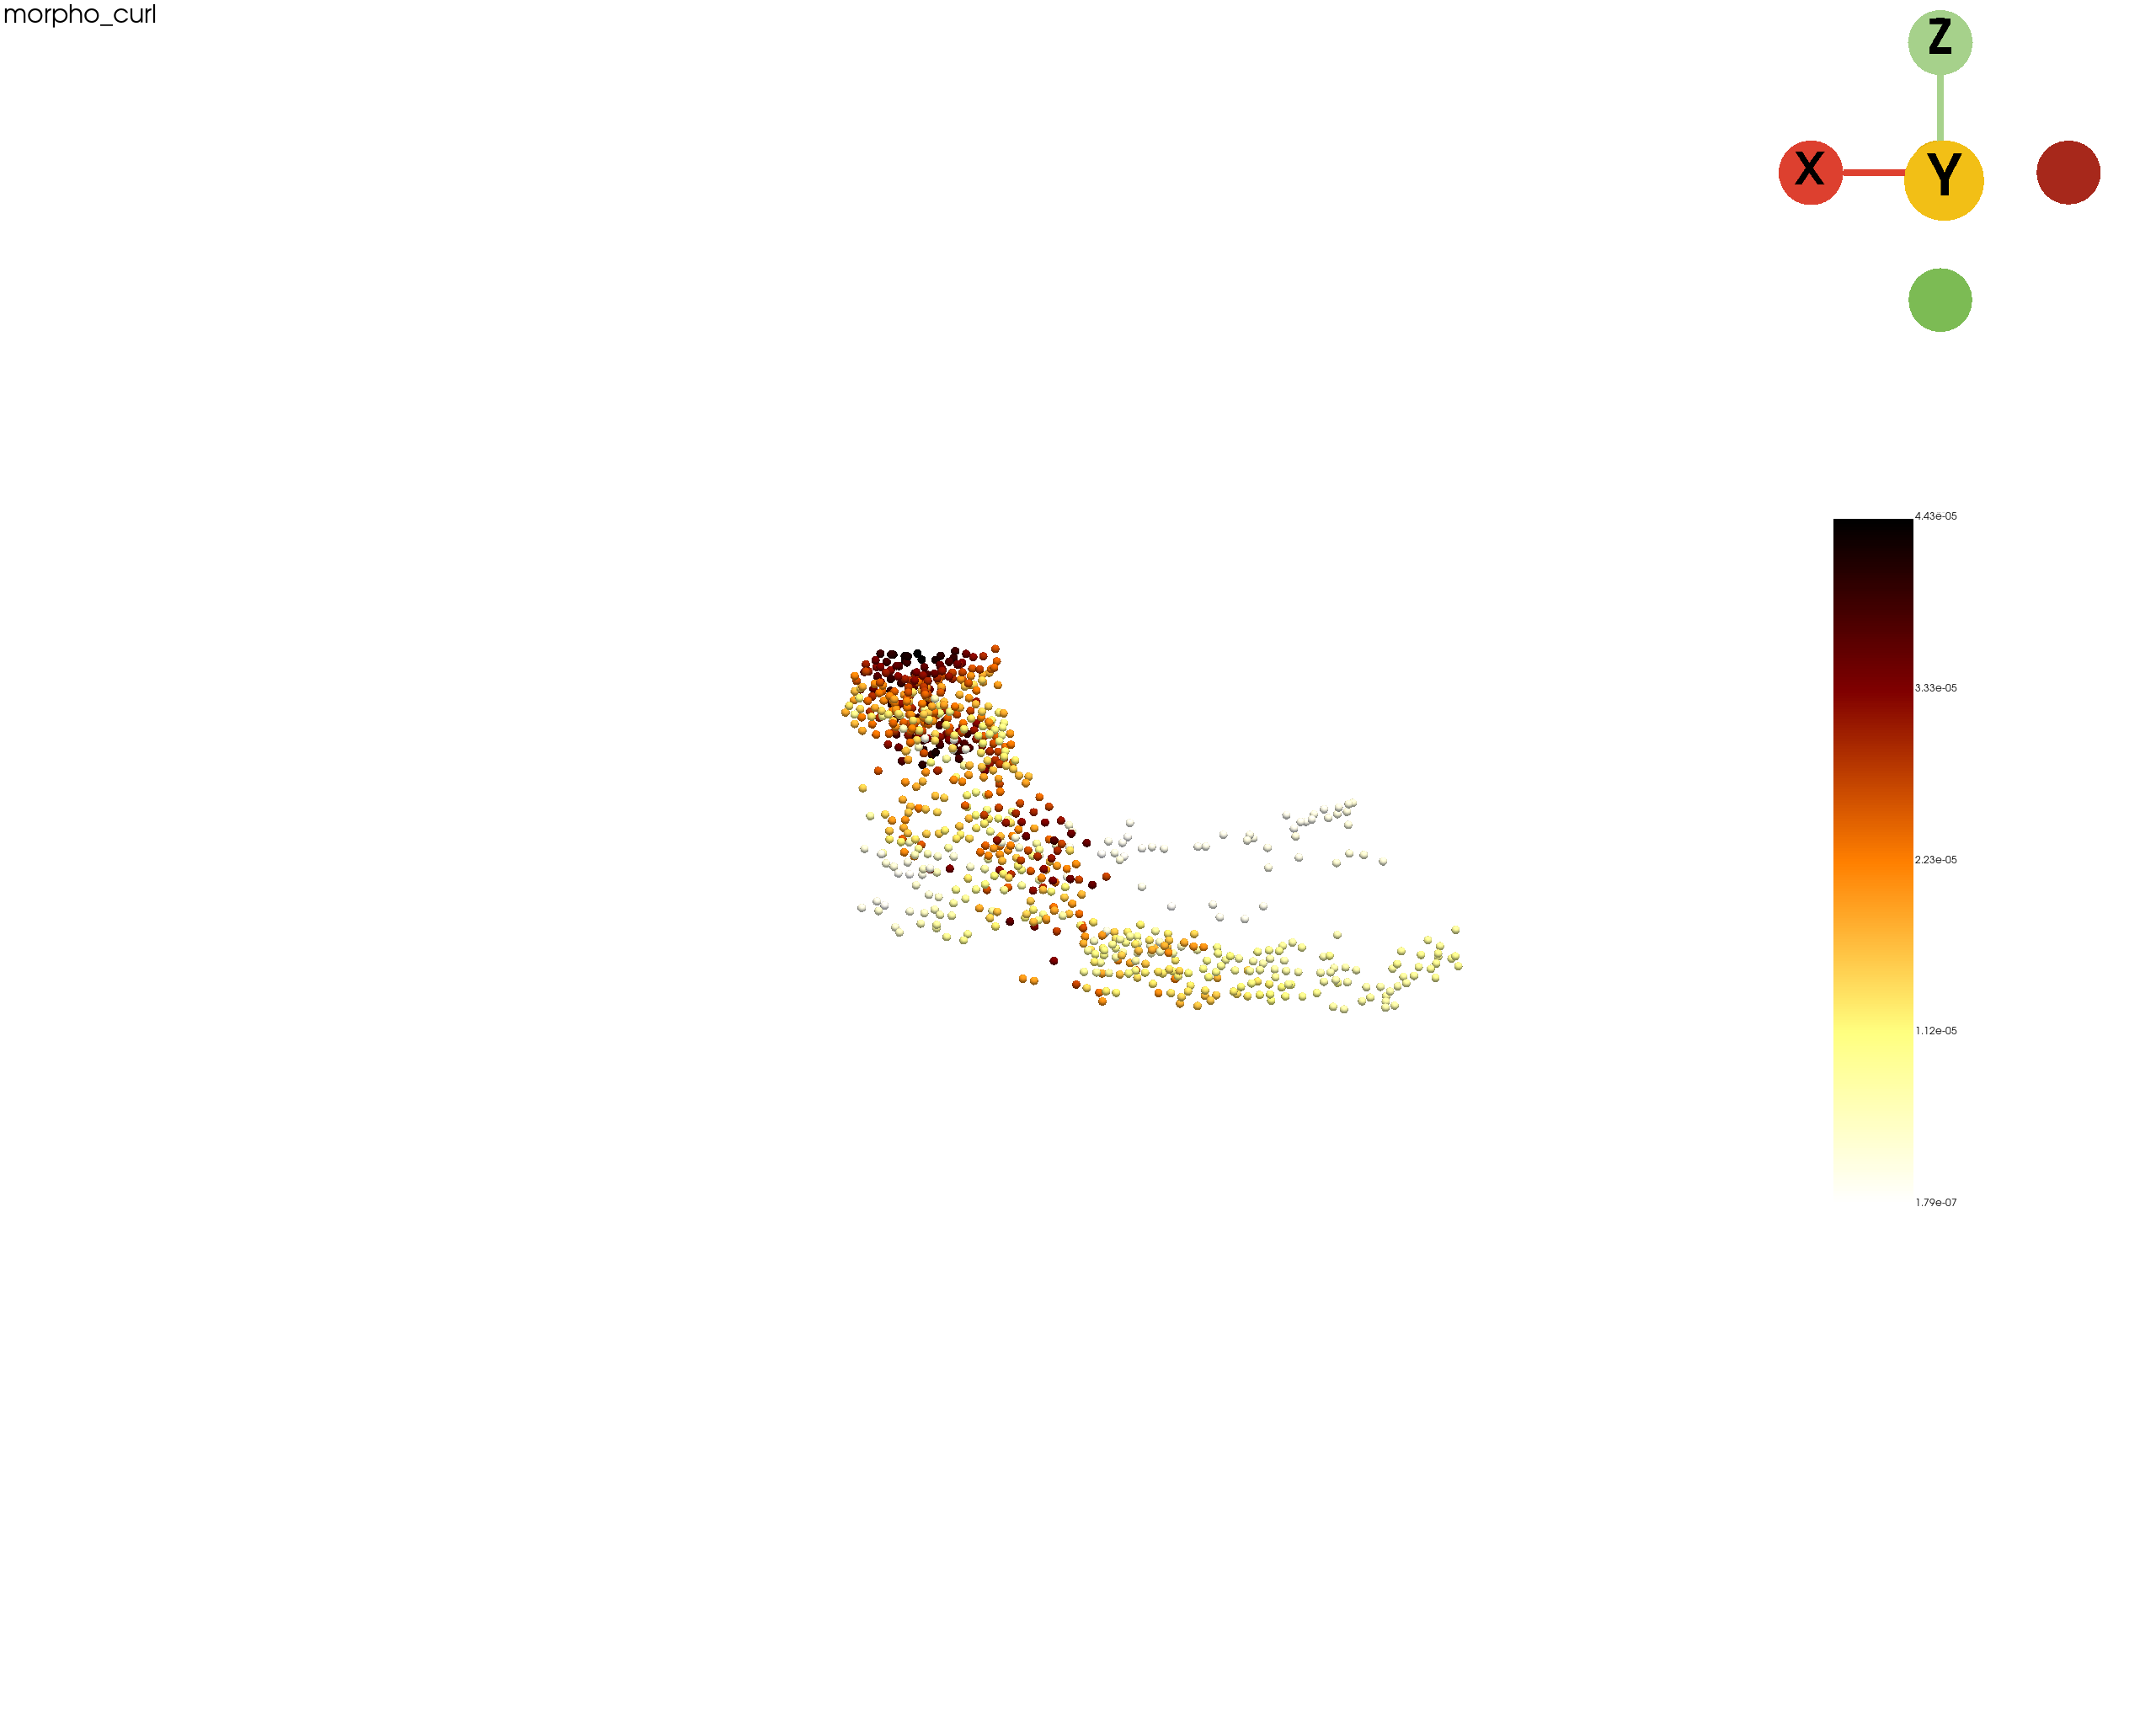

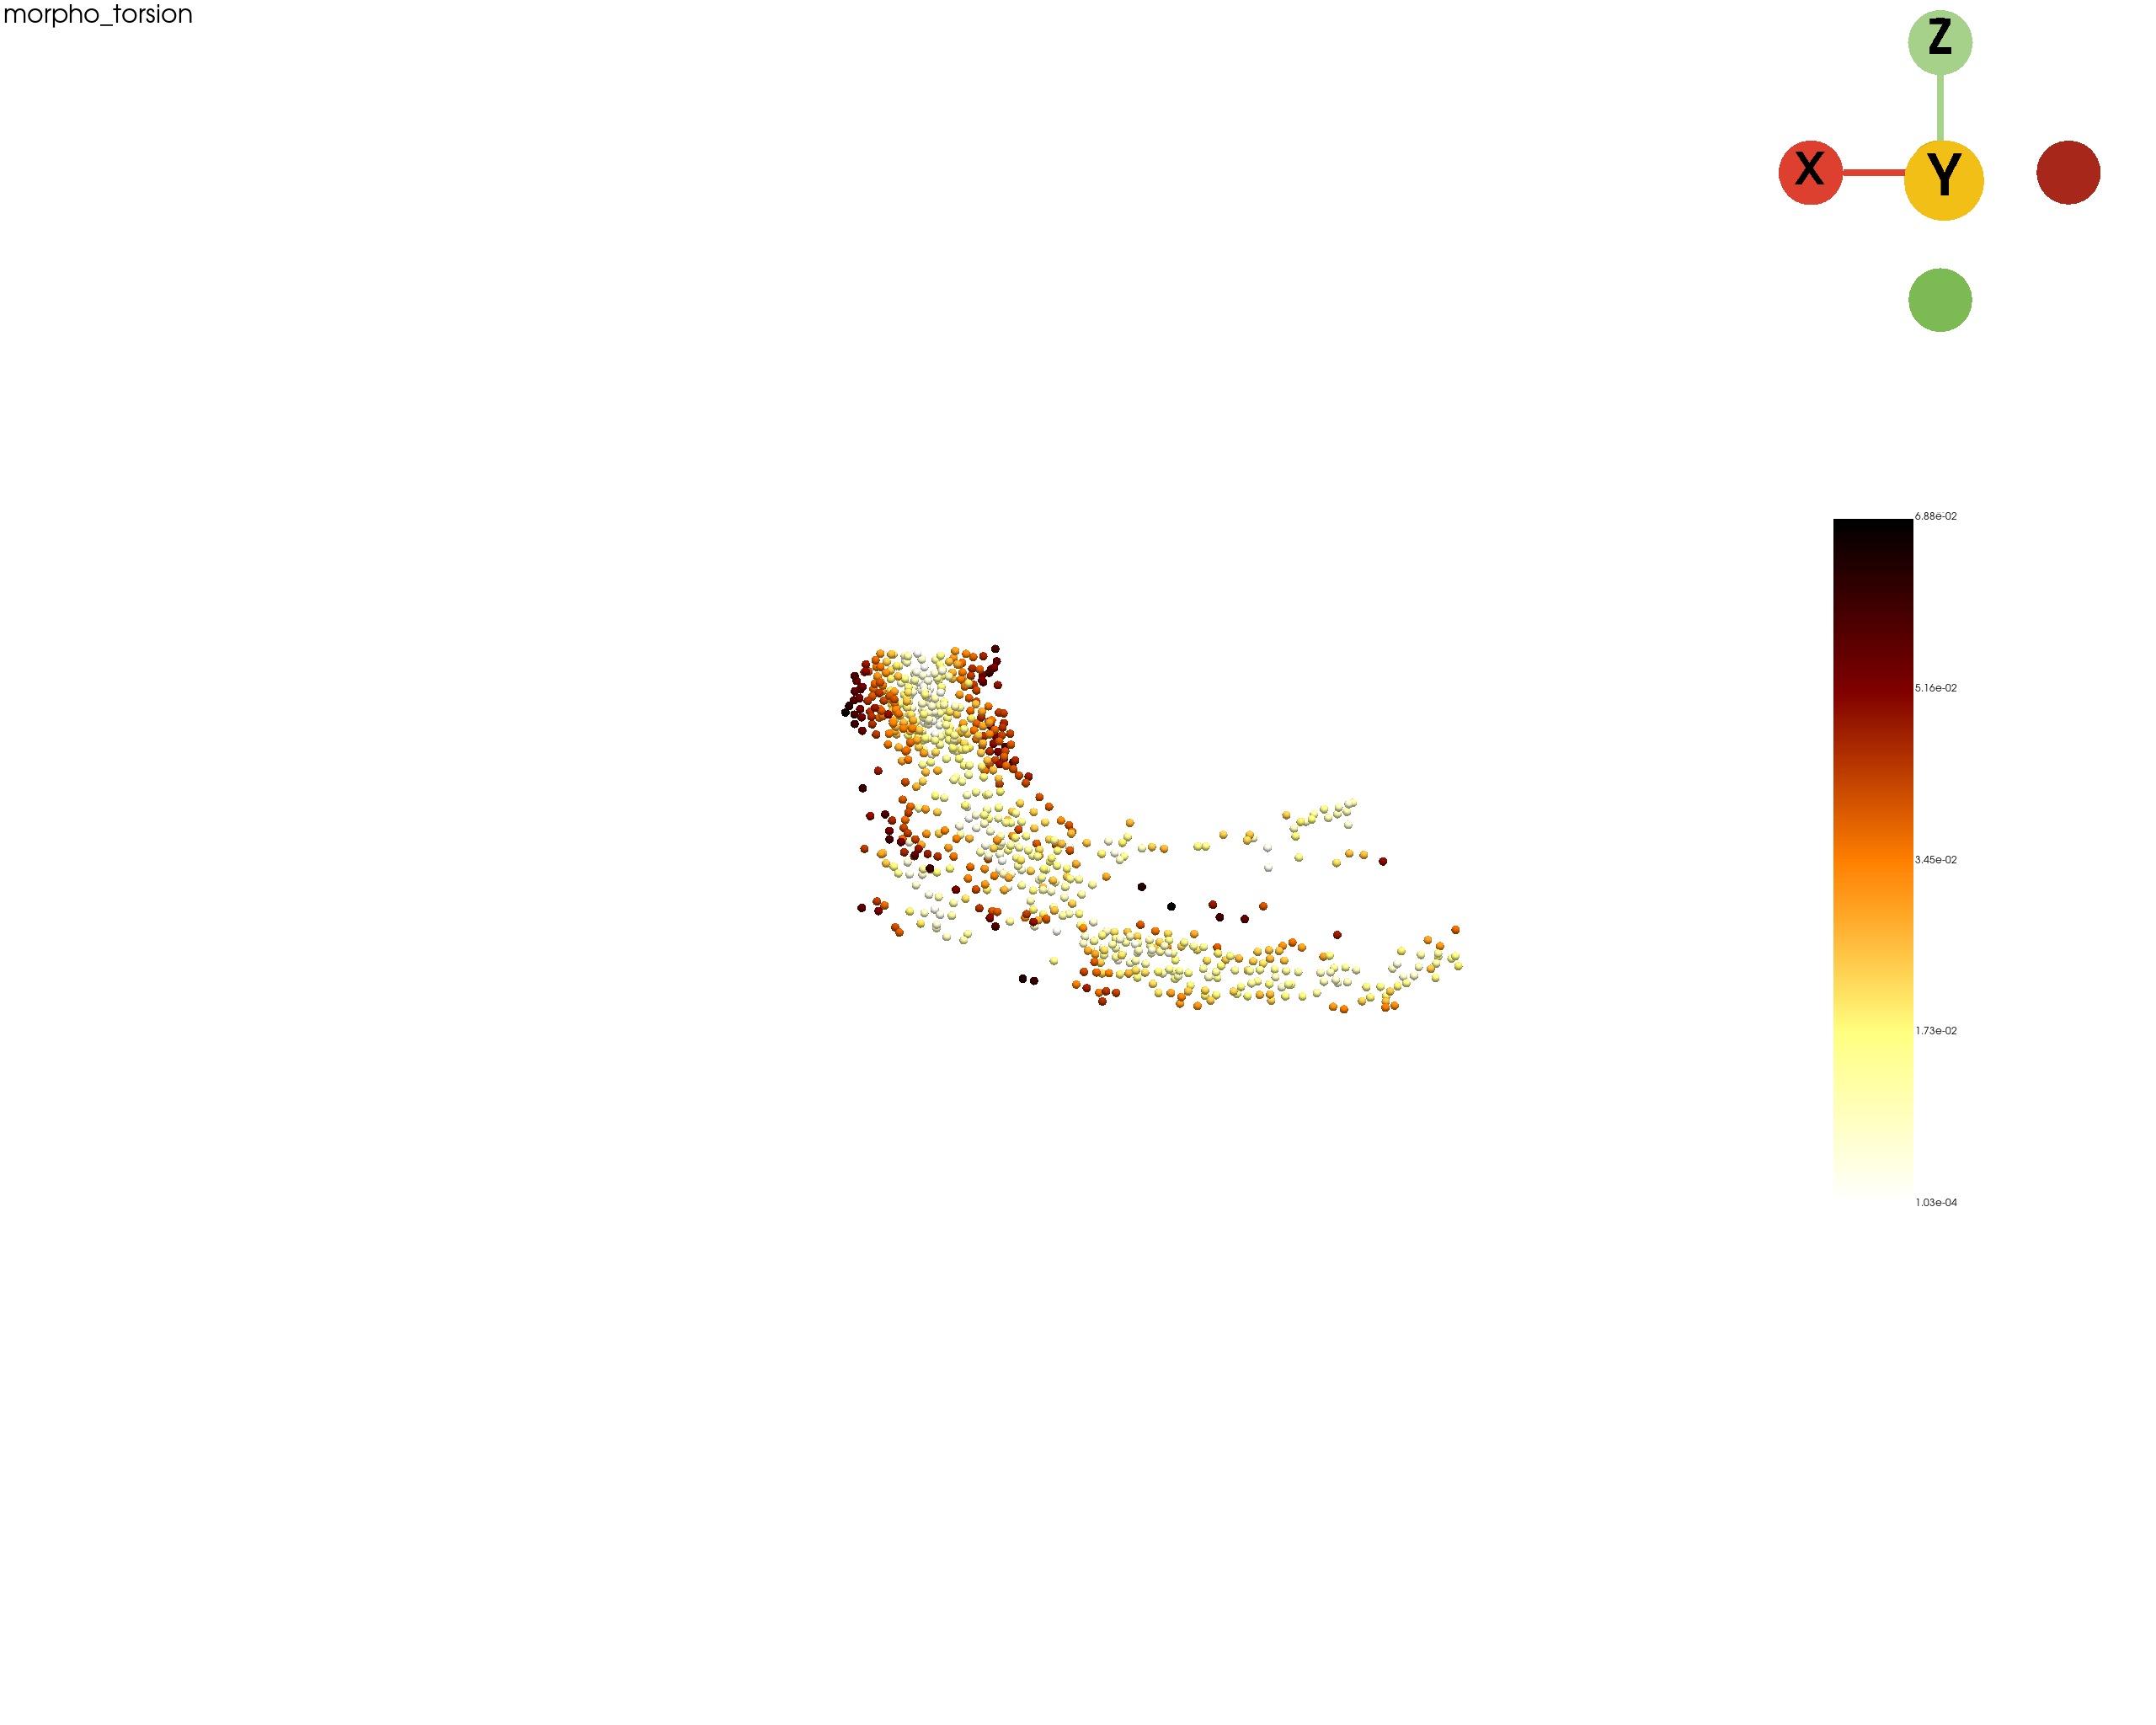

In [27]:
morphometrics_keys = ["morpho_acceleration", "morpho_curvature", "morpho_curl", "morpho_torsion"]
for mk in morphometrics_keys:
    pc_index=pc.point_data["obs_index"].tolist()
    mmvalue = adata[pc_index, :].obs[mk].values
    st.tdr.add_model_labels(model=pc, labels=mmvalue, key_added=mk, where="point_data",inplace=True, colormap="afmhot_r")
    
    st.pl.three_d_plot(
        model=pc,
        key=mk,
        model_style="points",
        model_size=10,
        opacity=1,
        colormap="afmhot_r", # Spectral_r
        show_legend=True,
        jupyter="static",
        background="white",
        cpo=cpo,
        window_size=(2560, 2048),
        text=mk,
        filename=os.path.join(out_image_path, f"amnioserosa_morphometrics_{mk}.pdf")
    )

|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


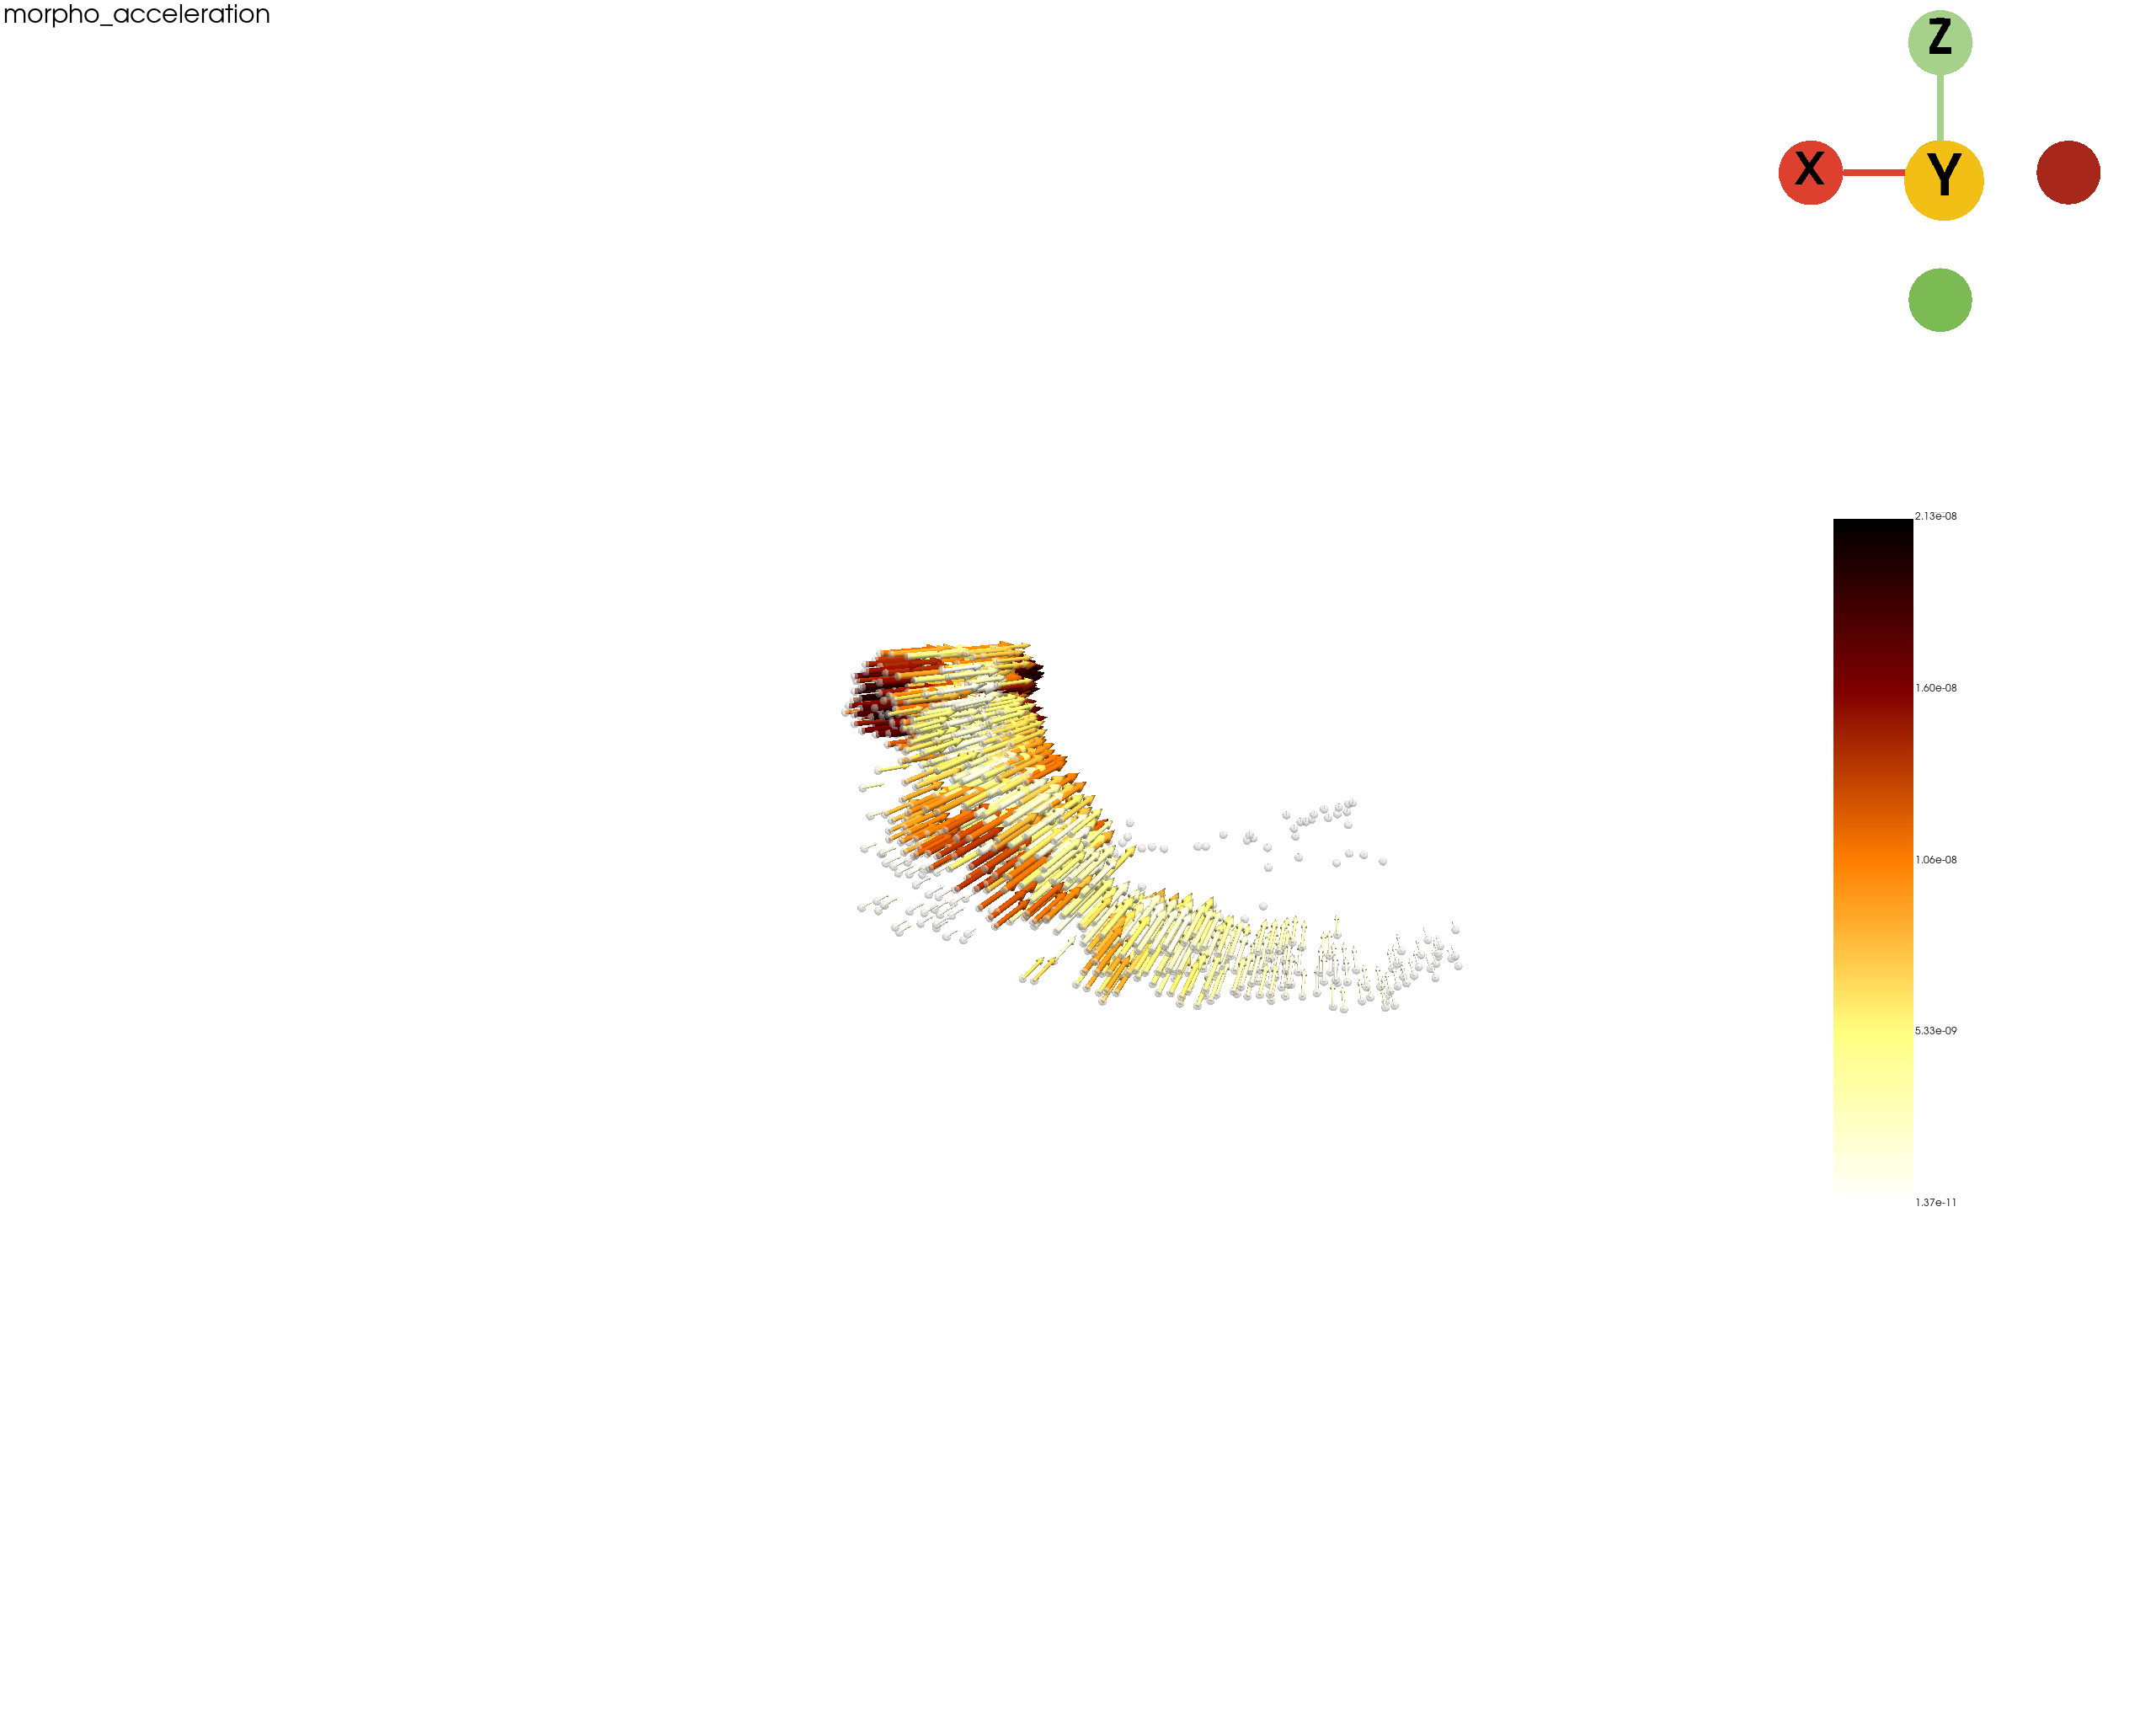

|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


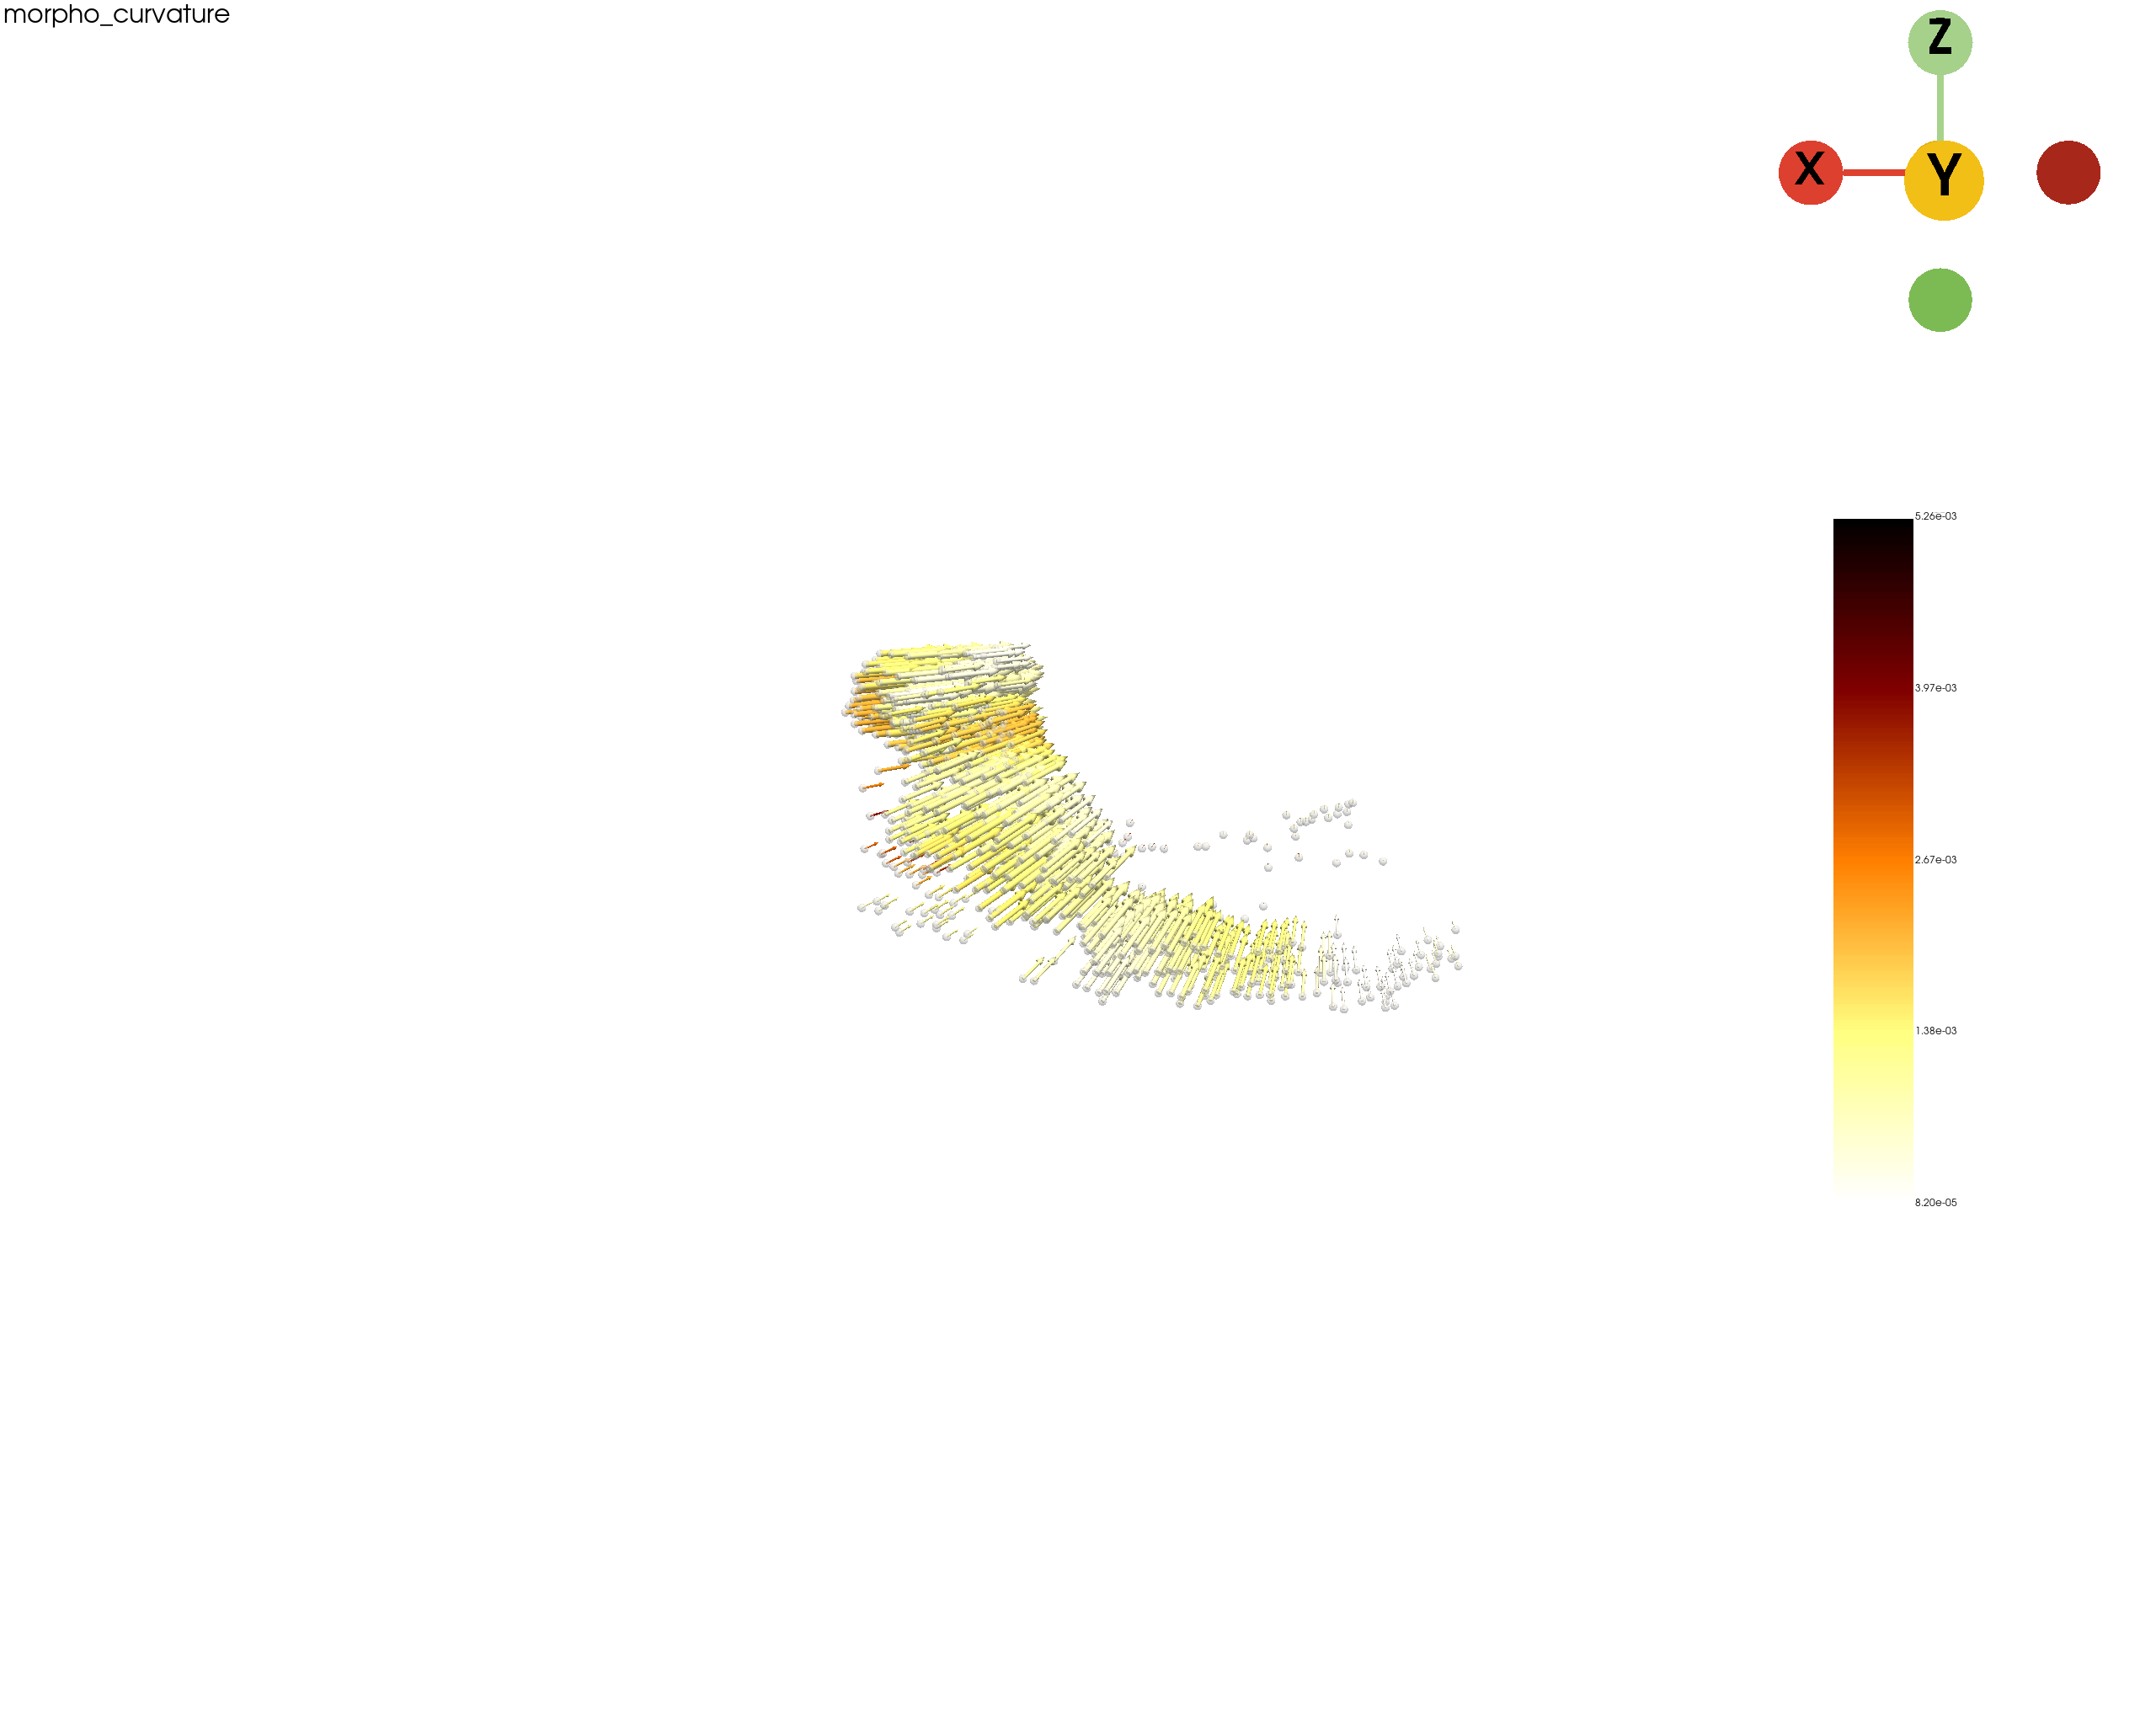

|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


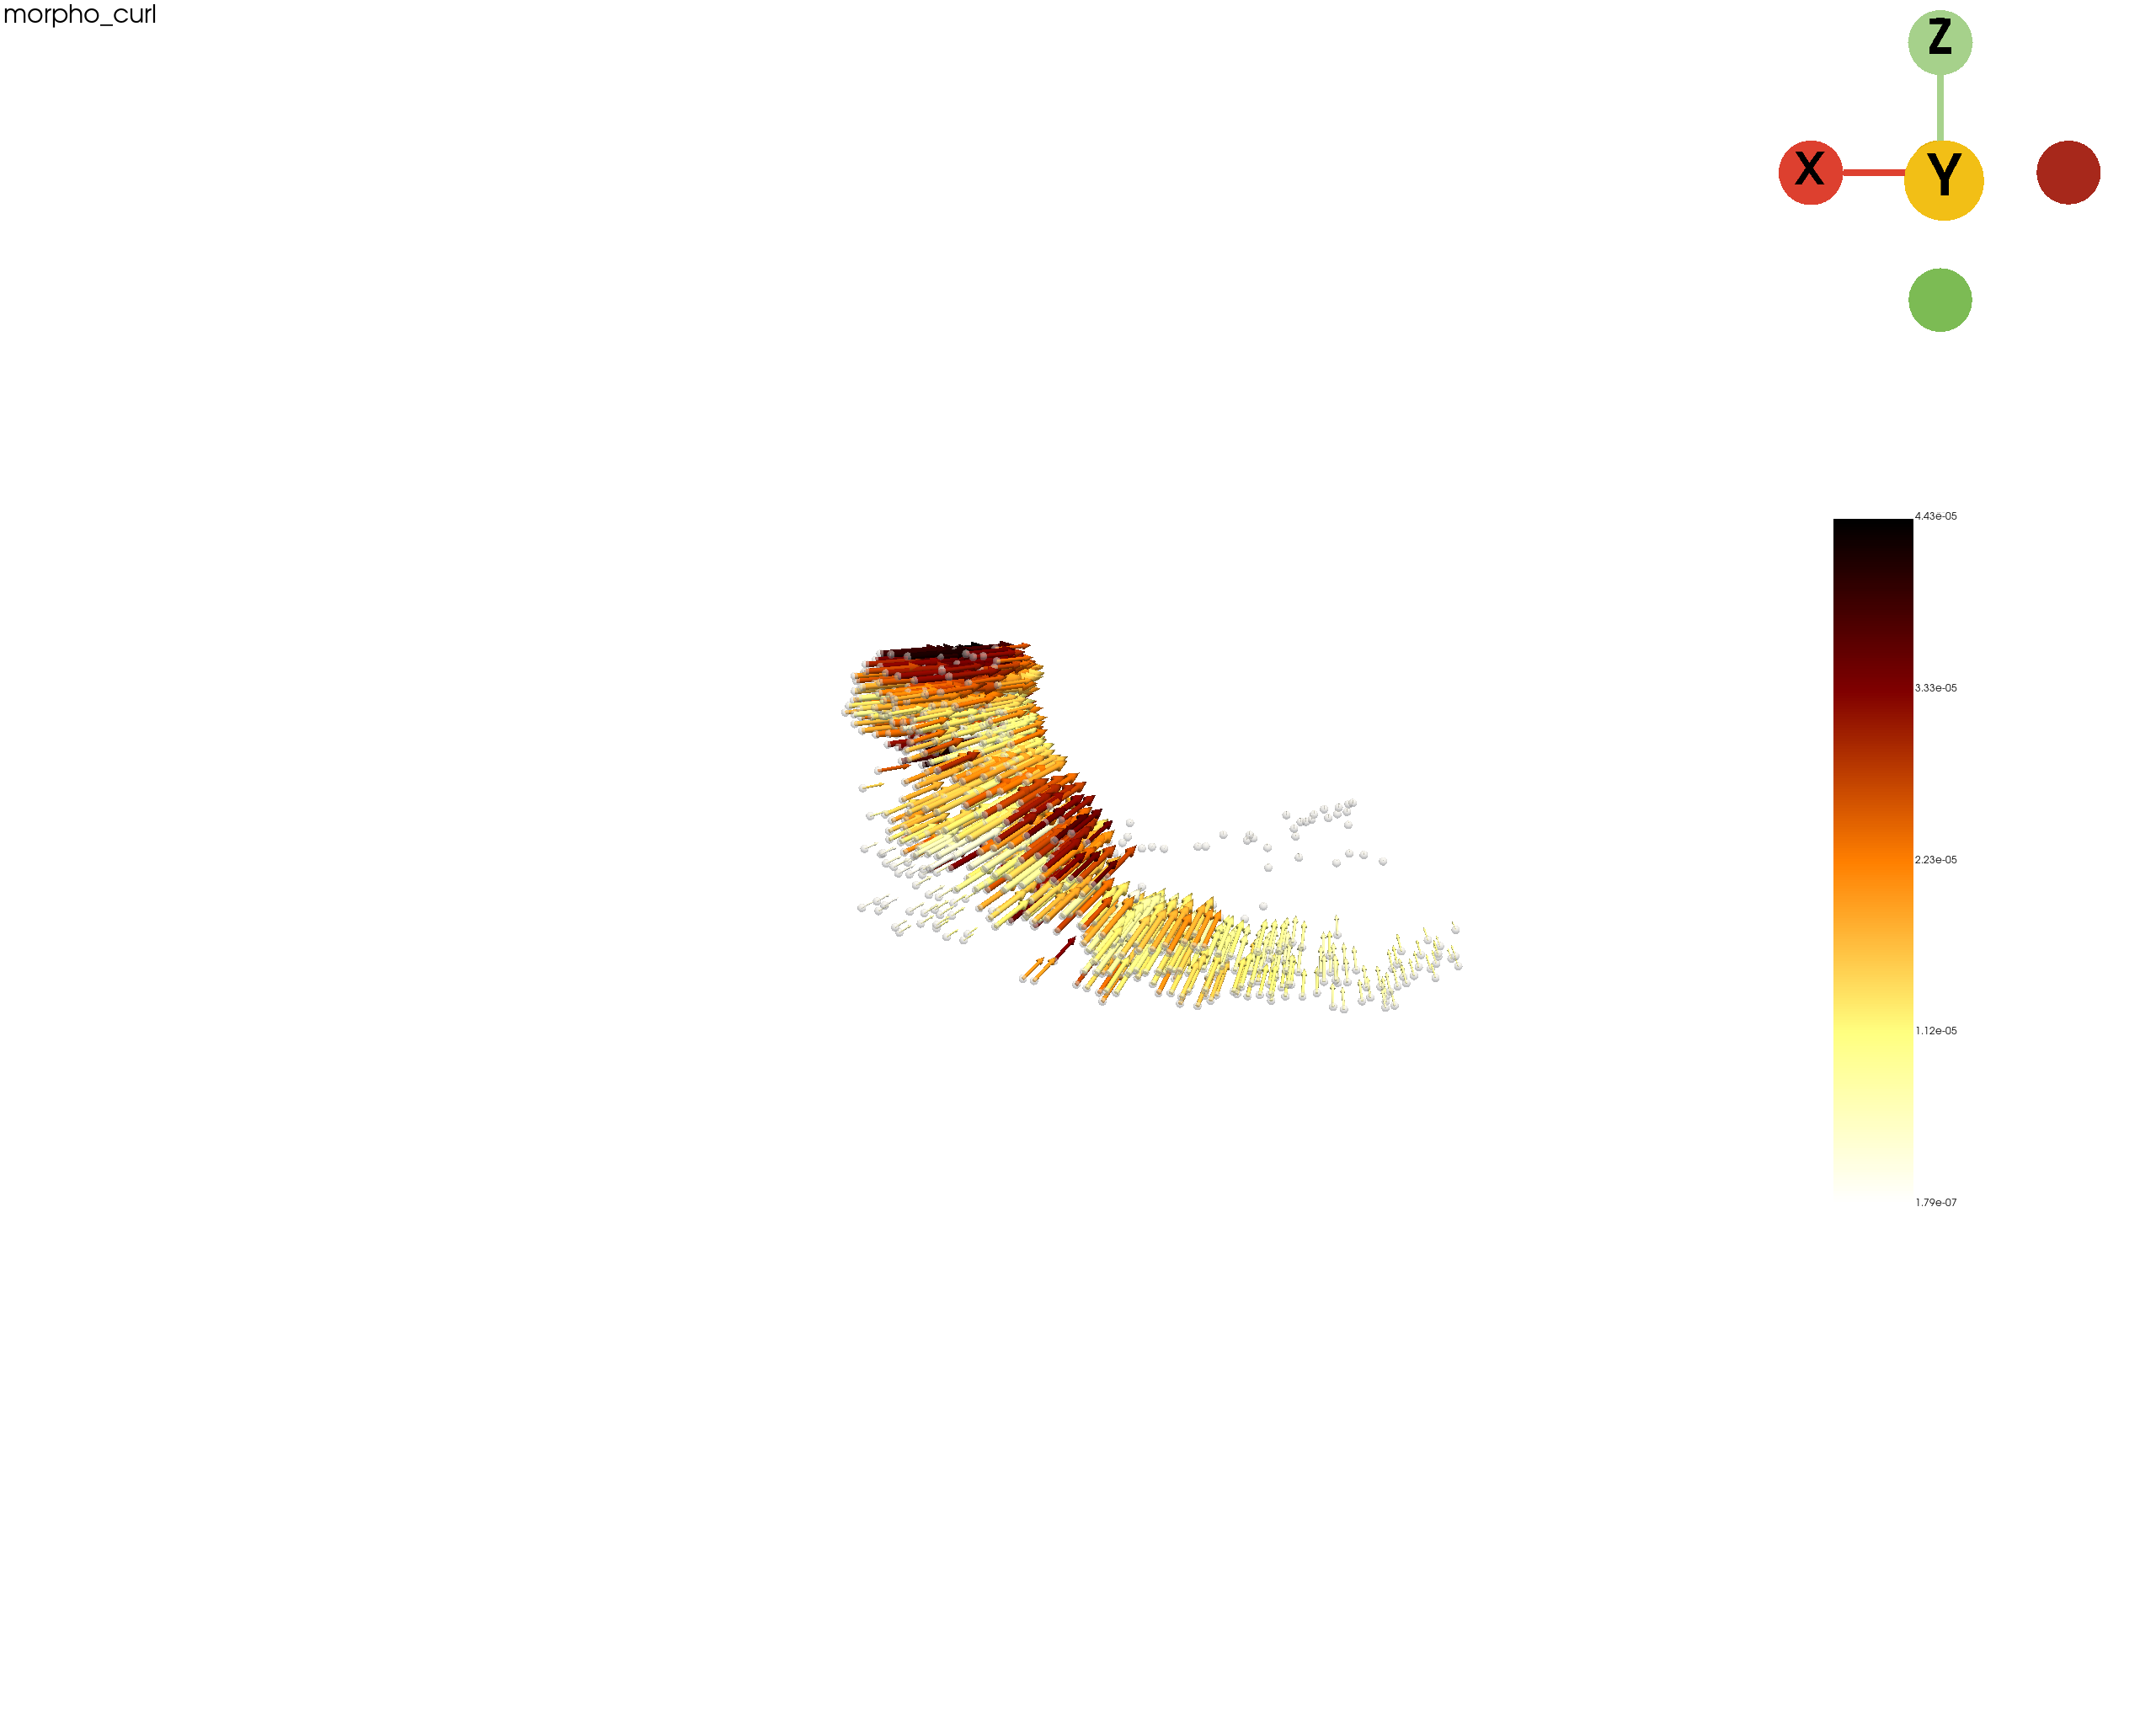

|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


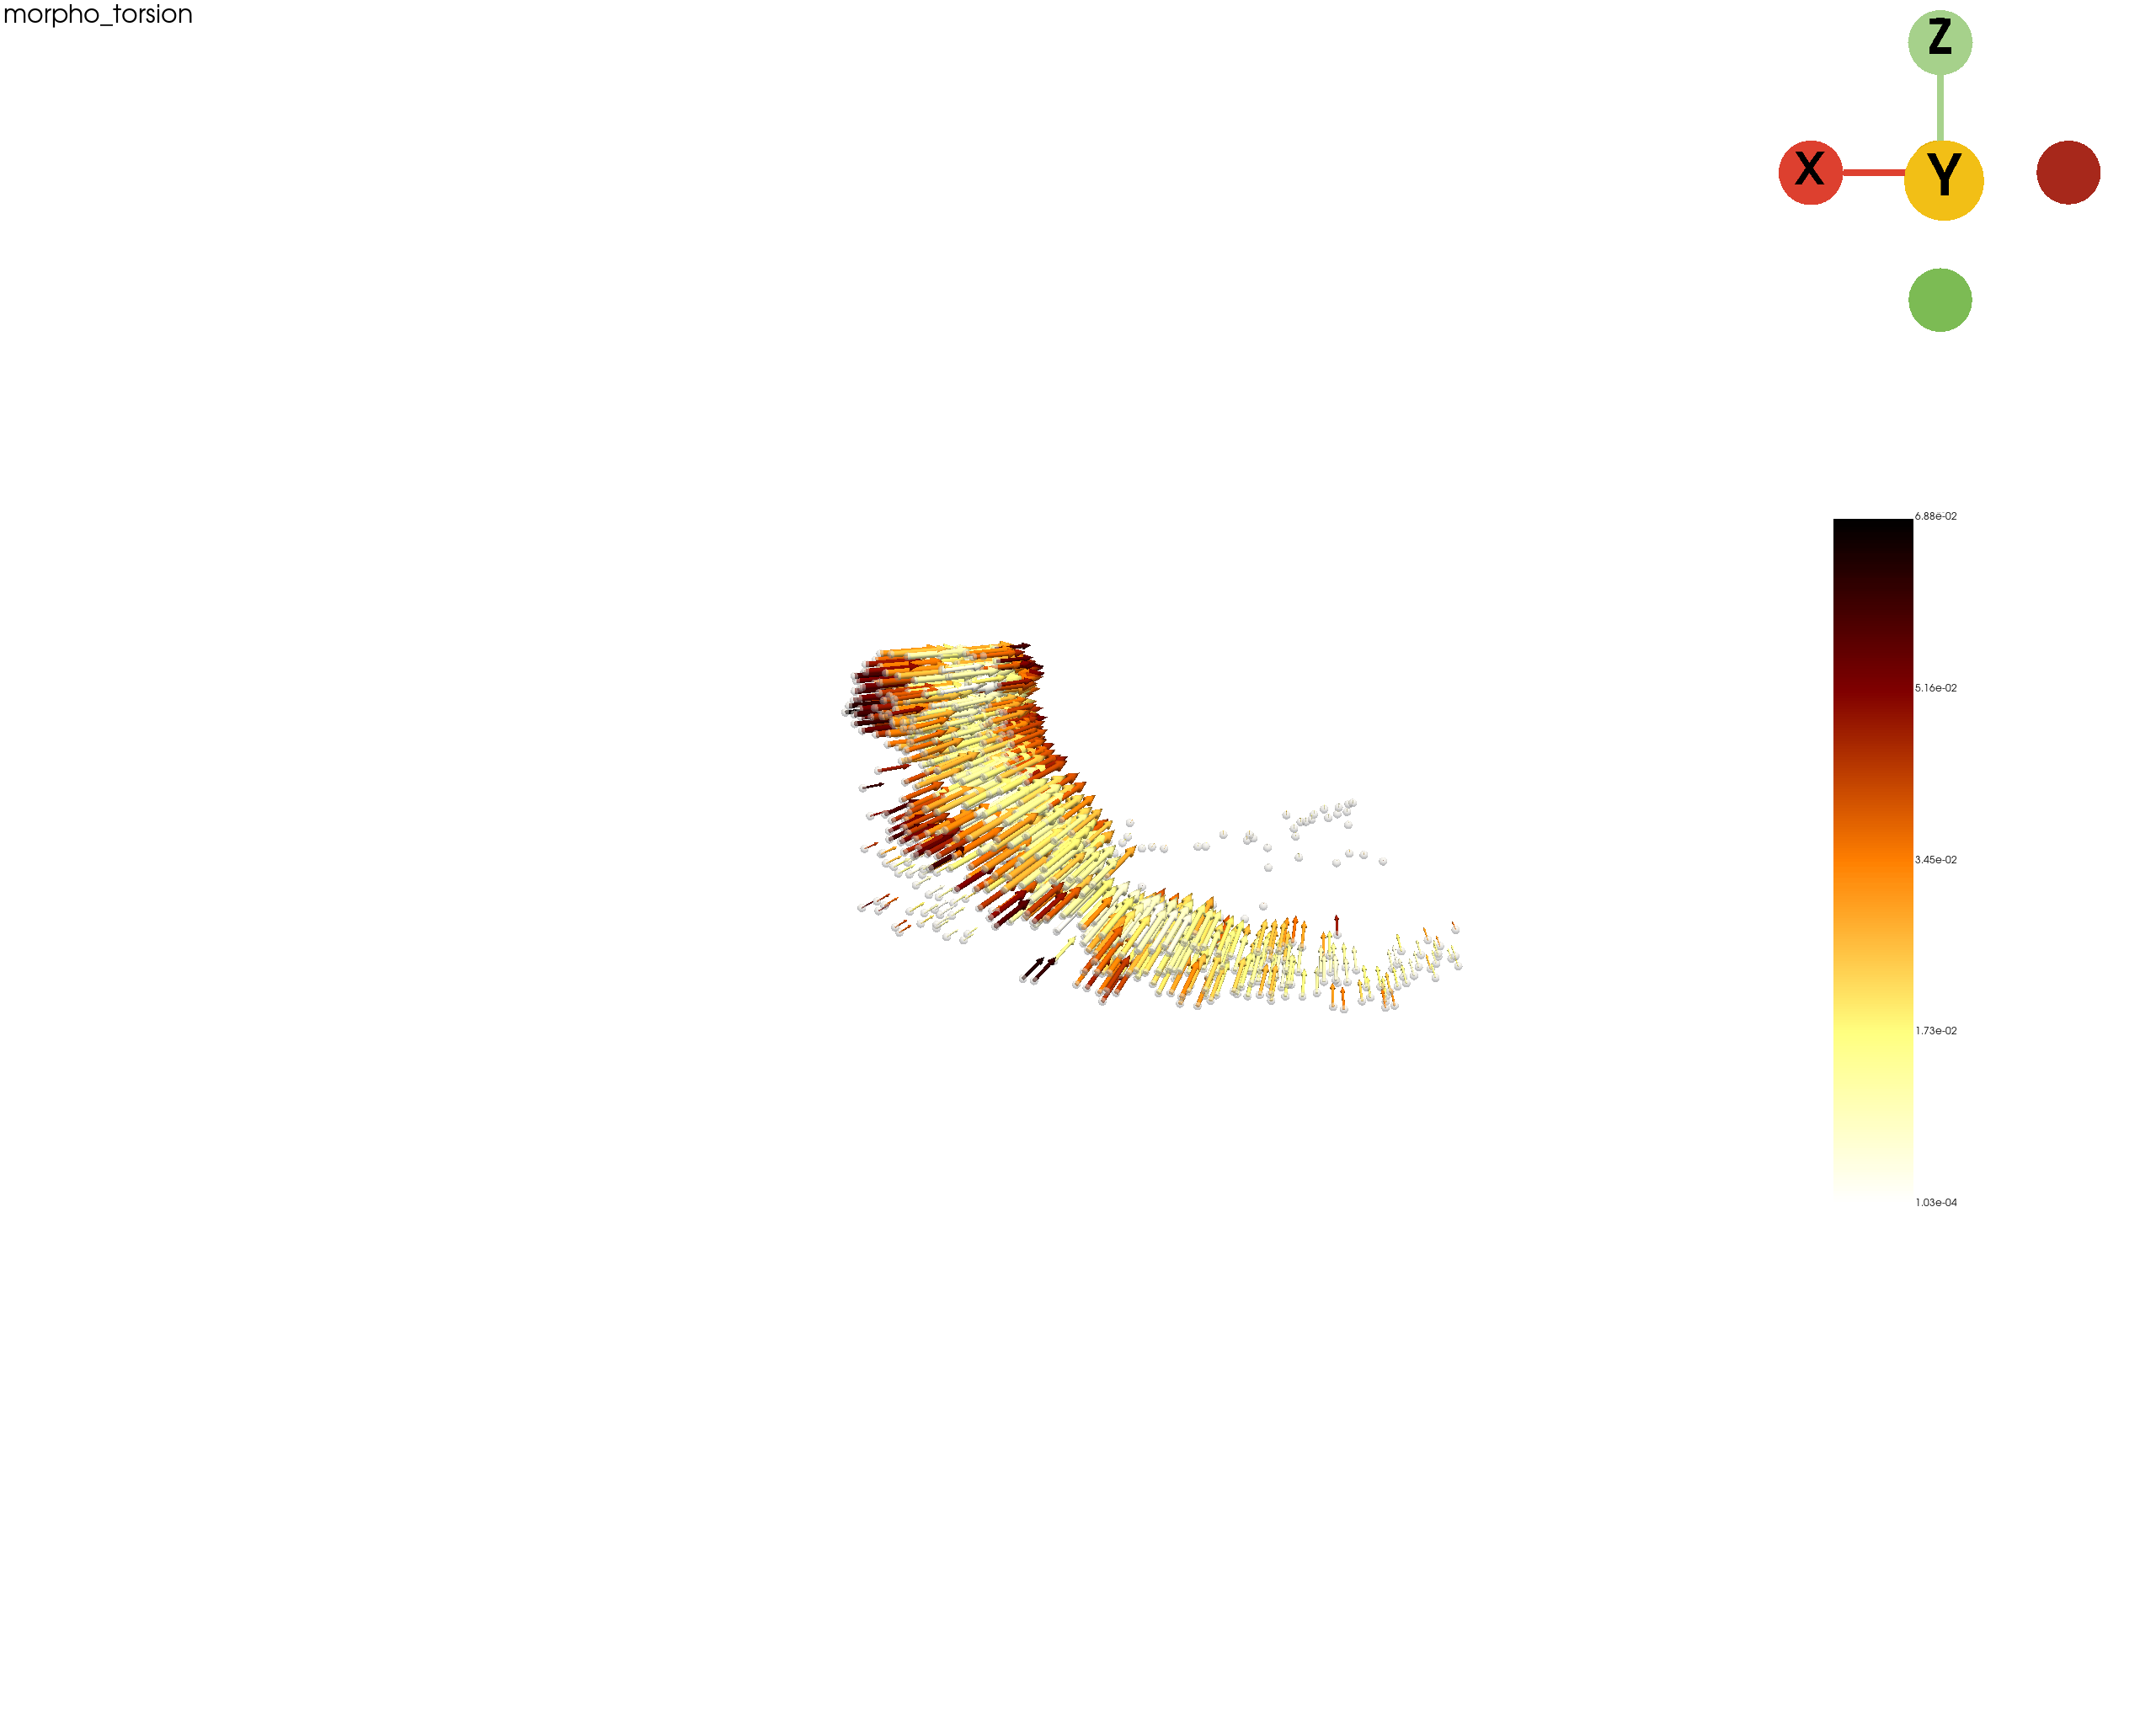

In [30]:
morphometrics_keys = ["morpho_acceleration", "morpho_curvature", "morpho_curl", "morpho_torsion"]
for mk in morphometrics_keys:
    vector_arrows,_ = st.tdr.construct_field(
        model=pc,
        vf_key="vectors",
        arrows_scale_key="vectors",
        n_sampling=None,
        factor=30000,
        key_added=mk,
        label=np.asarray(adata[np.asarray(pc.point_data["obs_index"])].obs[mk]),
        color="afmhot_r",
    )
    st.pl.three_d_plot(
        model=st.tdr.collect_models([pc, vector_arrows]),
        key=["tissue", mk],
        model_style=["points", "surface"],
        model_size=[10, 5],
        opacity=[0.5, 1],
        colormap=["gainsboro", "afmhot_r"],
        show_legend=True,
        jupyter="static",
        background="white",
        cpo=cpo,
        window_size=(2560, 2048),
        text=mk,
        filename=os.path.join(out_image_path, f"amnioserosa_morphometrics_{mk}_arrows.pdf")
    )

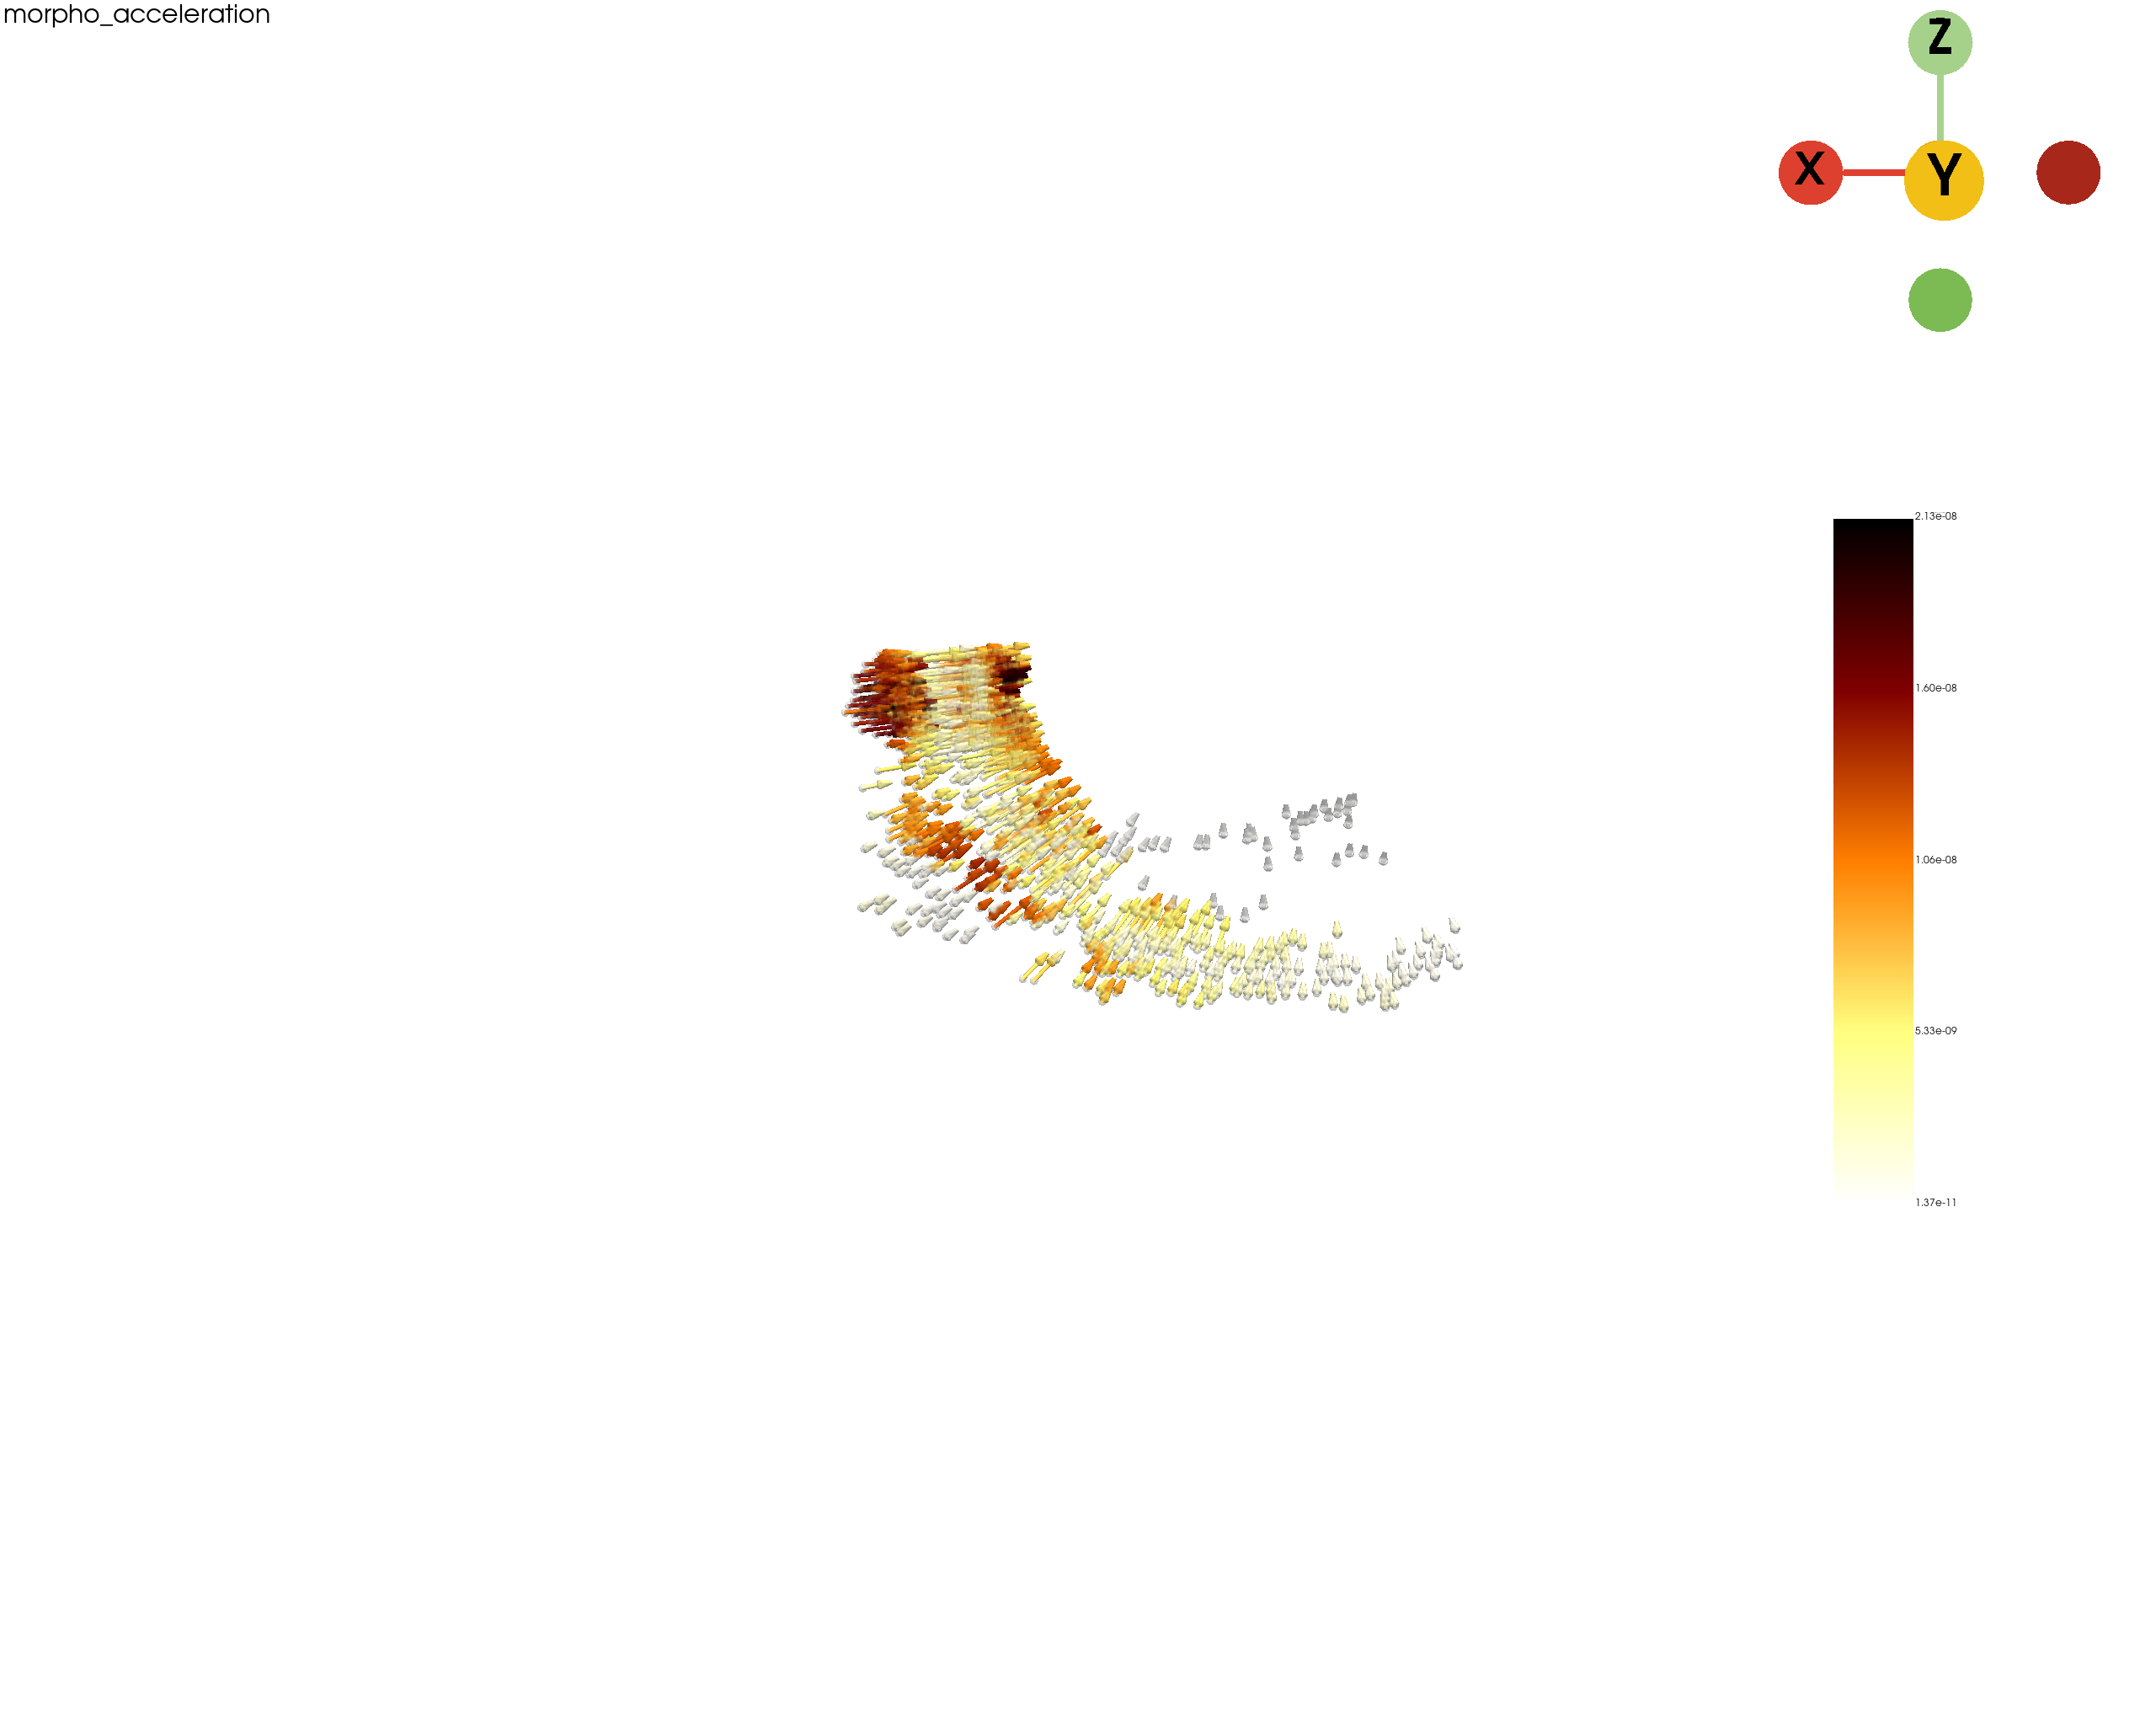

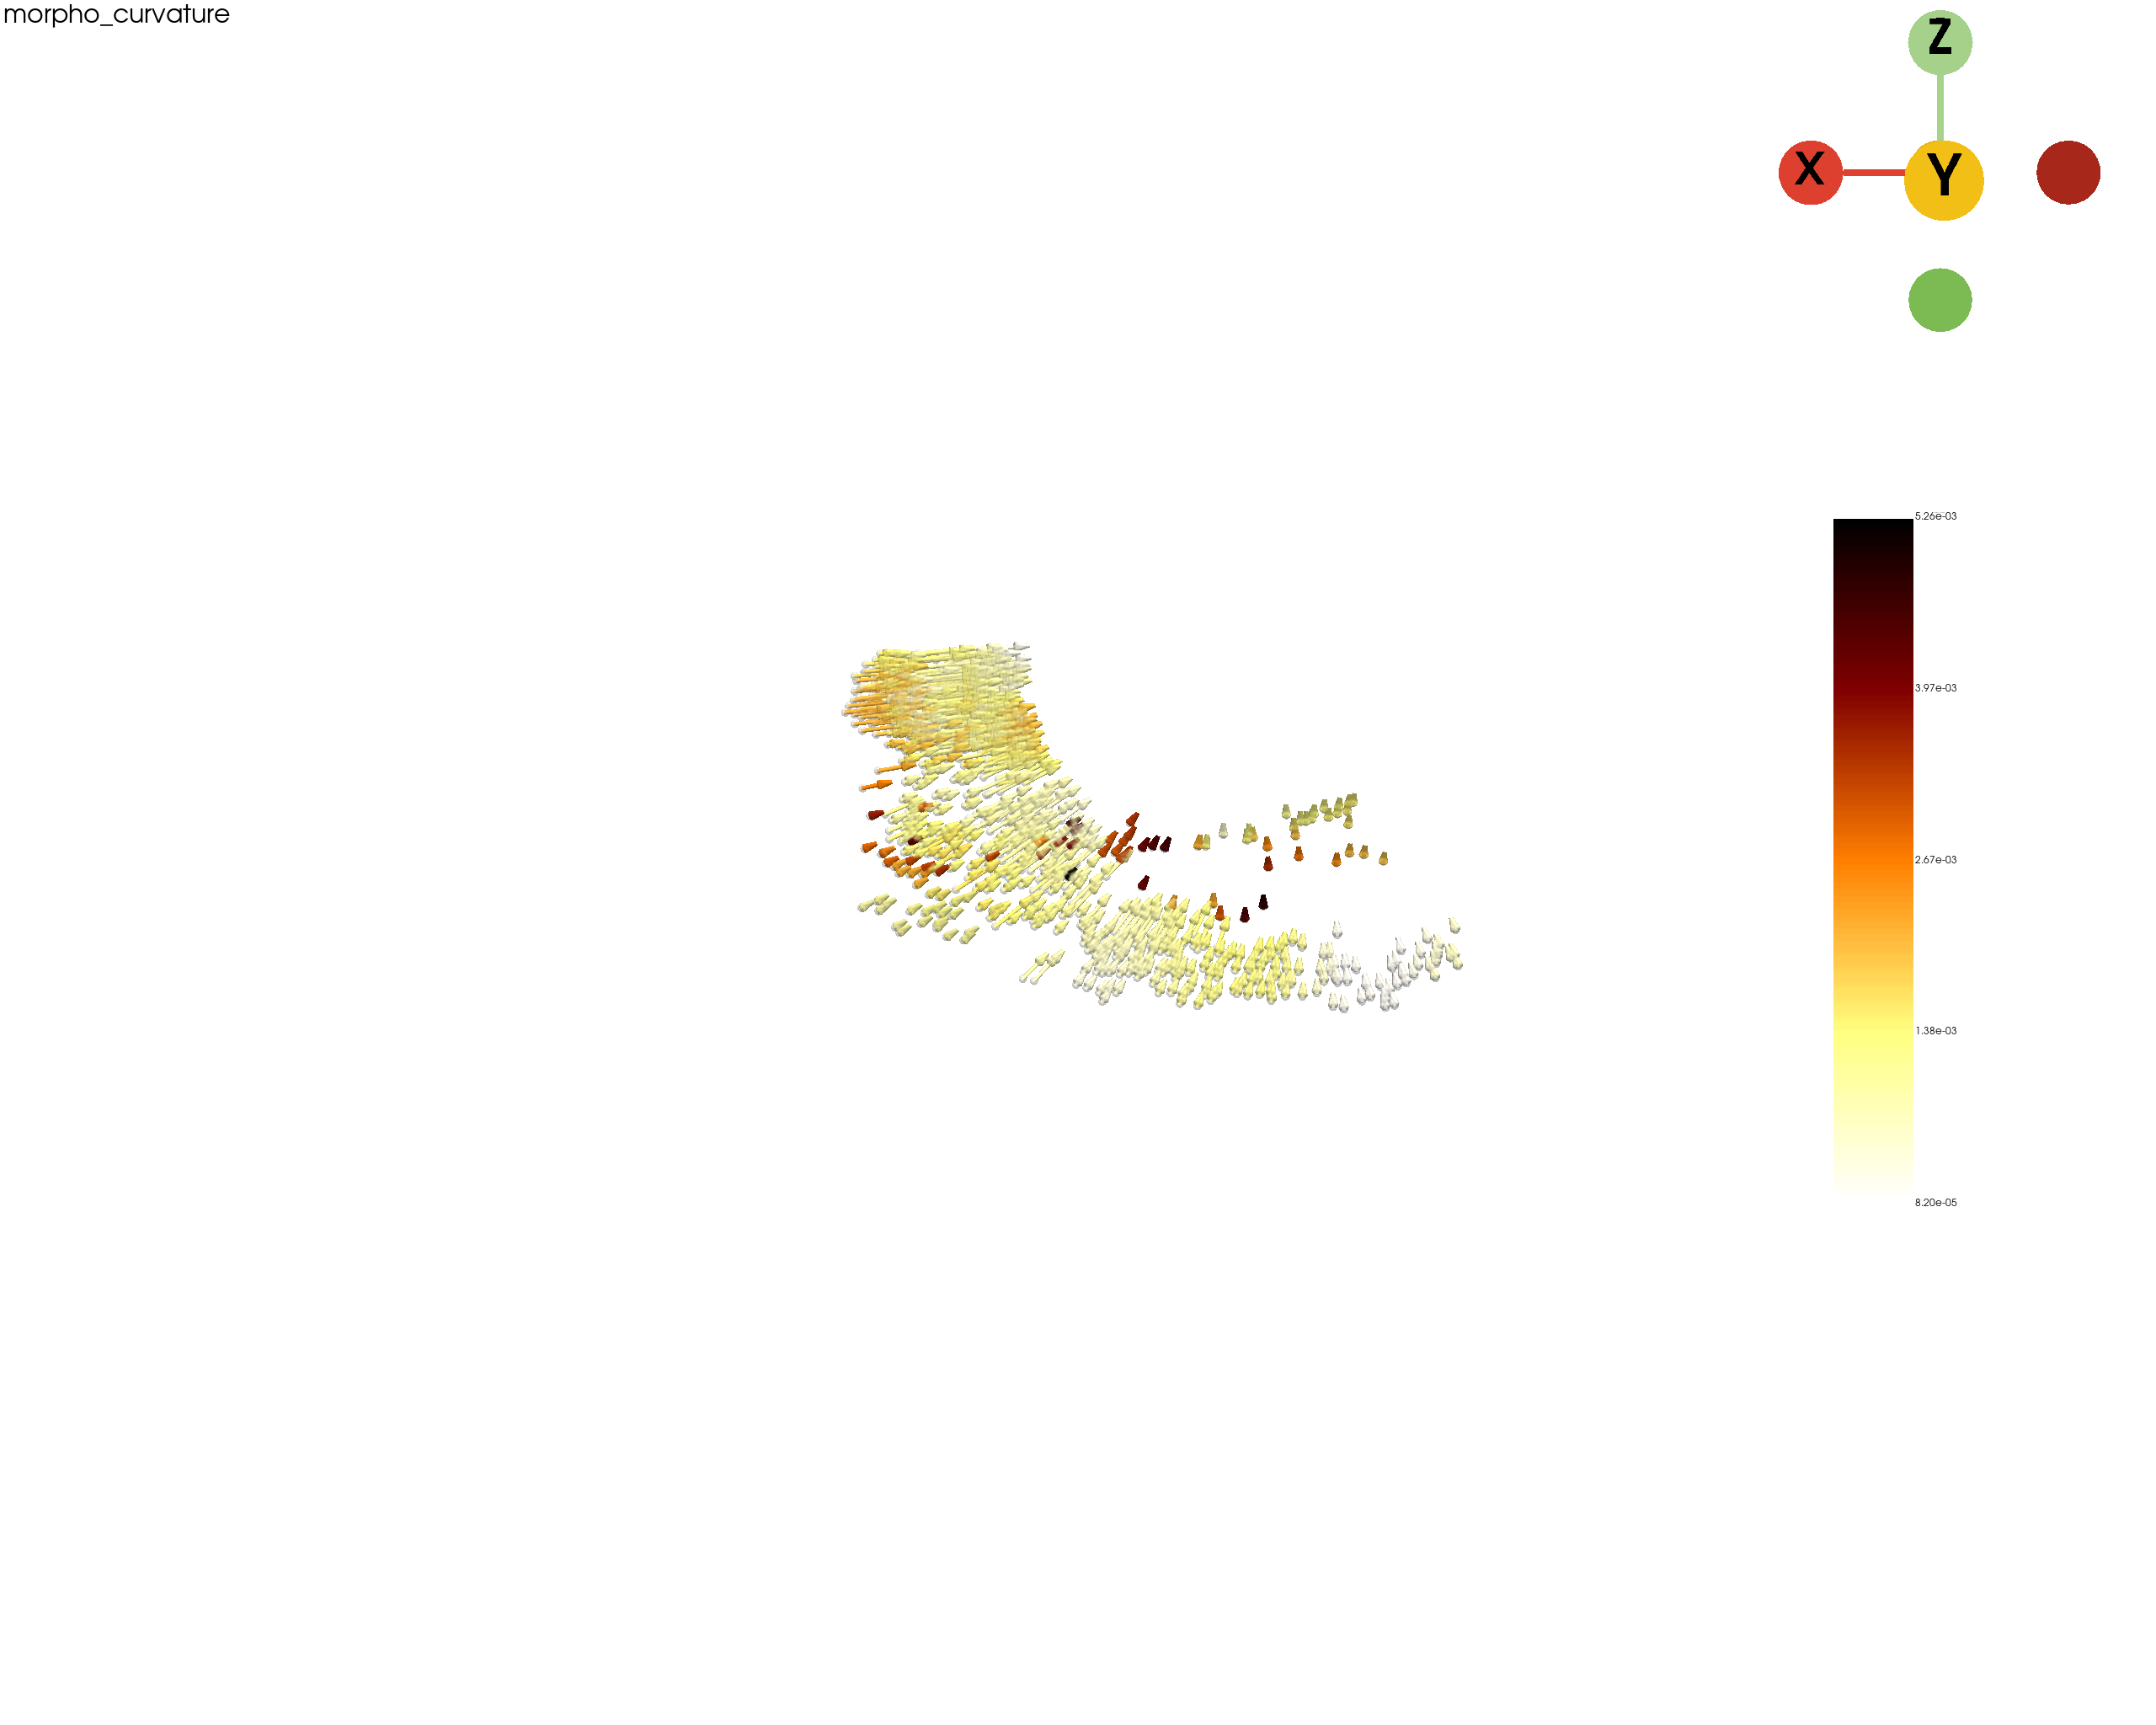

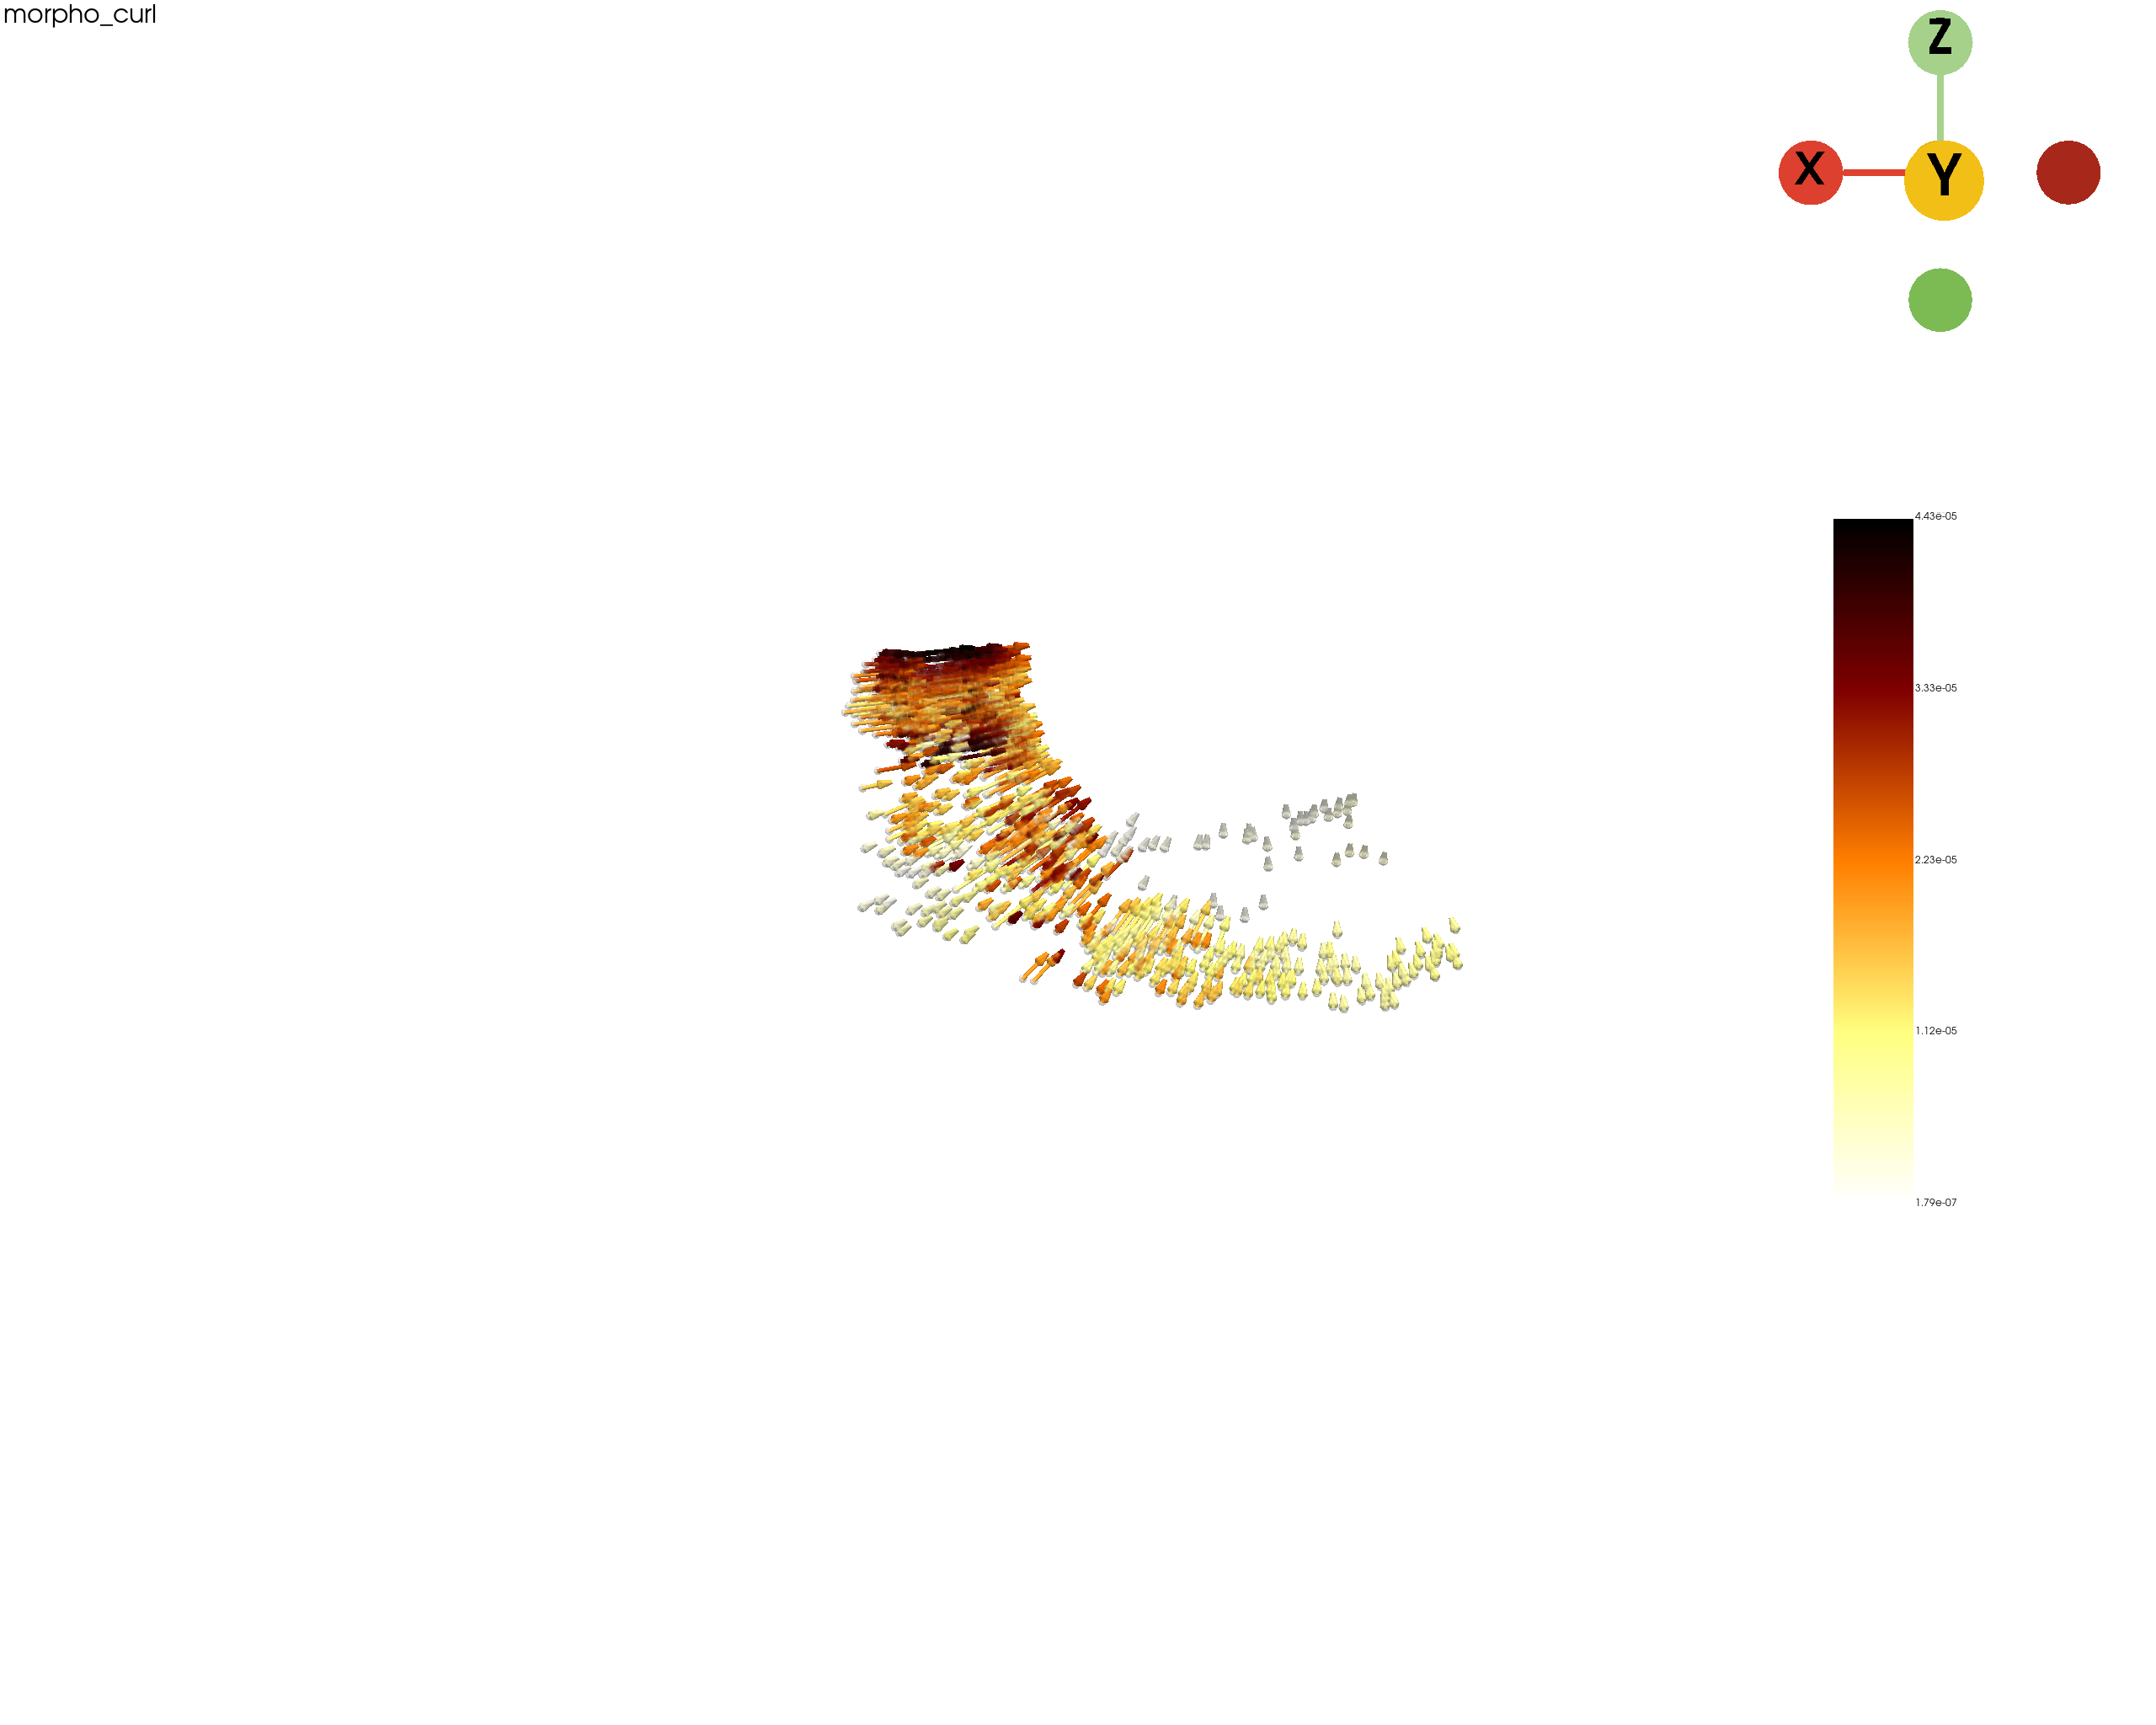

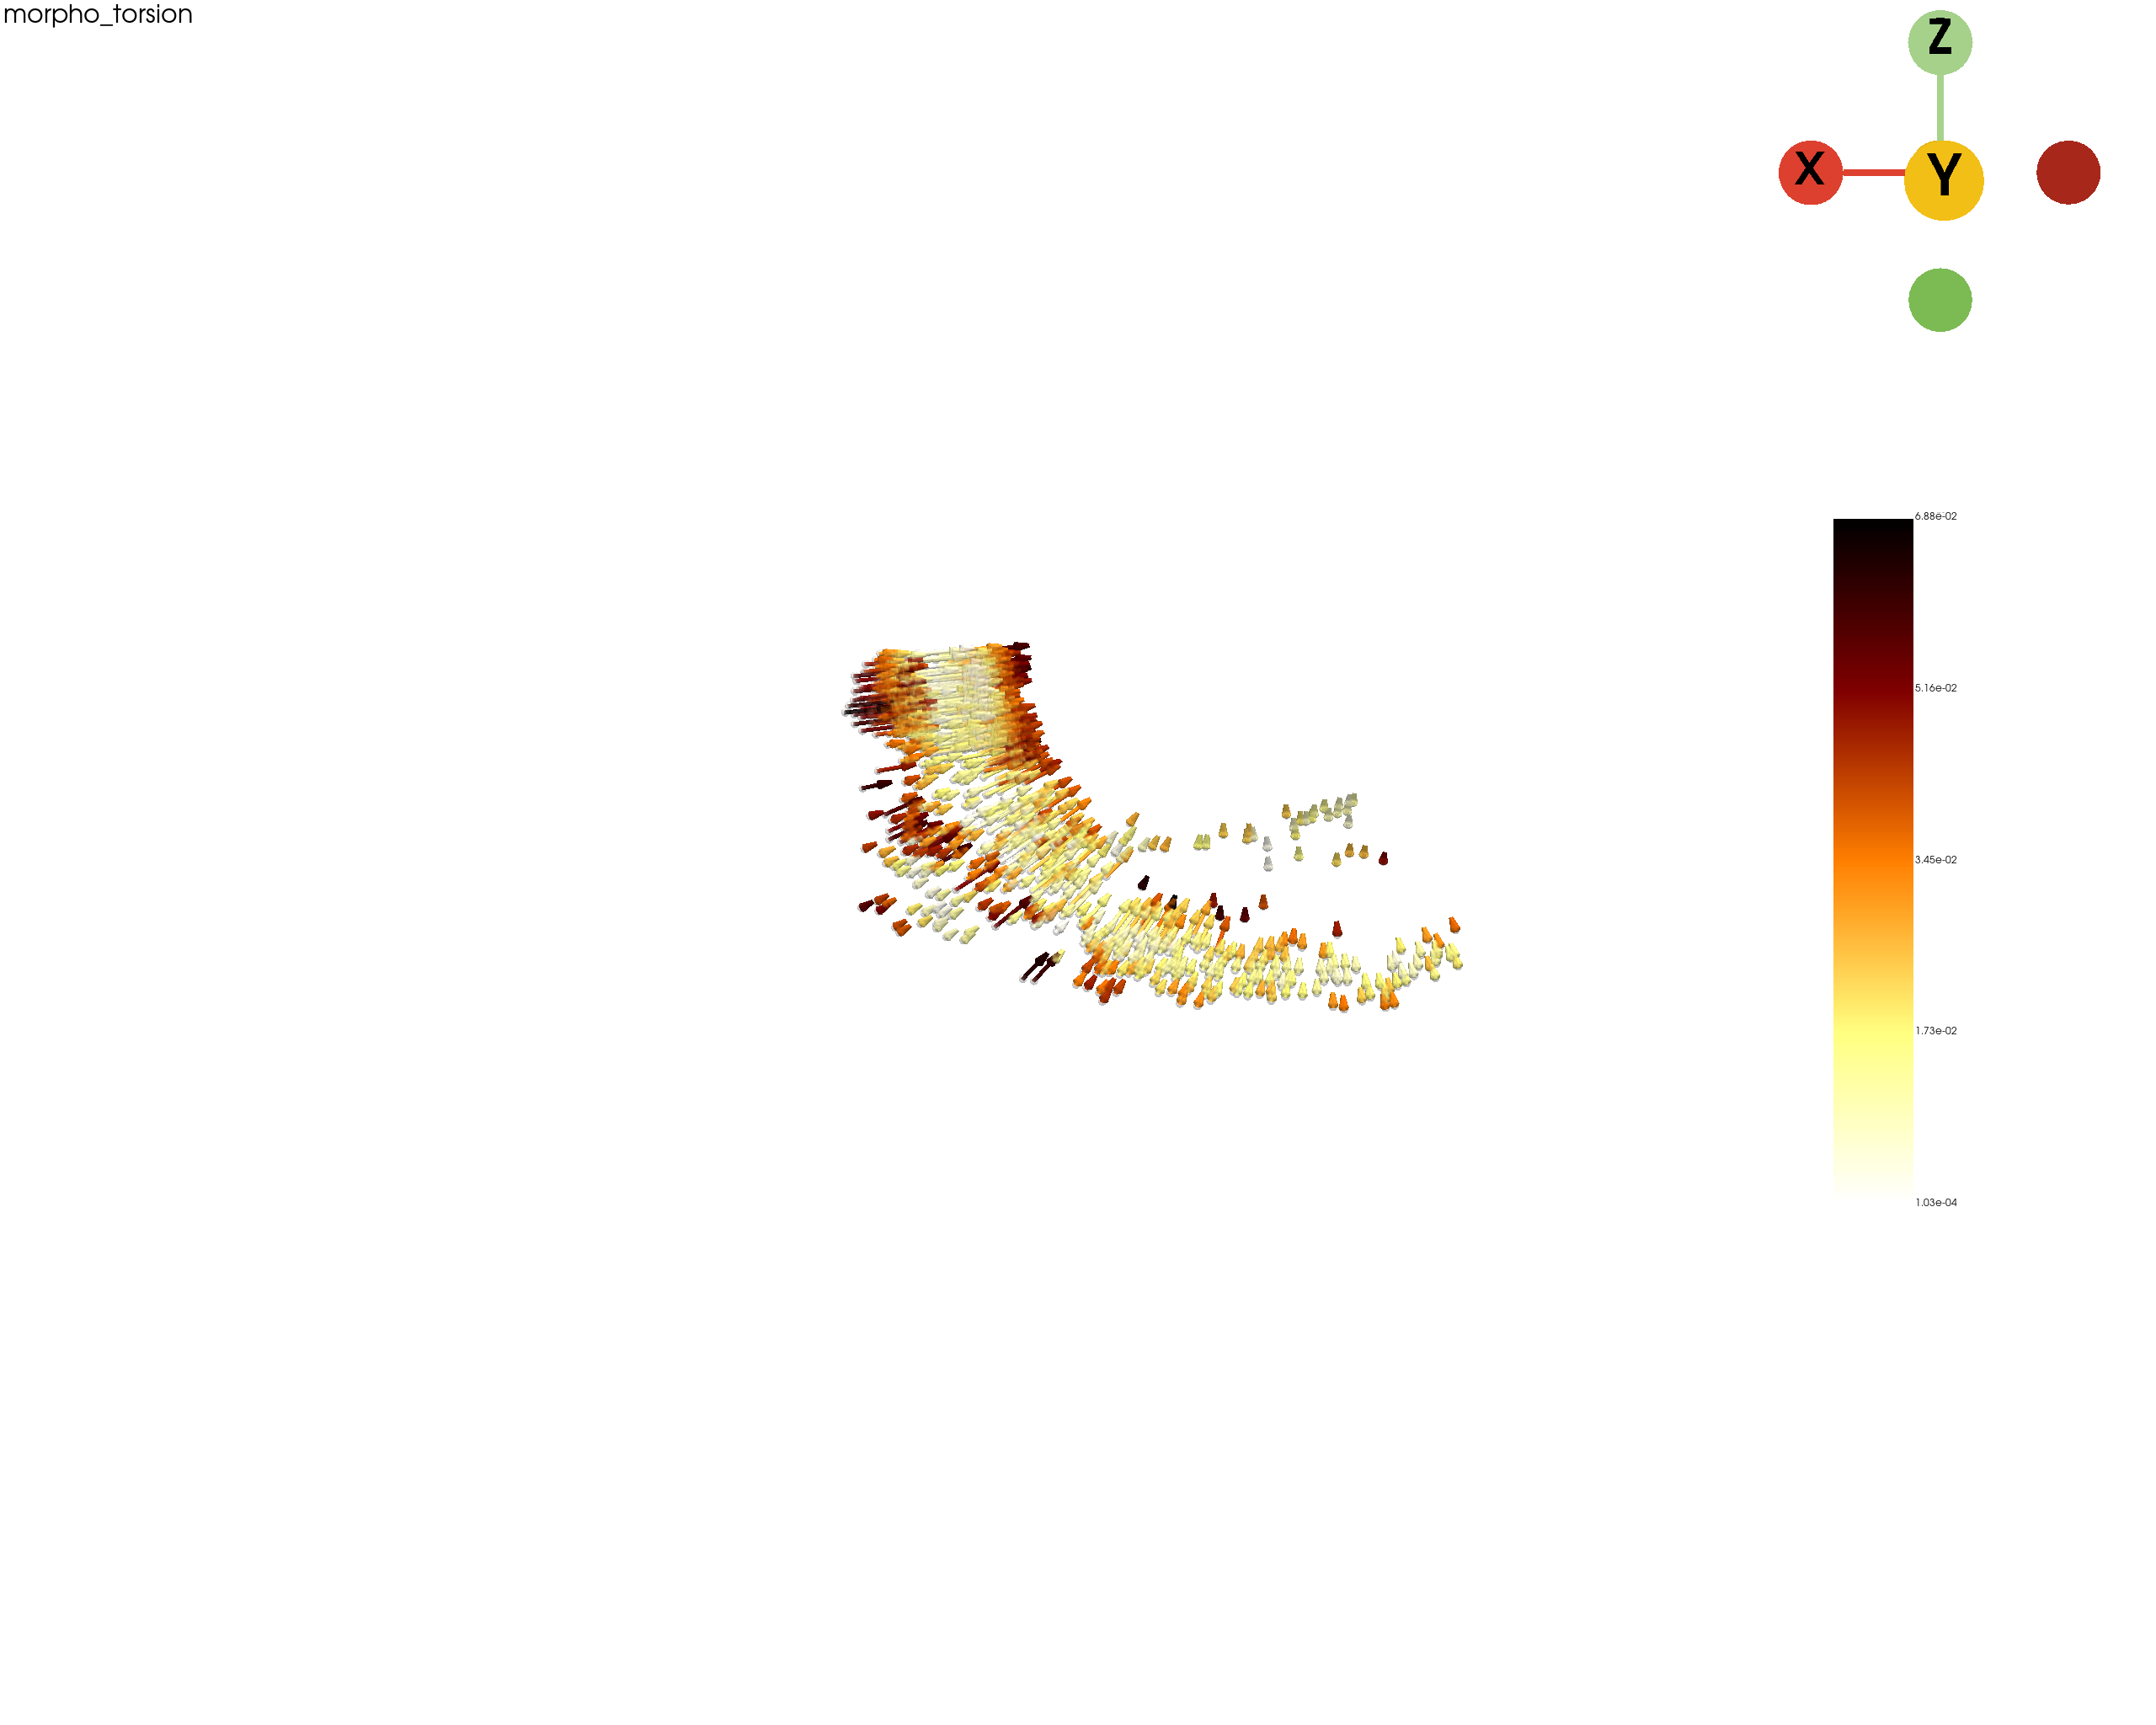

In [29]:
morphometrics_keys = ["morpho_acceleration", "morpho_curvature", "morpho_curl", "morpho_torsion"]
for mk in morphometrics_keys:
    st.tdr.add_model_labels(
        model=trajectory_model,
        key_added=mk,
        labels=np.asarray(adata[np.asarray(trajectory_model.point_data["obs_index"])].obs[mk]),
        colormap="Spectral",
        where="point_data",
        inplace=True,
    )
    st.pl.three_d_plot(
        model=st.tdr.collect_models([pc, trajectory_model]),
        key=["tissue", mk],
        model_style=["points", "wireframe"],
        model_size=[10, 5],
        opacity=[0.5, 0.5],
        colormap=["gainsboro", "afmhot_r"],
        show_legend=True,
        jupyter="static",
        background="white",
        cpo=cpo,
        window_size=(2560, 2048),
        text=mk,
        filename=os.path.join(out_image_path, f"amnioserosa_morphometrics_{mk}_trajectory.pdf")
    )

## Save the anndata objects and models

In [13]:
del cns_gb_adata.uns["fate_morpho"], cns_gb_adata.uns["morpho_torsion"]
cns_gb_adata.write_h5ad(f"h5ad/{sample_id}_CNS_v4.h5ad", compression="gzip")
cns_gb_adata

AnnData object with n_obs × n_vars = 4656 × 7923
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'V_x', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion'
    uns: 'glm_degs', 'log1p', 'pp', 'VecFld_morpho'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial', 'morpho_velocity', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl'
    layers: 'X_counts', 'spliced', 'unspliced'

In [14]:
st.tdr.save_model(model=cns_gb_pc, filename=f"morpho_models/CNS_morphometrics_pc_model.vtk")
st.tdr.save_model(model=cns_mesh, filename=f"morpho_models/CNS_morphometrics_mesh_model.vtk")
st.tdr.save_model(model=trajectory_model, filename=f"morpho_models/CNS_morphofield_trajectory_model.vtk")